In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.keras import TqdmCallback
import glob
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from sklearn import preprocessing
from collections import Counter
from numpy import where
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold
import keras.backend as K

os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

In [2]:
output_path = "/content/drive/MyDrive/labelled data/"

#omit participant p02, p18 and p20
participants = ["p" + str(i).zfill(2) for i in range(0, 25) if i != 2 and i != 18 and i != 20]
print(participants)

['p00', 'p01', 'p03', 'p04', 'p05', 'p06', 'p07', 'p08', 'p09', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p19', 'p21', 'p22', 'p23', 'p24']


# **Pre-processing with StandardScaler()**

In [ ]:
def s(samples):
    std = np.std(samples)
    if std == 0:
        return samples - np.mean(samples)
    else:
        return (samples - np.mean(samples)) / std

def preprocess(df):
  scaler = preprocessing.StandardScaler() #MinMaxScaler
  df_drop = df.drop(['label'], axis=1)
  names = df_drop.columns
  fit = scaler.fit_transform(df_drop)
  scaled_df = pd.DataFrame(fit, columns=names)
  df_new = pd.concat([df['label'],scaled_df], axis = 1)
  return df_new

**Get data with labels 0, 1, 2 (easy, medium, hard levels)**

In [ ]:
def get_only_stress_data(file):
    stress_data = pd.read_csv(file)
    stress_data = stress_data[(stress_data.label == 0) or (stress_data.label == 1) 
                              or (stress_data.label == 2)]
    return stress_data

# **Segmentation with window size 30 (without overlap)**

In [ ]:
eda_freq = 4
temp_freq = 4
hr_freq = 1
bvp_freq = 64
acc_freq = 32

#without overlap
def get_data(pid):
    
    for f in os.listdir(output_path):
        if f.startswith(str(pid)) and f.endswith("EDA.csv"):
            eda_path = f
        elif f.startswith(str(pid)) and f.endswith("TEMP.csv"):
            temp_path = f
        elif f.startswith(str(pid)) and f.endswith("BVP.csv"):
            bvp_path = f
        elif f.startswith(str(pid)) and f.endswith("HR.csv"):
            hr_path = f
        elif f.startswith(str(pid)) and f.endswith("ACC.csv"):
            acc_path = f

    eda_data_raw = get_only_stress_data(output_path + eda_path)
    temp_data_raw = get_only_stress_data(output_path + temp_path)
    bvp_data_raw = get_only_stress_data(output_path + bvp_path)
    hr_data_raw = get_only_stress_data(output_path + hr_path)
    acc_data_raw = get_only_stress_data(output_path + acc_path)

    eda_data = preprocess(eda_data_raw)
    temp_data = preprocess(temp_data_raw)
    bvp_data = preprocess(bvp_data_raw)
    hr_data = preprocess(hr_data_raw)
    acc_data = preprocess(acc_data_raw)

    eda = []; temp=[]; label=[]; bvp=[]; hr=[]; acc_x=[]; acc_y=[]; acc_z=[]; win_size = 30; 
    
    for i in range(win_size, int(len(bvp_data_raw['bvp']) / bvp_freq)):

        eda.append(s(eda_data['eda'][eda_freq * (i - win_size): eda_freq * i]))

        temp.append(s(temp_data['temp'][temp_freq * (i - win_size): temp_freq * i]))

        bvp.append(s(bvp_data['bvp'][bvp_freq * (i - win_size): bvp_freq * i]))

        hr.append(s(hr_data['bpm'][hr_freq * (i - win_size): hr_freq * i]))

        acc_x.append(s(acc_data['x'][acc_freq * (i - win_size): acc_freq * i]))

        acc_y.append(s(acc_data['y'][acc_freq * (i - win_size): acc_freq * i]))

        acc_z.append(s(acc_data['z'][acc_freq * (i - win_size): acc_freq * i]))

        l = eda_data["label"][eda_freq * (i - win_size): eda_freq * i]
        lp = np.bincount(np.array(l)).argmax()
        label.append(lp)
    
    return {"acc_x": np.array(acc_x, dtype=object),
            "acc_y": np.array(acc_y, dtype=object), 
            "acc_z": np.array(acc_z, dtype=object), 
            "eda": np.array(eda, dtype=object), 
            "temp": np.array(temp, dtype=object), 
            "bvp": np.array(bvp, dtype=object),
            "hr": np.array(hr, dtype=object), 
            "label": np.array(label)}

In [ ]:
all_data = [get_data(pid) for pid in participants]

In [ ]:
for pid in range(len(all_data)):
        print(all_data[pid]['acc_x'].shape) #(samples,960)
        print(all_data[pid]['acc_y'].shape) #(samples,960)
        print(all_data[pid]['acc_z'].shape) #(samples,960)
        print(all_data[pid]['eda'].shape)   #(samples,120)
        print(all_data[pid]['bvp'].shape)   #(samples,1920)
        print(all_data[pid]['temp'].shape)  #(samples,120)
        print(all_data[pid]['hr'].shape)    #(samples,30)
        print(all_data[pid]['label'].shape) #(samples,)

In [ ]:
#without HR data
all_features = ['eda','bvp','temp','acc_x','acc_y','acc_z']

# **ResNet model**

In [ ]:
def classifier(train_dataset):
    models = []
    for feature in all_features:
      filter_size = 64
      input_shape = train_dataset[feature].shape[1]

      input = keras.layers.Input(shape=(input_shape,1))
    
      #BLOCK 1
      conv_x = keras.layers.Conv1D(filters=filter_size, kernel_size=8, padding='same')(input)
      conv_x = keras.layers.BatchNormalization()(conv_x)
      conv_x = keras.layers.Activation('relu')(conv_x)

      conv_y = keras.layers.Conv1D(filters=filter_size, kernel_size=5, padding='same')(conv_x)
      conv_y = keras.layers.BatchNormalization()(conv_y)
      conv_y = keras.layers.Activation('relu')(conv_y)

      conv_z = keras.layers.Conv1D(filters=filter_size, kernel_size=3, padding='same')(conv_y)
      conv_z = keras.layers.BatchNormalization()(conv_z)

      shortcut_y = keras.layers.Conv1D(filters=filter_size, kernel_size=1, padding='same')(input)
      shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

      output_block_1 = keras.layers.add([shortcut_y, conv_z])
      output_block_1 = keras.layers.Activation('relu')(output_block_1)

      #BLOCK 2

      conv_x = keras.layers.Conv1D(filters=filter_size * 2, kernel_size=8, padding='same')(output_block_1)
      conv_x = keras.layers.BatchNormalization()(conv_x)
      conv_x = keras.layers.Activation('relu')(conv_x)

      conv_y = keras.layers.Conv1D(filters=filter_size * 2, kernel_size=5, padding='same')(conv_x)
      conv_y = keras.layers.BatchNormalization()(conv_y)
      conv_y = keras.layers.Activation('relu')(conv_y)

      conv_z = keras.layers.Conv1D(filters=filter_size * 2, kernel_size=3, padding='same')(conv_y)
      conv_z = keras.layers.BatchNormalization()(conv_z)

      shortcut_y = keras.layers.Conv1D(filters=filter_size * 2, kernel_size=1, padding='same')(output_block_1)
      shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

      output_block_2 = keras.layers.add([shortcut_y, conv_z])
      output_block_2 = keras.layers.Activation('relu')(output_block_2)

      #BLOCK 3

      conv_x = keras.layers.Conv1D(filters=filter_size * 2, kernel_size=8, padding='same')(output_block_2)
      conv_x = keras.layers.BatchNormalization()(conv_x)
      conv_x = keras.layers.Activation('relu')(conv_x)

      conv_y = keras.layers.Conv1D(filters=filter_size * 2, kernel_size=5, padding='same')(conv_x)
      conv_y = keras.layers.BatchNormalization()(conv_y)
      conv_y = keras.layers.Activation('relu')(conv_y)

      conv_z = keras.layers.Conv1D(filters=filter_size * 2, kernel_size=3, padding='same')(conv_y)
      conv_z = keras.layers.BatchNormalization()(conv_z)

      shortcut_y = keras.layers.BatchNormalization()(output_block_2)

      output_block_3 = keras.layers.add([shortcut_y, conv_z])
      output_block_3 = keras.layers.Activation('relu')(output_block_3)

      gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)

      models.append(tf.keras.Model(inputs=input, outputs=gap_layer))

    concat_layer = keras.layers.concatenate([x.output for x in models])

    output_layer = keras.layers.Dense(3, activation="softmax")(concat_layer)

    model = keras.Model(inputs=[x.input for x in models], outputs=output_layer)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="sparse_categorical_crossentropy", 
                  metrics=['accuracy'])

    return model

In [ ]:
scores = []
acc_per_sub, loss_per_sub = [], []
f1_per_sub, prec_per_sub, rec_per_sub = [], [], []
conf_matrix_per_sub = []

**Reshape, fit and evaluate the model**

In [ ]:
def ResNet(train_dataset, test_dataset):
    
    X_train_smote = {}

    for feature in all_features:
      sm = SMOTE()
      X_train_smote[feature], y_train = sm.fit_resample(train_dataset[feature], train_dataset["label"])


    X_train = []
    for feature in all_features:
        X_train_reshape = X_train_smote[feature].reshape(X_train_smote[feature].shape[0],X_train_smote[feature].shape[1]
                                                         , 1).astype(np.float32)
        X_train.append(X_train_reshape)
    #y_train = train_dataset["label"]

    X_test = []
    for feature in all_features:
        X_test_reshape = test_dataset[feature].reshape(test_dataset[feature].shape[0],test_dataset[feature].shape[1]
                                                       , 1).astype(np.float32)
        X_test.append(X_test_reshape)
    y_test = test_dataset["label"]

    model = classifier(train_dataset)
    
    history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_test, y_test), verbose=0)

    scores = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
    print(f'Score : {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    
    acc_per_sub.append(scores[1] * 100)
    loss_per_sub.append(scores[0])

    y_pred = np.argmax(model.predict(X_test), axis=1)
    f1_per_sub.append(f1_score(y_test, y_pred, average='weighted'))
    prec_per_sub.append(precision_score(y_test, y_pred, average='weighted'))
    rec_per_sub.append(recall_score(y_test, y_pred, average='weighted'))

    print('F1 score: ', f1_score(y_test, y_pred, average='weighted'))
    print('Precision: ',precision_score(y_test, y_pred, average='weighted'))
    print('Recall: ',recall_score(y_test, y_pred, average='weighted'))

    pd.DataFrame(history.history).plot(figsize=(6, 5))
    plt.show()
        
    cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
    conf_matrix_per_sub.append(cm)
    print(cm)
    ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.1%', cmap='Reds')
    ax.figsize=(5,5)
    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    
    ax.xaxis.set_ticklabels(['0','1','2'])
    ax.yaxis.set_ticklabels(['0','1','2'])

    plt.show()

    return conf_matrix_per_sub, acc_per_sub, loss_per_sub, f1_per_sub, prec_per_sub, rec_per_sub

# **Without finetuning test data (LOSO)**



Subject 0
8/8 [==============================] - 0s 43ms/step - loss: 2.3188 - accuracy: 0.4919
Score : loss of 2.318845510482788; accuracy of 49.18566644191742%
29/29 [==============================] - 3s 19ms/step
F1 score:  0.40210233189349665
Precision:  0.40469645526996867
Recall:  0.49294245385450597


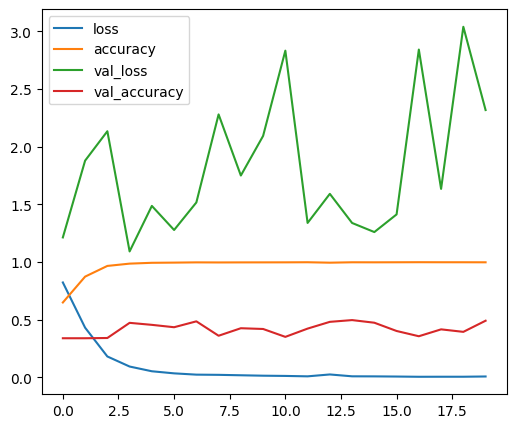

[[  3 234  76]
 [  0 257  57]
 [ 13  87 194]]


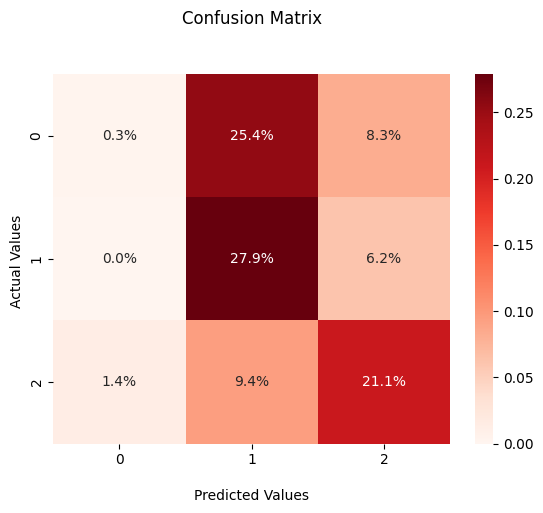

Subject 1
8/8 [==============================] - 0s 42ms/step - loss: 6.6478 - accuracy: 0.3423
Score : loss of 6.647829055786133; accuracy of 34.23035442829132%
30/30 [==============================] - 3s 18ms/step
F1 score:  0.1745830466747751
Precision:  0.11717172185330708
Recall:  0.34230355220667386


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


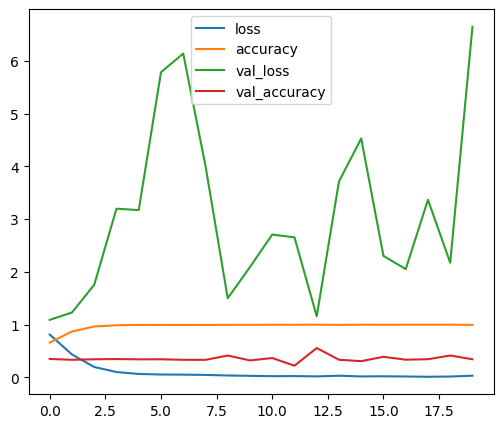

[[  0 309   0]
 [  0 318   0]
 [  0 302   0]]


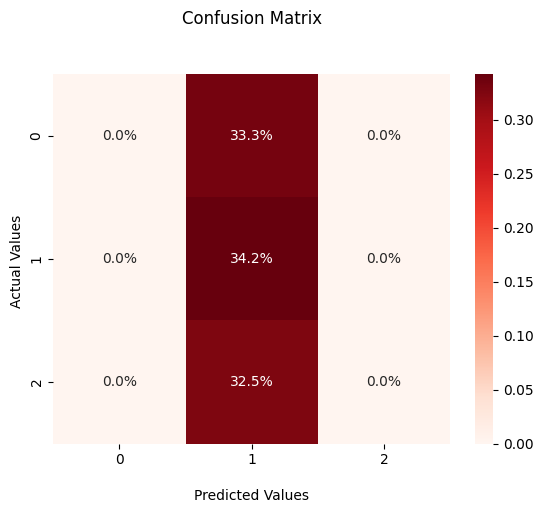

Subject 2
8/8 [==============================] - 0s 43ms/step - loss: 1.5142 - accuracy: 0.4372
Score : loss of 1.5142195224761963; accuracy of 43.72294247150421%
29/29 [==============================] - 3s 18ms/step
F1 score:  0.43321002657586444
Precision:  0.44073654620712815
Recall:  0.43722943722943725


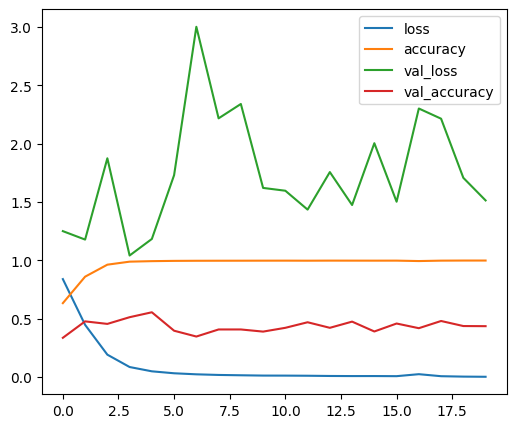

[[135  88  89]
 [ 88  92 131]
 [ 23 101 177]]


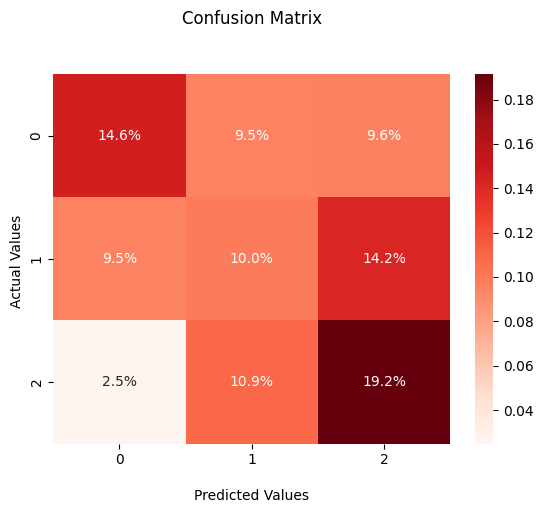

Subject 3
8/8 [==============================] - 0s 43ms/step - loss: 3.9671 - accuracy: 0.3333
Score : loss of 3.967142105102539; accuracy of 33.33333432674408%
29/29 [==============================] - 3s 19ms/step
F1 score:  0.19868961218934608
Precision:  0.2869002467441021
Recall:  0.3333333333333333


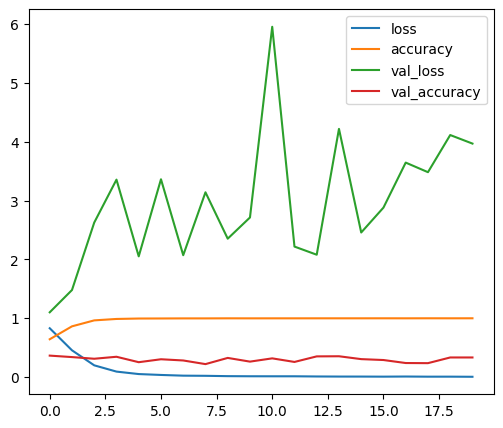

[[285   0   9]
 [306  22   0]
 [278  21   0]]


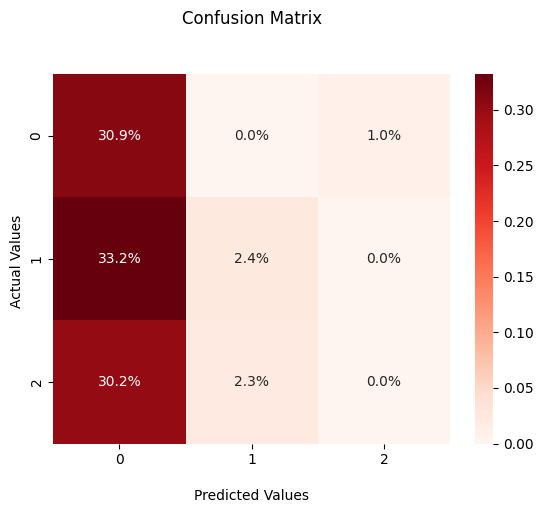

Subject 4
8/8 [==============================] - 0s 43ms/step - loss: 2.7280 - accuracy: 0.2790
Score : loss of 2.72796893119812; accuracy of 27.89934277534485%
29/29 [==============================] - 3s 19ms/step
F1 score:  0.19084262529310883
Precision:  0.23512451452370592
Recall:  0.2789934354485777


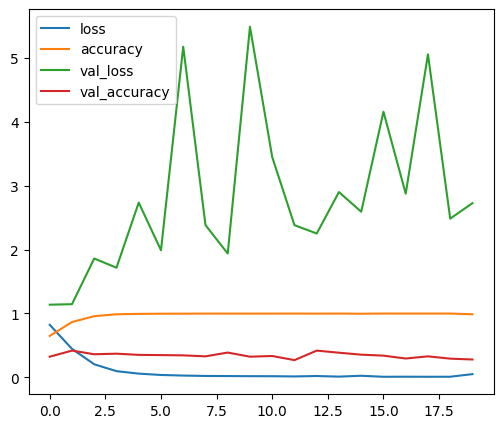

[[225  27  43]
 [257  16  42]
 [273  17  14]]


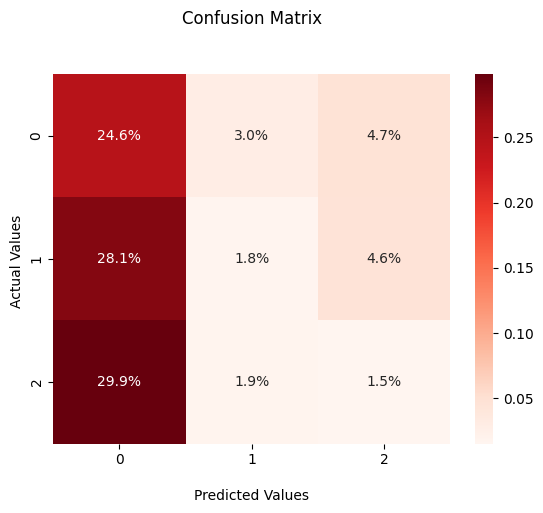

Subject 5
8/8 [==============================] - 0s 43ms/step - loss: 3.0096 - accuracy: 0.3264
Score : loss of 3.0095748901367188; accuracy of 32.639649510383606%
29/29 [==============================] - 3s 19ms/step
F1 score:  0.19707032936500293
Precision:  0.2572479760378769
Recall:  0.3263964950711939


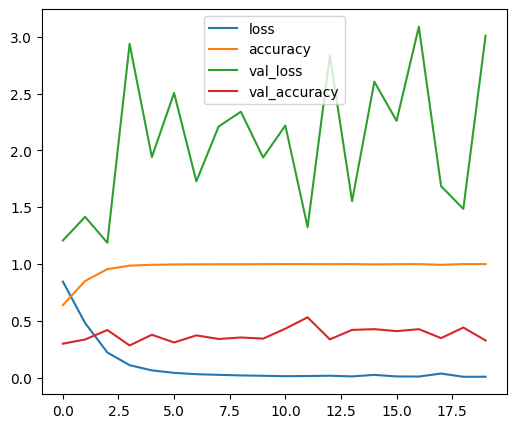

[[  5 288   5]
 [ 16 284  14]
 [ 26 266   9]]


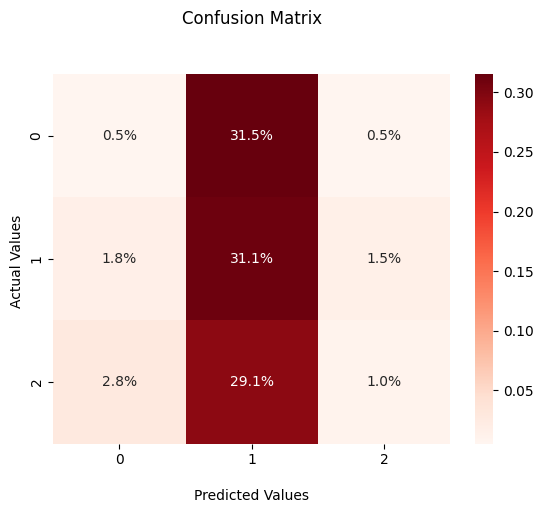

Subject 6
8/8 [==============================] - 0s 43ms/step - loss: 6.1260 - accuracy: 0.3373
Score : loss of 6.125952243804932; accuracy of 33.72972905635834%
29/29 [==============================] - 3s 19ms/step
F1 score:  0.18585282203724174
Precision:  0.25264363701449793
Recall:  0.3372972972972973


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


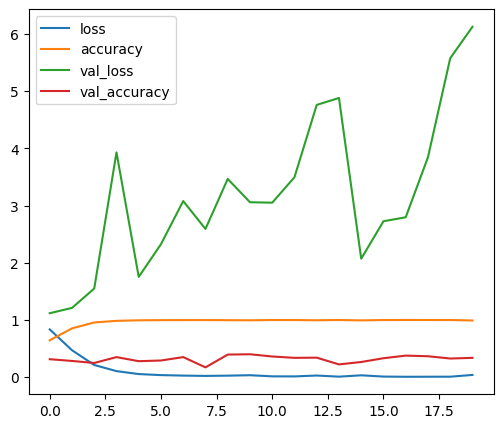

[[  8 296   0]
 [ 11 304   0]
 [  0 306   0]]


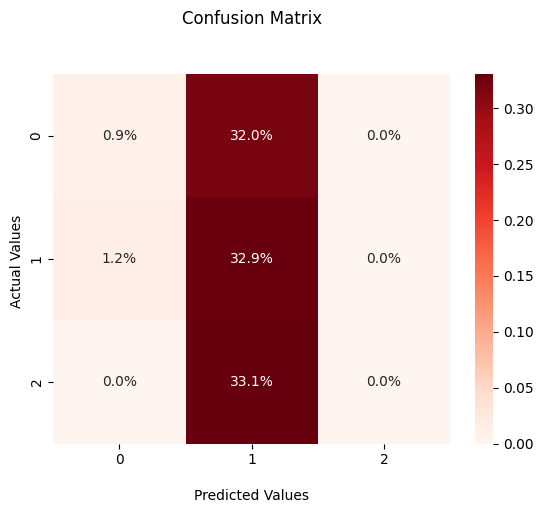

Subject 7
8/8 [==============================] - 0s 43ms/step - loss: 5.0931 - accuracy: 0.3185
Score : loss of 5.0931220054626465; accuracy of 31.84782564640045%
29/29 [==============================] - 3s 19ms/step
F1 score:  0.18714911224017597
Precision:  0.25662933468616095
Recall:  0.3184782608695652


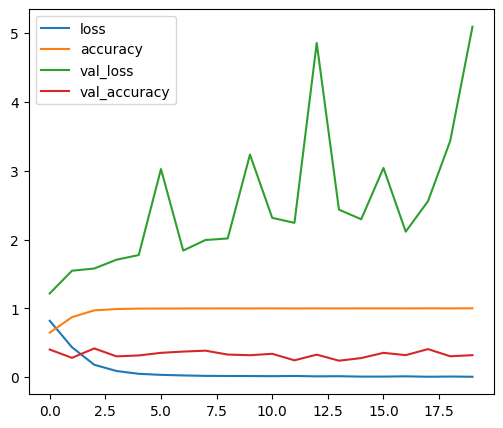

[[ 15   0 294]
 [ 28   2 283]
 [ 13   9 276]]


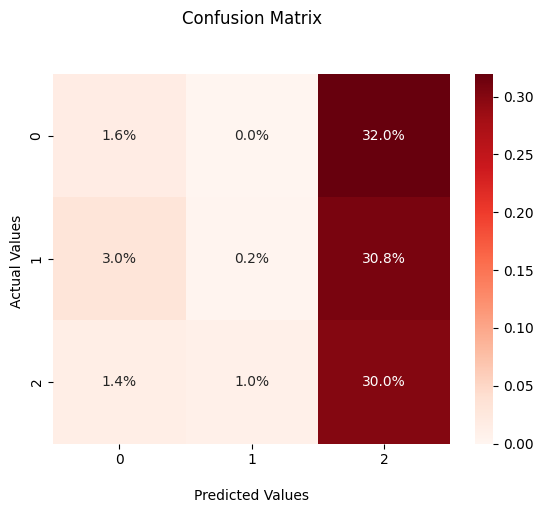

Subject 8
8/8 [==============================] - 0s 42ms/step - loss: 1.6180 - accuracy: 0.4002
Score : loss of 1.6179815530776978; accuracy of 40.02229571342468%
29/29 [==============================] - 3s 19ms/step
F1 score:  0.3798391832237273
Precision:  0.43124007613597565
Recall:  0.4013377926421405


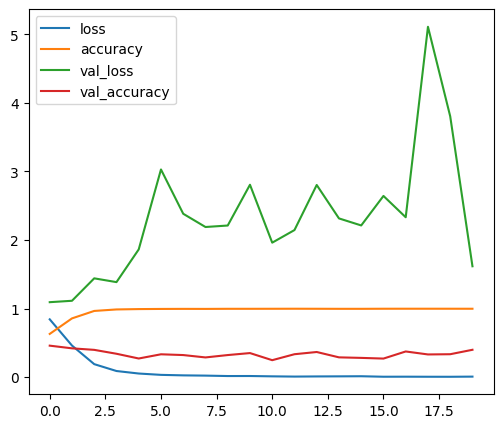

[[ 44  43 215]
 [ 31 148 130]
 [ 26  92 168]]


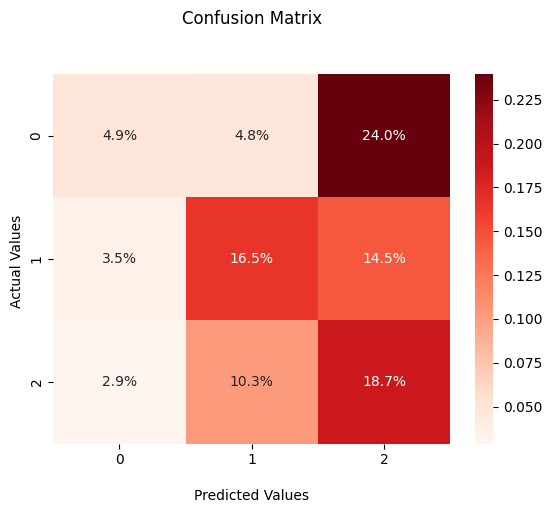

Subject 9
8/8 [==============================] - 0s 43ms/step - loss: 4.7346 - accuracy: 0.3454
Score : loss of 4.734577655792236; accuracy of 34.535518288612366%
29/29 [==============================] - 3s 18ms/step
F1 score:  0.1816756837380846
Precision:  0.12325808172802707
Recall:  0.3453551912568306


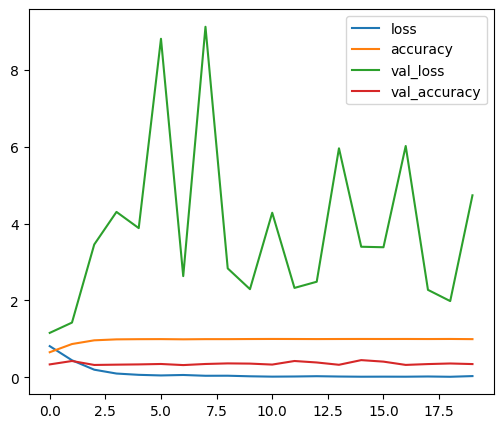

[[  0 302   0]
 [  0 316   2]
 [ 22 273   0]]


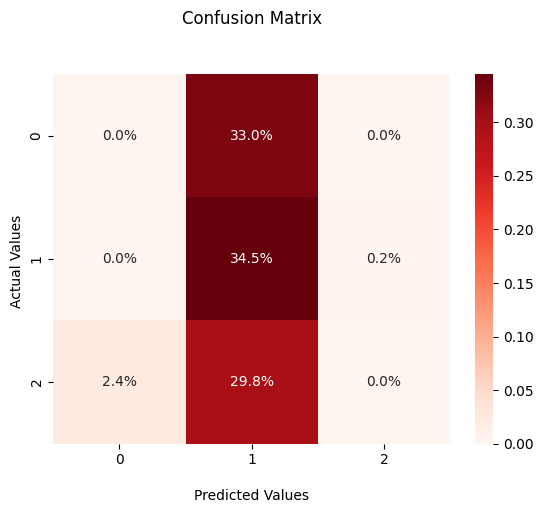

Subject 10
8/8 [==============================] - 0s 47ms/step - loss: 4.8364 - accuracy: 0.3107
Score : loss of 4.836428642272949; accuracy of 31.074035167694092%
30/30 [==============================] - 3s 19ms/step
F1 score:  0.25609439819932045
Precision:  0.29941450386504587
Recall:  0.310740354535975


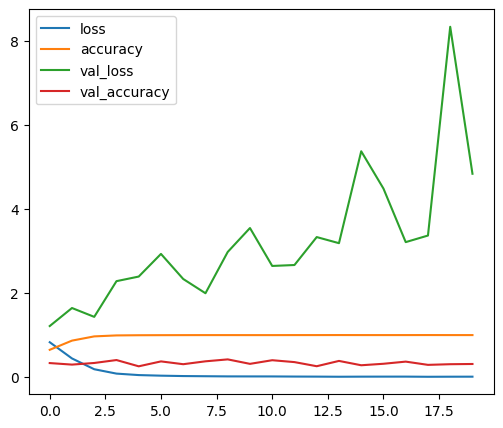

[[223  41  58]
 [213  28  85]
 [246  18  47]]


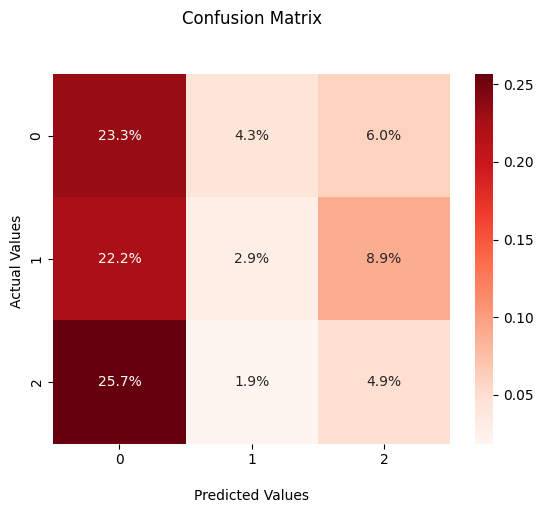

Subject 11
8/8 [==============================] - 0s 42ms/step - loss: 9.1558 - accuracy: 0.3268
Score : loss of 9.155755043029785; accuracy of 32.681867480278015%
29/29 [==============================] - 3s 18ms/step
F1 score:  0.17278599401012104
Precision:  0.22874767570355534
Recall:  0.3268186753528773


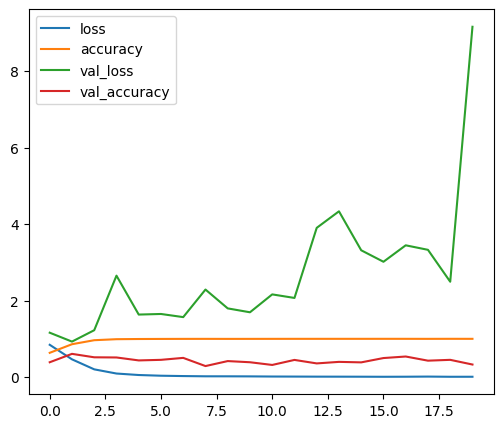

[[  6   1 292]
 [  7   0 314]
 [  3   3 295]]


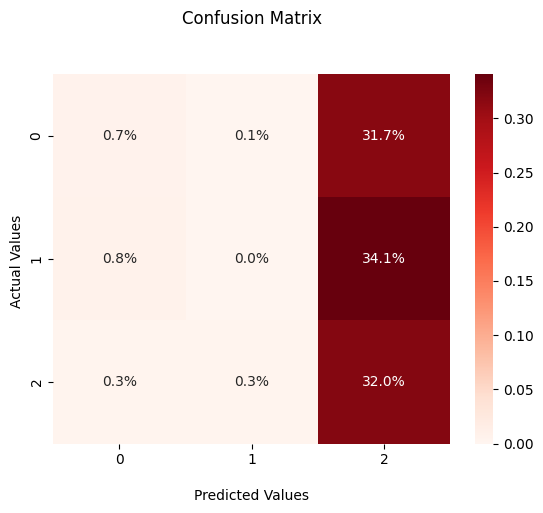

Subject 12
8/8 [==============================] - 0s 42ms/step - loss: 7.5032 - accuracy: 0.3700
Score : loss of 7.503166198730469; accuracy of 37.00440526008606%
29/29 [==============================] - 3s 19ms/step
F1 score:  0.2531066108083357
Precision:  0.5937306724906616
Recall:  0.3700440528634361


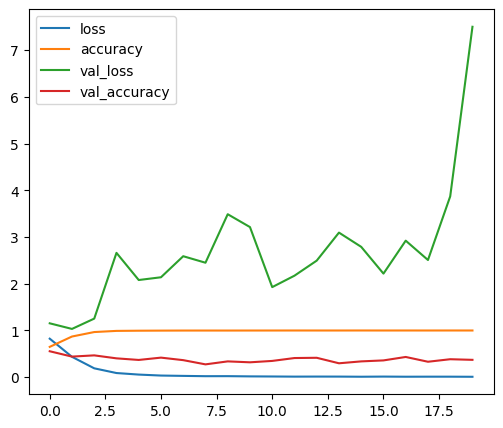

[[292   0   0]
 [293  13   0]
 [261  18  31]]


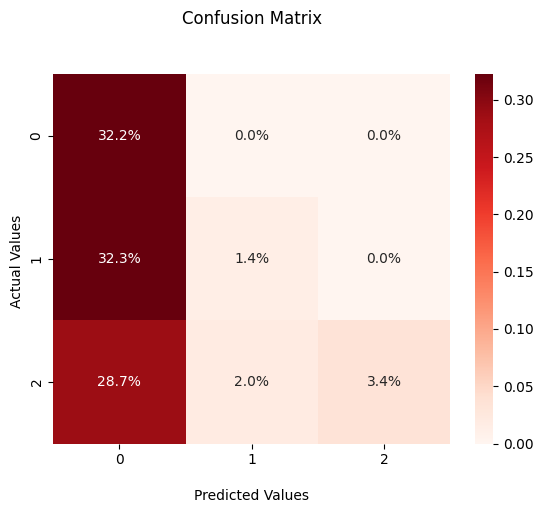

Subject 13
8/8 [==============================] - 0s 43ms/step - loss: 6.1814 - accuracy: 0.2843
Score : loss of 6.181363582611084; accuracy of 28.431373834609985%
29/29 [==============================] - 3s 18ms/step
F1 score:  0.20796301087408176
Precision:  0.19486465520517
Recall:  0.28431372549019607


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


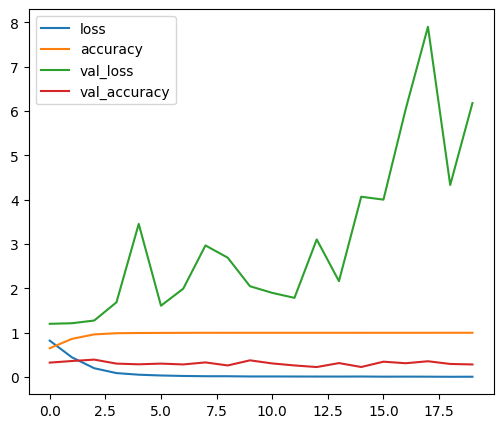

[[ 62   0 237]
 [ 30   0 293]
 [ 97   0 199]]


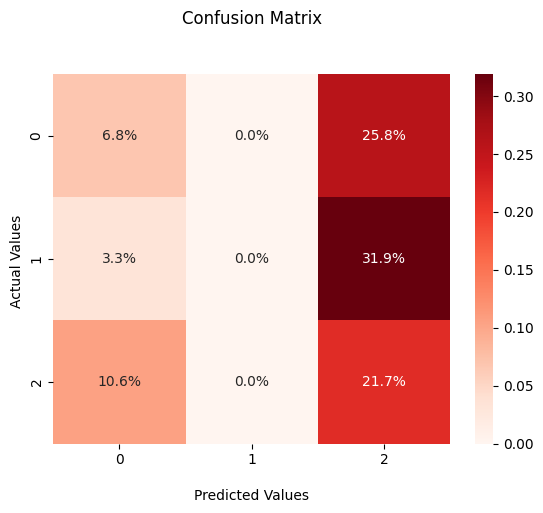

Subject 14
8/8 [==============================] - 0s 44ms/step - loss: 6.5936 - accuracy: 0.3365
Score : loss of 6.593594074249268; accuracy of 33.65180492401123%
30/30 [==============================] - 3s 21ms/step
F1 score:  0.17106556782672191
Precision:  0.11468133647169483
Recall:  0.3365180467091295


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


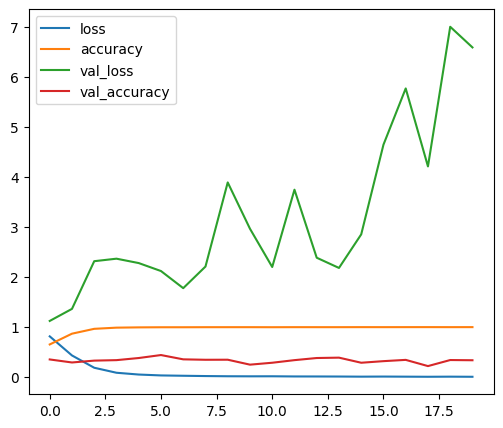

[[  0   0 302]
 [  0   0 320]
 [  0   3 317]]


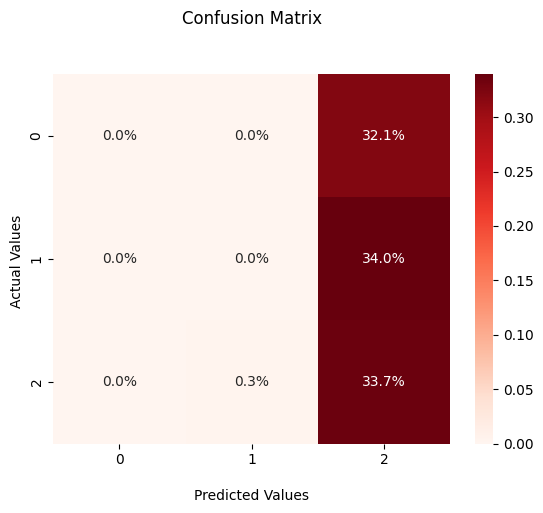

Subject 15
8/8 [==============================] - 0s 43ms/step - loss: 9.6647 - accuracy: 0.3249
Score : loss of 9.664746284484863; accuracy of 32.48898684978485%
29/29 [==============================] - 3s 19ms/step
F1 score:  0.15987930321040275
Precision:  0.10602800538154054
Recall:  0.3248898678414097


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


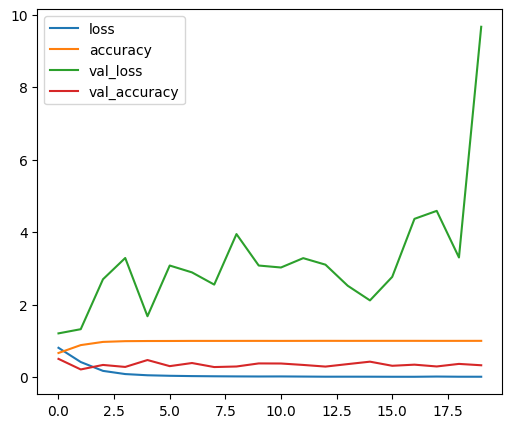

[[  0   0 313]
 [  0   0 299]
 [  0   1 295]]


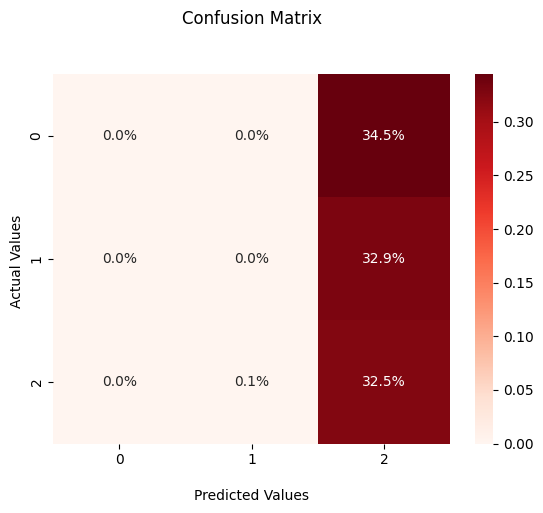

Subject 16
8/8 [==============================] - 0s 40ms/step - loss: 3.6092 - accuracy: 0.3575
Score : loss of 3.609208822250366; accuracy of 35.74514091014862%
29/29 [==============================] - 2s 16ms/step
F1 score:  0.2813420275571651
Precision:  0.23644454140933588
Recall:  0.357451403887689


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


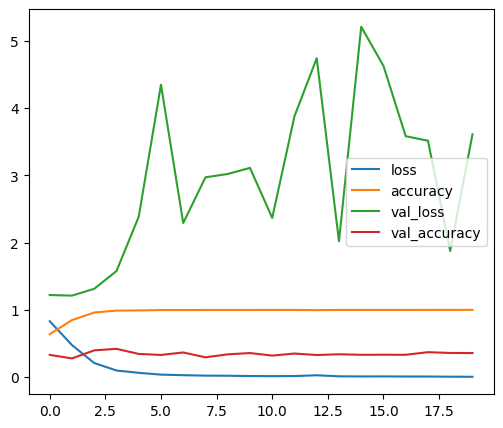

[[133   0 184]
 [145   0 167]
 [ 99   0 198]]


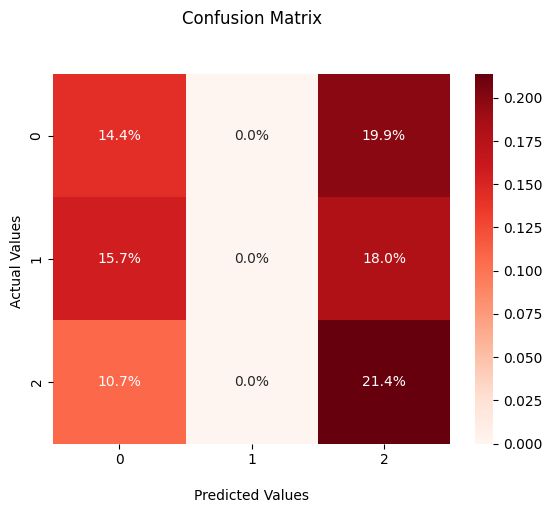

Subject 17
8/8 [==============================] - 0s 40ms/step - loss: 2.6761 - accuracy: 0.4872
Score : loss of 2.6761438846588135; accuracy of 48.71520400047302%
30/30 [==============================] - 2s 18ms/step
F1 score:  0.38866466701147956
Precision:  0.32353233966478967
Recall:  0.48822269807280516


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


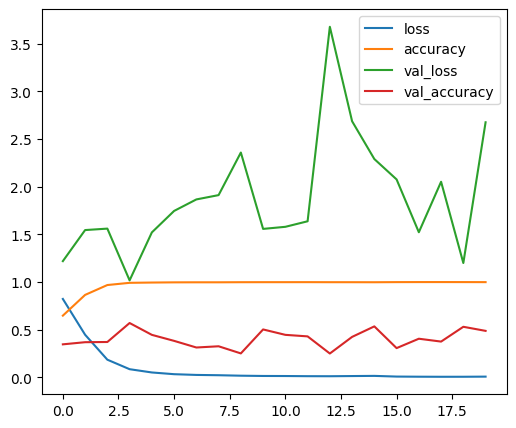

[[189   0 134]
 [224   0  85]
 [ 35   0 267]]


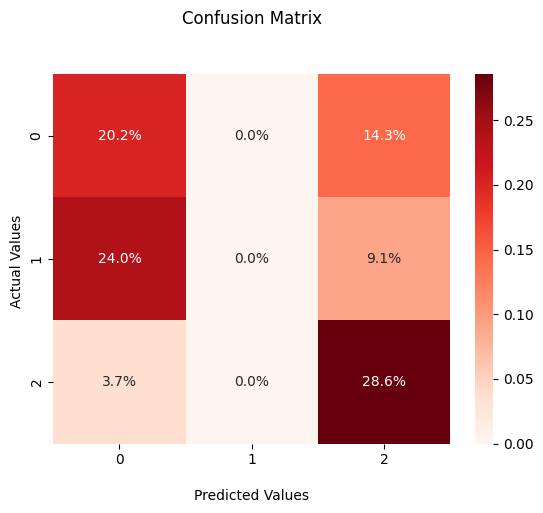

Subject 18
8/8 [==============================] - 0s 42ms/step - loss: 2.4771 - accuracy: 0.3711
Score : loss of 2.477077007293701; accuracy of 37.10895478725433%
29/29 [==============================] - 2s 16ms/step
F1 score:  0.2543367171040382
Precision:  0.732998523555993
Recall:  0.3710895361380798


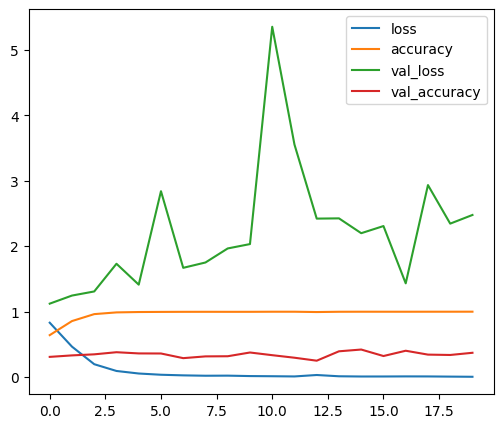

[[ 47   0 271]
 [  6   3 303]
 [  3   0 294]]


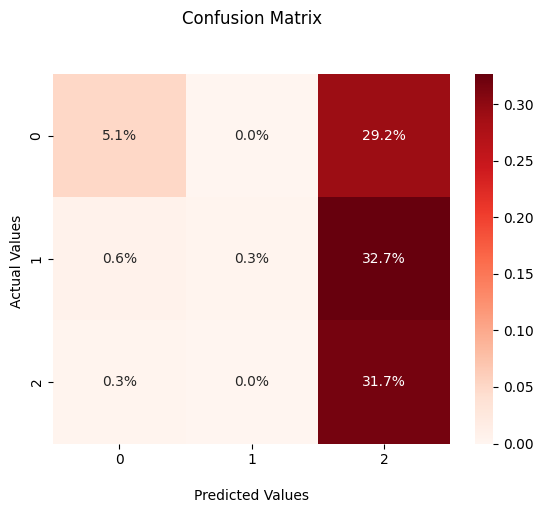

Subject 19
8/8 [==============================] - 0s 40ms/step - loss: 3.0358 - accuracy: 0.3496
Score : loss of 3.0358431339263916; accuracy of 34.95575189590454%
29/29 [==============================] - 2s 16ms/step
F1 score:  0.3063052712735736
Precision:  0.27352912544724806
Recall:  0.3495575221238938


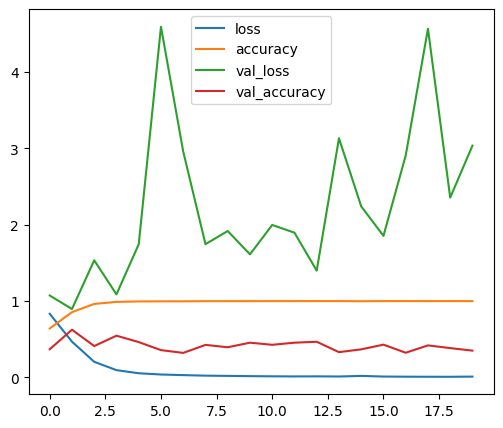

[[164  61  82]
 [118 151  35]
 [119 173   1]]


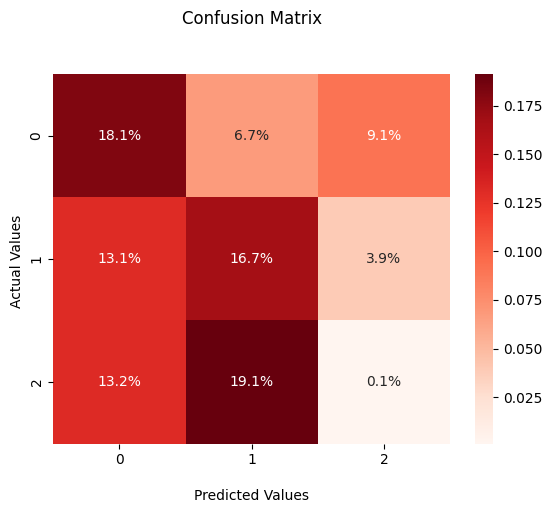

Subject 20
8/8 [==============================] - 0s 40ms/step - loss: 9.6046 - accuracy: 0.3254
Score : loss of 9.604572296142578; accuracy of 32.53796100616455%
29/29 [==============================] - 2s 16ms/step
F1 score:  0.15976085575014823
Precision:  0.10587189030731081
Recall:  0.32537960954446854


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


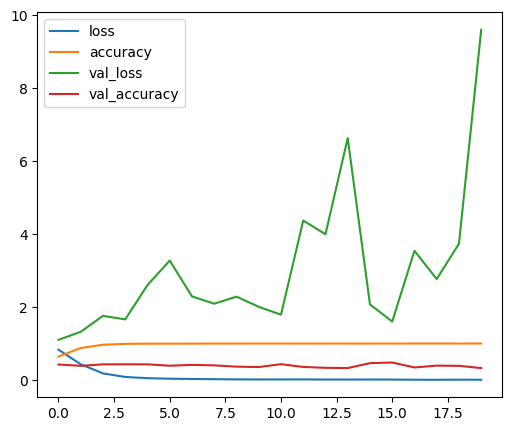

[[  0 316   0]
 [  0 300   0]
 [  0 306   0]]


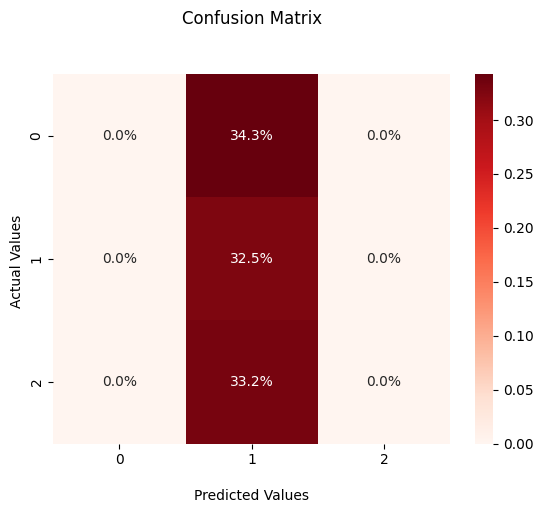

Subject 21
8/8 [==============================] - 0s 39ms/step - loss: 3.9297 - accuracy: 0.3591
Score : loss of 3.9296627044677734; accuracy of 35.91160178184509%
29/29 [==============================] - 3s 17ms/step
F1 score:  0.22653265315278562
Precision:  0.5800460703748059
Recall:  0.35911602209944754


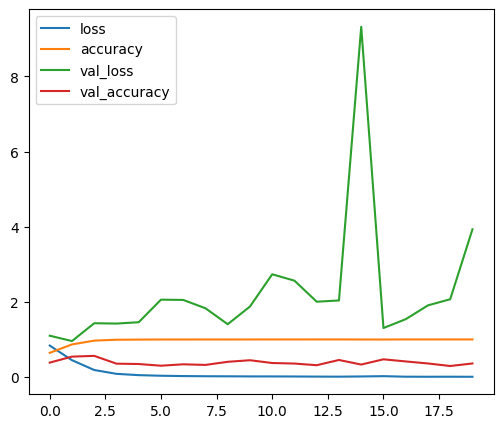

[[299   0  10]
 [273   4  25]
 [272   0  22]]


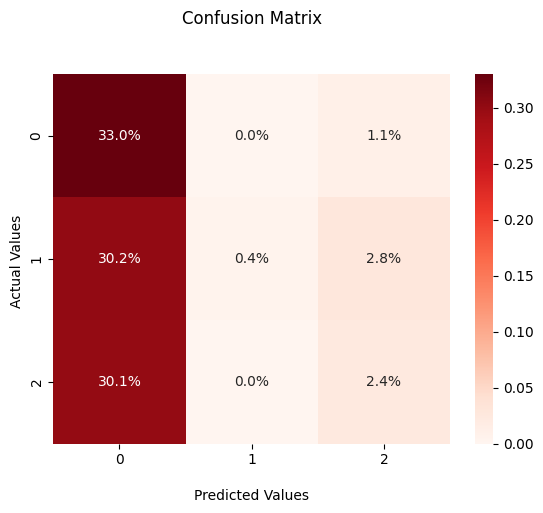

In [ ]:
for sub in range(len(all_data)):
    print('Subject',sub)
    train_data = {}
    
    train_data["acc_x"] = np.concatenate([all_data[i]["acc_x"] for i in range(len(all_data)) if i != sub])
    train_data["acc_y"] = np.concatenate([all_data[i]["acc_y"] for i in range(len(all_data)) if i != sub])
    train_data["acc_z"] = np.concatenate([all_data[i]["acc_z"] for i in range(len(all_data)) if i != sub])

    train_data["eda"] = np.concatenate([all_data[i]["eda"] for i in range(len(all_data)) if i != sub])
    train_data["temp"] = np.concatenate([all_data[i]["temp"] for i in range(len(all_data)) if i != sub])
    train_data["bvp"] = np.concatenate([all_data[i]["bvp"] for i in range(len(all_data)) if i != sub])

    train_data["label"] = np.concatenate([all_data[i]["label"] for i in range(len(all_data)) if i != sub])
    #print('TRAIN SHAPE',train_data['eda'].shape)
    test_data = all_data[sub]
    #print('TEST SHAPE',test_data['eda'].shape)
    cm_w_o_ft, acc_w_o_ft, loss_w_o_ft, f1_w_o_ft, prec_w_o_ft, rec_w_o_ft = ResNet(train_data, test_data)

**Average accuracy and F1 score (no ft)**

In [3]:
print(acc_w_o_ft)

[49.18566644191742, 34.23035442829132, 43.72294247150421, 33.33333432674408, 27.89934277534485, 32.639649510383606, 33.72972905635834, 31.84782564640045, 40.02229571342468, 34.535518288612366, 31.074035167694092, 32.681867480278015, 37.00440526008606, 28.431373834609985, 33.65180492401123, 32.48898684978485, 35.74514091014862, 48.71520400047302, 37.10895478725433, 34.95575189590454, 32.53796100616455, 35.91160178184509]


In [4]:
print(np.mean(acc_w_o_ft))
print(np.mean(f1_w_o_ft))

35.52062484351071
0.2440387204549544


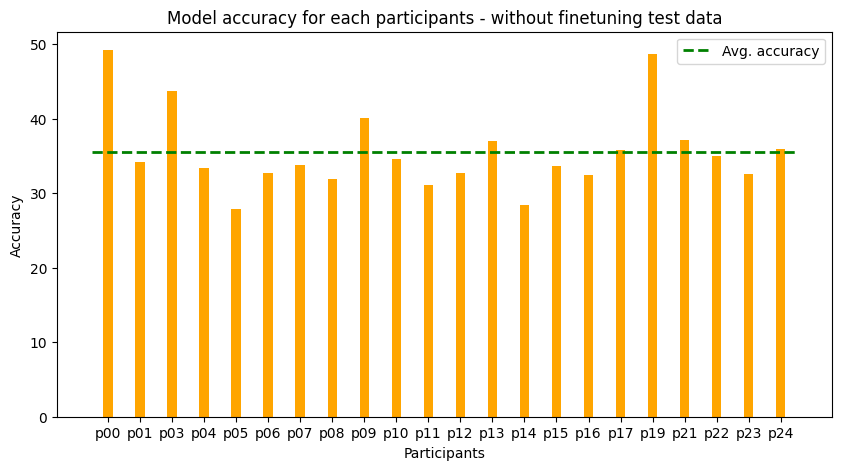

In [5]:
fig = plt.figure(figsize = (10, 5))
 
plt.bar(participants, acc_w_o_ft, color ='orange',width = 0.3)
 
plt.xlabel("Participants")
plt.ylabel("Accuracy")
plt.title("Model accuracy for each participants - without finetuning test data")

plt.hlines(y=(np.mean(acc_w_o_ft)), xmin=-0.5, xmax=(len(acc_w_o_ft)-0.5), colors='green', linestyles='--', lw=2, label='Avg. accuracy')
plt.legend()

plt.show()

[[[3, 234, 76], [0, 257, 57], [13, 87, 194]], [[0, 309, 0], [0, 318, 0], [0, 302, 0]], [[135, 88, 89], [88, 92, 131], [23, 101, 177]], [[285, 0, 9], [306, 22, 0], [278, 21, 0]], [[225, 27, 43], [257, 16, 42], [273, 17, 14]], [[5, 288, 5], [16, 284, 14], [26, 266, 9]], [[8, 296, 0], [11, 304, 0], [0, 306, 0]], [[15, 0, 294], [28, 2, 283], [13, 9, 276]], [[44, 43, 215], [31, 148, 130], [26, 92, 168]], [[0, 302, 0], [0, 316, 2], [22, 273, 0]], [[223, 41, 58], [213, 28, 85], [246, 18, 47]], [[6, 1, 292], [7, 0, 314], [3, 3, 295]], [[292, 0, 0], [293, 13, 0], [261, 18, 31]], [[62, 0, 237], [30, 0, 293], [97, 0, 199]], [[0, 0, 302], [0, 0, 320], [0, 3, 317]], [[0, 0, 313], [0, 0, 299], [0, 1, 295]], [[133, 0, 184], [145, 0, 167], [99, 0, 198]], [[189, 0, 134], [224, 0, 85], [35, 0, 267]], [[47, 0, 271], [6, 3, 303], [3, 0, 294]], [[164, 61, 82], [118, 151, 35], [119, 173, 1]], [[0, 316, 0], [0, 300, 0], [0, 306, 0]], [[299, 0, 10], [273, 4, 25], [272, 0, 22]]]
[[97.04545454545455, 91.1818181

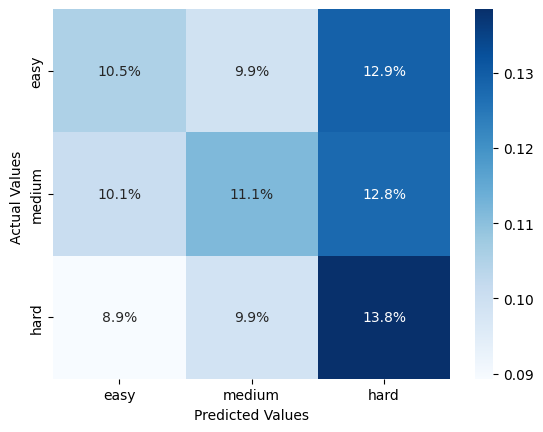

In [ ]:
# cm_w_o_ft seperated by commas

print(cm_w_o_ft)

ele_00, ele_01, ele_02 = [], [], []
ele_10, ele_11, ele_12 = [], [], []
ele_20, ele_21, ele_22 = [], [], []

for i in range(len(cm_w_o_ft)):
  ele_00.append(cm_w_o_ft[i][0][0])
  ele_01.append(cm_w_o_ft[i][0][1])
  ele_02.append(cm_w_o_ft[i][0][2])
  ele_10.append(cm_w_o_ft[i][1][0])
  ele_11.append(cm_w_o_ft[i][1][1])
  ele_12.append(cm_w_o_ft[i][1][2])
  ele_20.append(cm_w_o_ft[i][2][0])
  ele_21.append(cm_w_o_ft[i][2][1])
  ele_22.append(cm_w_o_ft[i][2][2])

cm = [[ np.mean(ele_00), np.mean(ele_01), np.mean(ele_02)],
      [ np.mean(ele_10), np.mean(ele_11), np.mean(ele_12)],
      [ np.mean(ele_20), np.mean(ele_21), np.mean(ele_22)]]

print(cm)

ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.1%', cmap='Blues')
ax.figsize=(5,5)
#ax.set_title('\nConfusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')
    
ax.xaxis.set_ticklabels(['easy','medium','hard'])
ax.yaxis.set_ticklabels(['easy','medium','hard'])

#plt.savefig('resnet_cm_wo.pdf')

plt.show()

# **Finetuning 5% of test data (LOSO)**

SUBJECT 0
7/7 [==============================] - 0s 43ms/step - loss: 1.2379 - accuracy: 0.6327
Score : loss of 1.2378712892532349; accuracy of 63.27230930328369%
28/28 [==============================] - 3s 19ms/step
F1 score:  0.6175728282062666
Precision:  0.7960029573545564
Recall:  0.6327231121281465


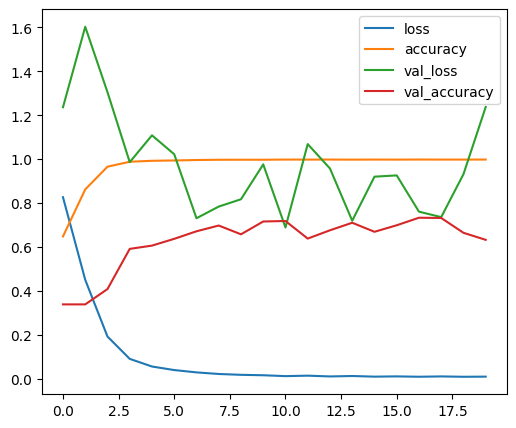

[[159 135   2]
 [  0 300   0]
 [ 12 172  94]]


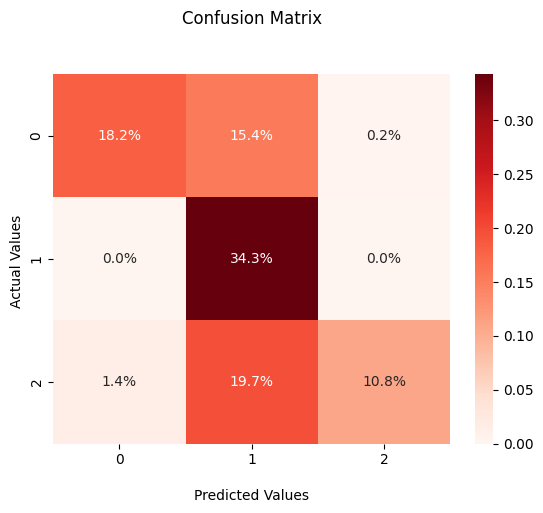

SUBJECT 1
7/7 [==============================] - 0s 43ms/step - loss: 0.9373 - accuracy: 0.7710
Score : loss of 0.937282145023346; accuracy of 77.09750533103943%
28/28 [==============================] - 2s 18ms/step
F1 score:  0.7690845529566935
Precision:  0.8191076566562597
Recall:  0.7698412698412699


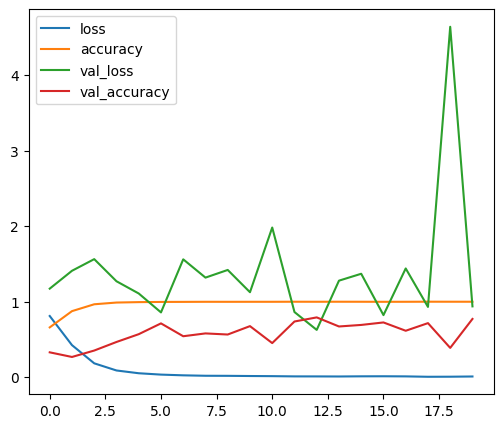

[[174  17 102]
 [ 12 227  60]
 [  0  12 278]]


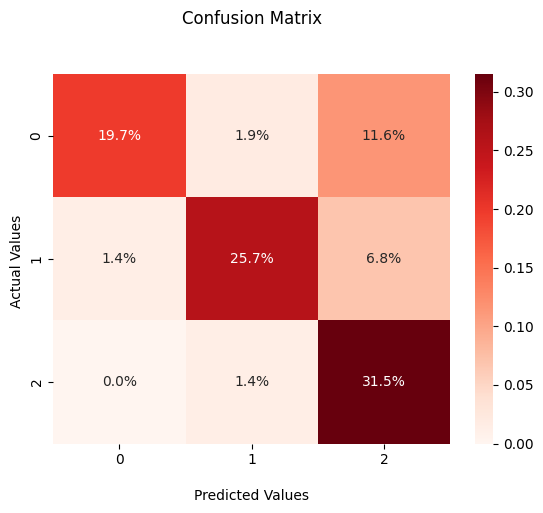

SUBJECT 2
7/7 [==============================] - 0s 44ms/step - loss: 0.4566 - accuracy: 0.8278
Score : loss of 0.4566185772418976; accuracy of 82.78221487998962%
28/28 [==============================] - 2s 19ms/step
F1 score:  0.827402105230197
Precision:  0.854081244624393
Recall:  0.8278221208665907


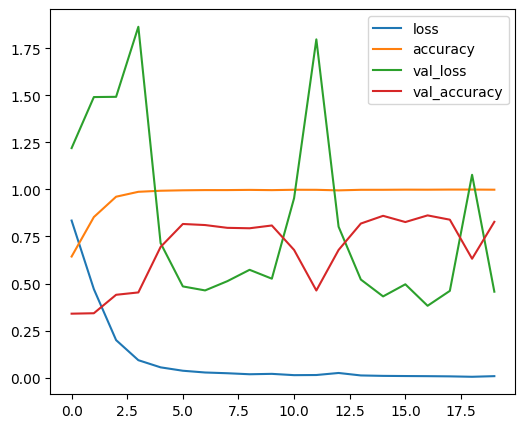

[[246  52   0]
 [  5 280   6]
 [ 31  57 200]]


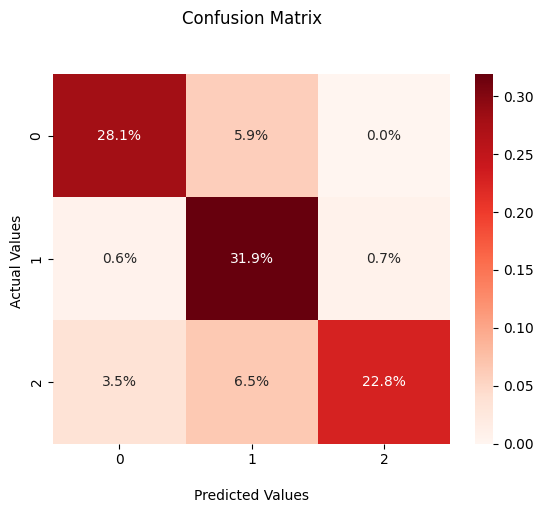

SUBJECT 3
7/7 [==============================] - 0s 43ms/step - loss: 0.8005 - accuracy: 0.7197
Score : loss of 0.8005415797233582; accuracy of 71.96796536445618%
28/28 [==============================] - 2s 17ms/step
F1 score:  0.7190101866892307
Precision:  0.7755099212917214
Recall:  0.7196796338672768


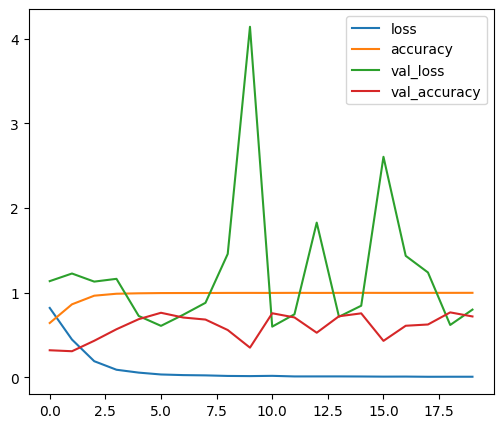

[[248  30   0]
 [ 85 224   3]
 [ 80  47 157]]


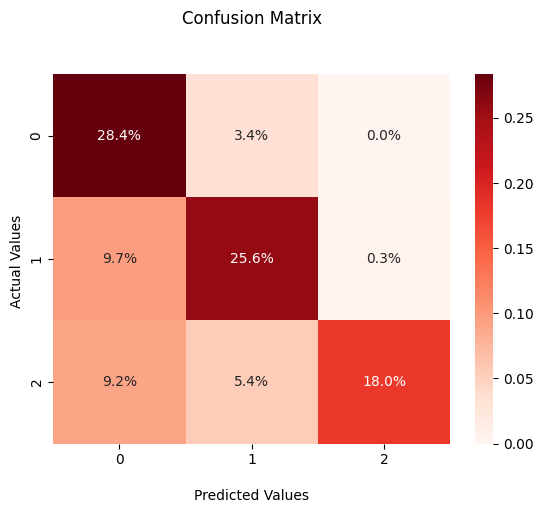

SUBJECT 4
7/7 [==============================] - 0s 43ms/step - loss: 1.4937 - accuracy: 0.5749
Score : loss of 1.4937236309051514; accuracy of 57.48847723007202%
28/28 [==============================] - 2s 18ms/step
F1 score:  0.5227965461950124
Precision:  0.7114306683452684
Recall:  0.5748847926267281


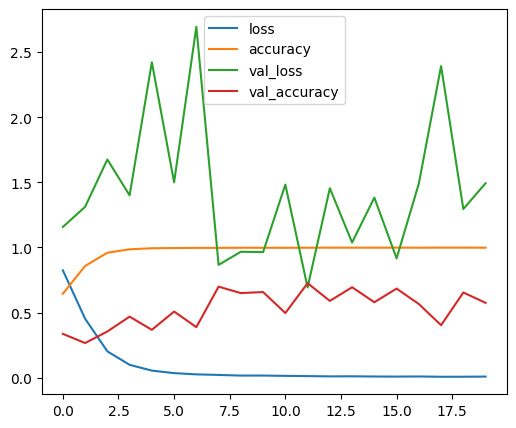

[[202   0  81]
 [ 85  48 164]
 [ 39   0 249]]


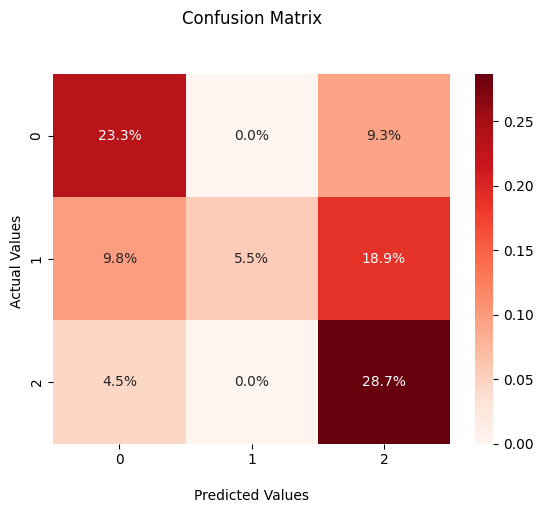

SUBJECT 5
7/7 [==============================] - 0s 43ms/step - loss: 1.9628 - accuracy: 0.5444
Score : loss of 1.9628312587738037; accuracy of 54.4405996799469%
28/28 [==============================] - 2s 18ms/step
F1 score:  0.5112069081130227
Precision:  0.6777825163180974
Recall:  0.544405997693195


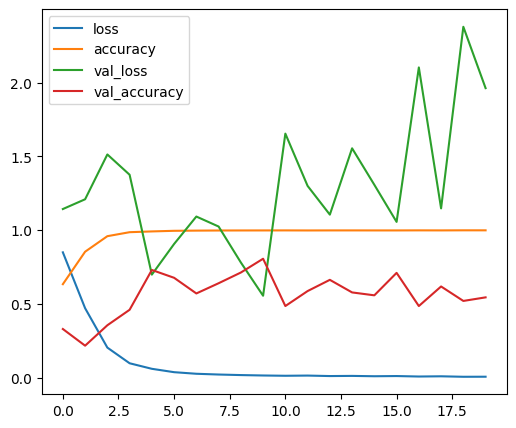

[[286   0   0]
 [214  77   4]
 [129  48 109]]


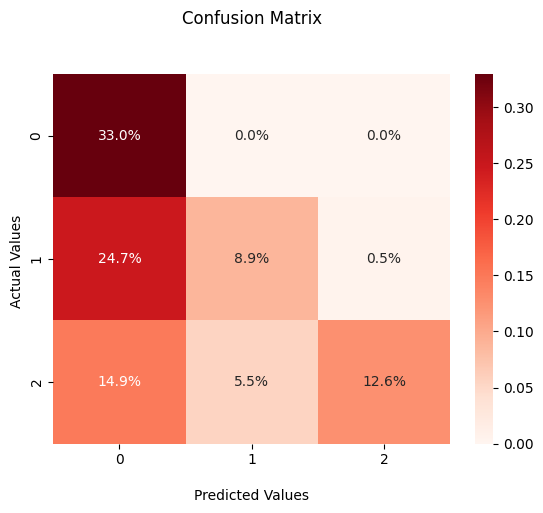

SUBJECT 6
7/7 [==============================] - 0s 42ms/step - loss: 0.8913 - accuracy: 0.7141
Score : loss of 0.8912850022315979; accuracy of 71.4123010635376%
28/28 [==============================] - 3s 18ms/step
F1 score:  0.713916688395092
Precision:  0.7269980239447467
Recall:  0.714123006833713


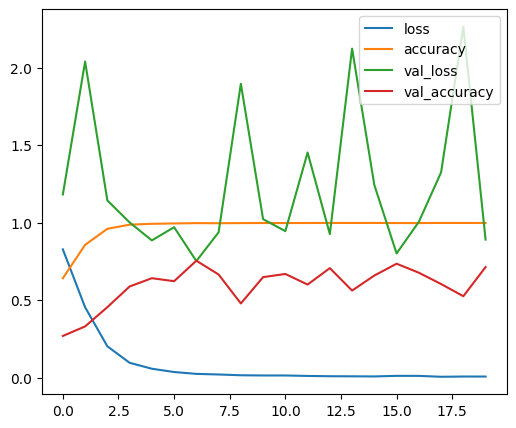

[[166 114  11]
 [ 34 241  20]
 [ 48  24 220]]


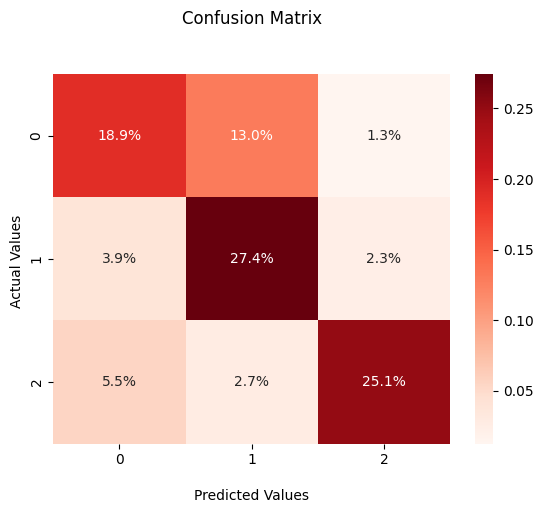

SUBJECT 7
7/7 [==============================] - 0s 43ms/step - loss: 1.6489 - accuracy: 0.6076
Score : loss of 1.6489030122756958; accuracy of 60.75515151023865%
28/28 [==============================] - 2s 17ms/step
F1 score:  0.5600618567221191
Precision:  0.6510447416310944
Recall:  0.6075514874141876


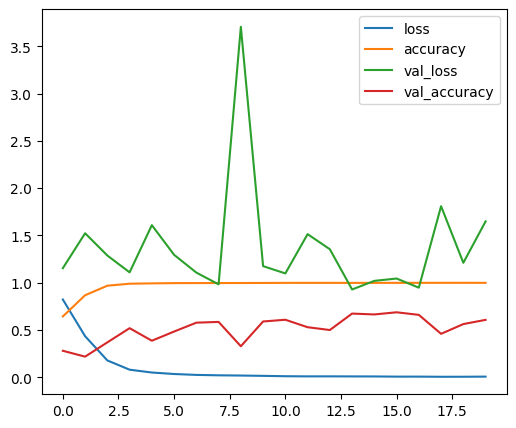

[[252  37  11]
 [ 55 230   6]
 [ 55 179  49]]


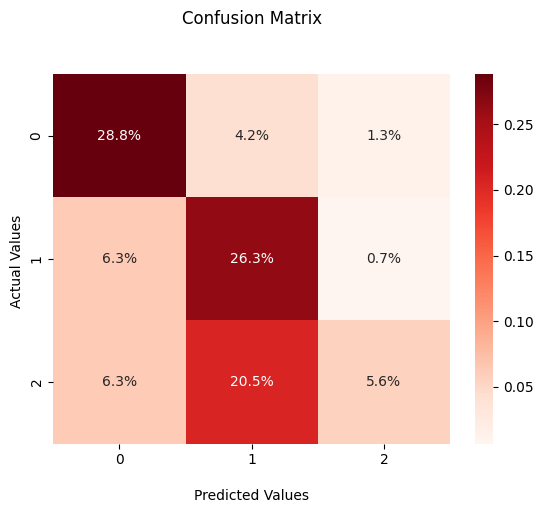

SUBJECT 8
7/7 [==============================] - 0s 42ms/step - loss: 2.9912 - accuracy: 0.4214
Score : loss of 2.9912450313568115; accuracy of 42.136150598526%
27/27 [==============================] - 2s 20ms/step
F1 score:  0.36103733752638345
Precision:  0.6793095086642708
Recall:  0.4213615023474178


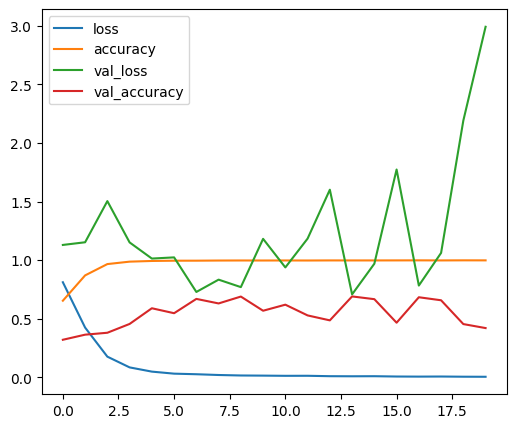

[[ 10   3 273]
 [  0 133 160]
 [  0  57 216]]


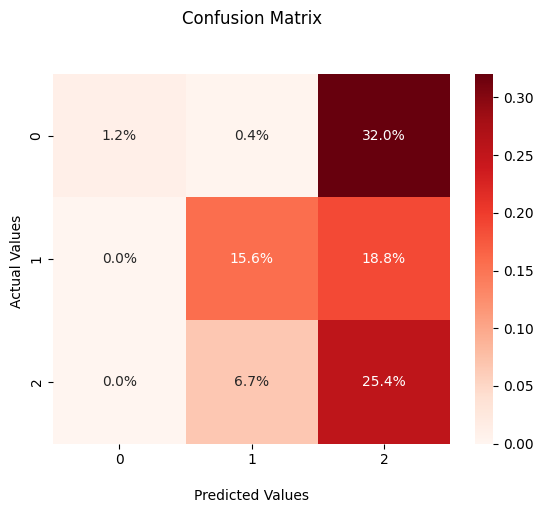

SUBJECT 9
7/7 [==============================] - 0s 41ms/step - loss: 3.5625 - accuracy: 0.4545
Score : loss of 3.562485694885254; accuracy of 45.45454680919647%
28/28 [==============================] - 2s 18ms/step
F1 score:  0.3710071019201696
Precision:  0.7855895704807356
Recall:  0.45454545454545453


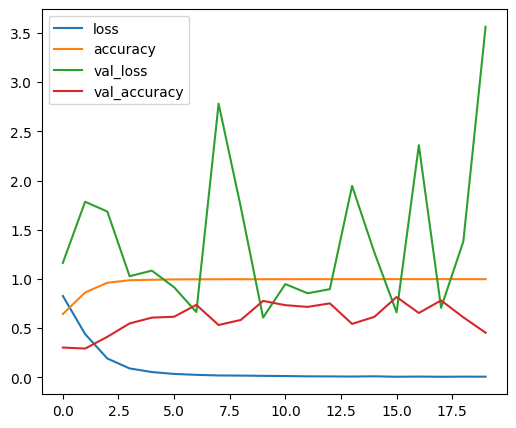

[[ 63 224   0]
 [  0 307   0]
 [  0 250  25]]


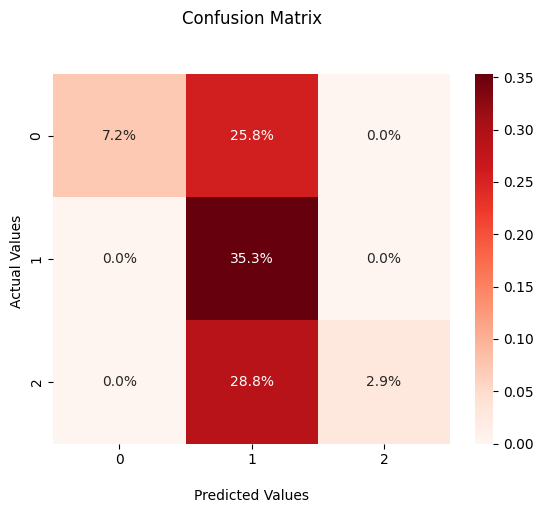

SUBJECT 10
8/8 [==============================] - 0s 39ms/step - loss: 1.2242 - accuracy: 0.7014
Score : loss of 1.2241681814193726; accuracy of 70.14269828796387%
29/29 [==============================] - 2s 16ms/step
F1 score:  0.6997871654674346
Precision:  0.7271047138551551
Recall:  0.7014270032930845


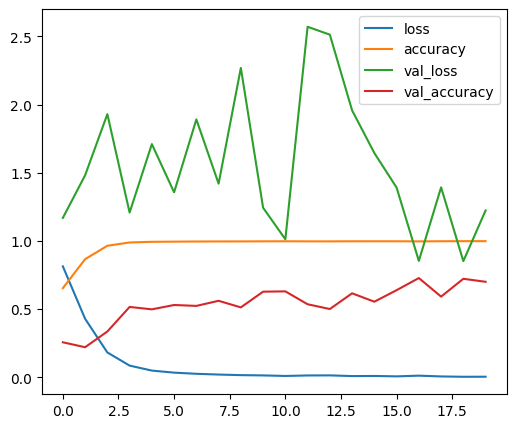

[[216  34  60]
 [ 25 170 109]
 [ 31  13 253]]


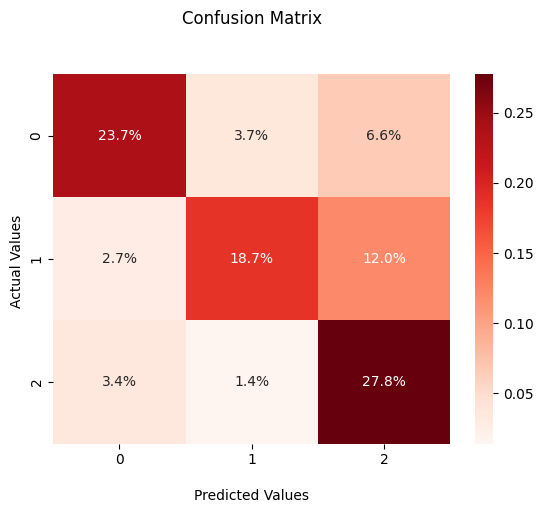

SUBJECT 11
7/7 [==============================] - 0s 42ms/step - loss: 2.4051 - accuracy: 0.5458
Score : loss of 2.405123472213745; accuracy of 54.576659202575684%
28/28 [==============================] - 2s 16ms/step
F1 score:  0.43786040457403913
Precision:  0.37229572056304283
Recall:  0.545766590389016


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


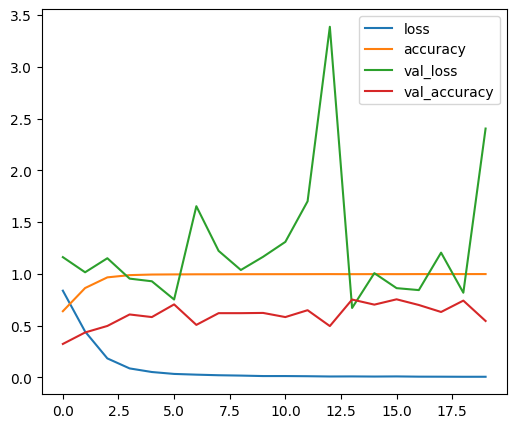

[[266  17   0]
 [ 95 211   0]
 [151 134   0]]


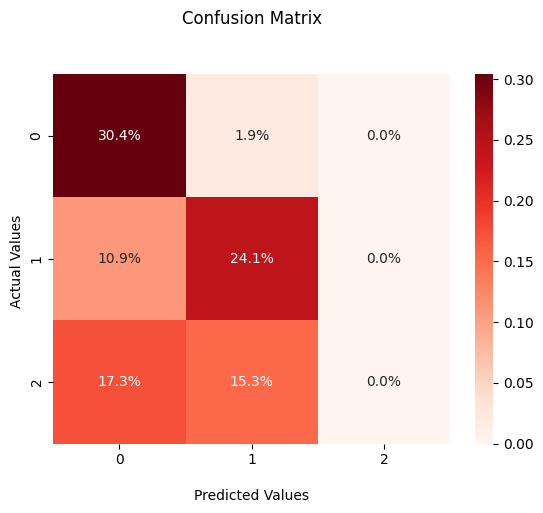

SUBJECT 12
7/7 [==============================] - 0s 42ms/step - loss: 0.6405 - accuracy: 0.7970
Score : loss of 0.6405494213104248; accuracy of 79.69837784767151%
27/27 [==============================] - 2s 18ms/step
F1 score:  0.793539538462807
Precision:  0.8113229135078261
Recall:  0.796983758700696


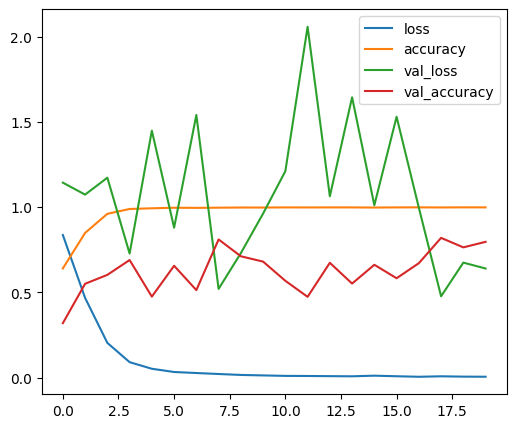

[[248  17   8]
 [ 31 248  12]
 [ 42  65 191]]


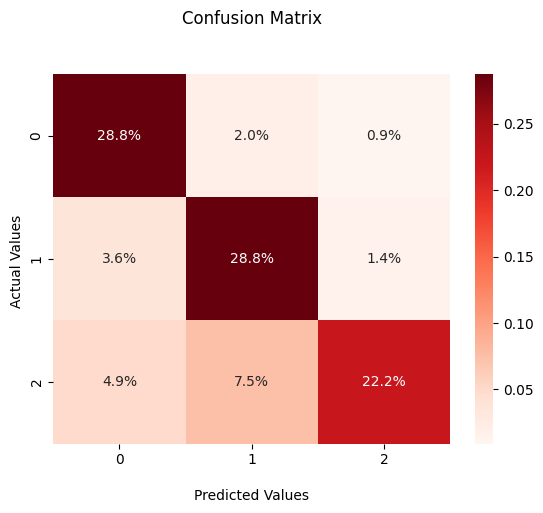

SUBJECT 13
7/7 [==============================] - 0s 42ms/step - loss: 4.9365 - accuracy: 0.3933
Score : loss of 4.93654203414917; accuracy of 39.33486342430115%
28/28 [==============================] - 2s 18ms/step
F1 score:  0.26860232304459153
Precision:  0.6602494218781673
Recall:  0.3922018348623853


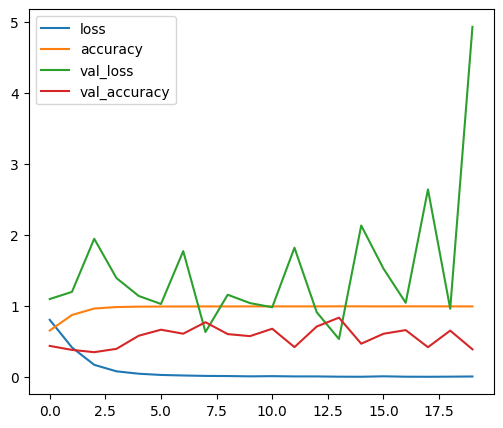

[[  8 279   1]
 [  0 302   0]
 [  4 246  32]]


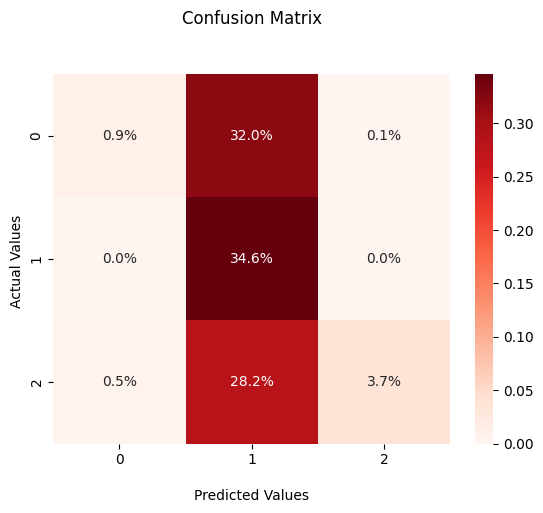

SUBJECT 14
7/7 [==============================] - 0s 43ms/step - loss: 1.2382 - accuracy: 0.5895
Score : loss of 1.238168716430664; accuracy of 58.94854664802551%
28/28 [==============================] - 2s 16ms/step
F1 score:  0.5268337048448769
Precision:  0.6942968464183232
Recall:  0.5894854586129754


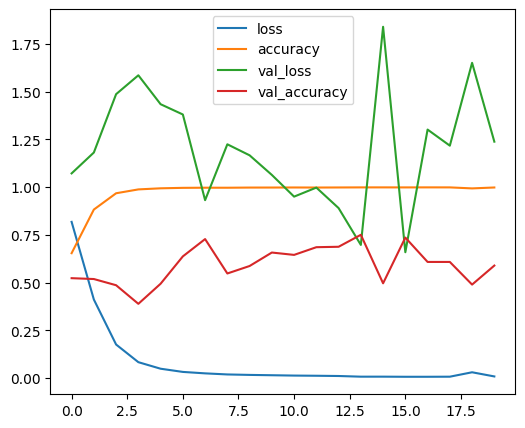

[[271  15   0]
 [ 85 211   4]
 [141 122  45]]


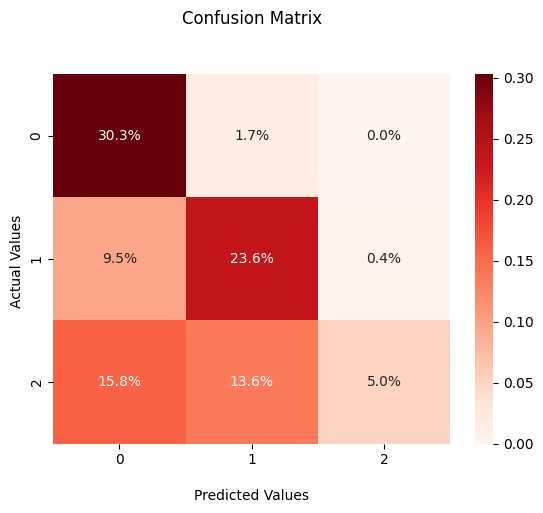

SUBJECT 15
7/7 [==============================] - 0s 42ms/step - loss: 0.6269 - accuracy: 0.7645
Score : loss of 0.6269157528877258; accuracy of 76.450115442276%
27/27 [==============================] - 2s 16ms/step
F1 score:  0.7531823454967307
Precision:  0.7913275309893182
Recall:  0.7633410672853829


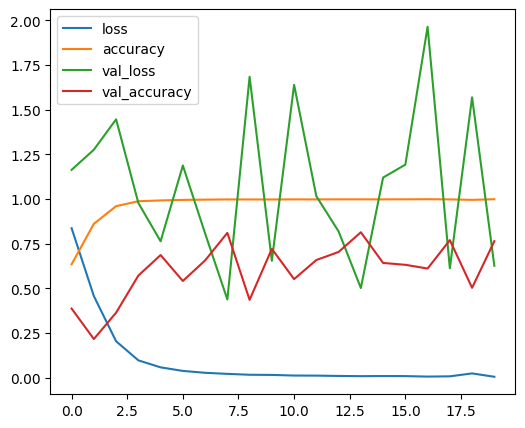

[[258   6  34]
 [ 86 148  53]
 [ 18   7 252]]


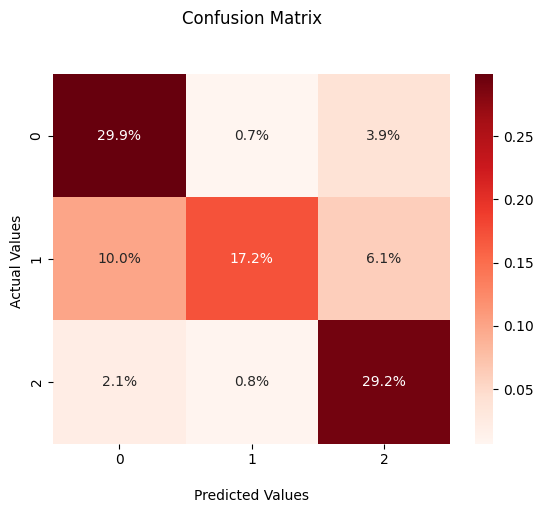

SUBJECT 16
7/7 [==============================] - 0s 42ms/step - loss: 6.2241 - accuracy: 0.3345
Score : loss of 6.2241315841674805; accuracy of 33.44709873199463%
28/28 [==============================] - 2s 16ms/step
F1 score:  0.19542832074953598
Precision:  0.5090637756809209
Recall:  0.33447098976109213


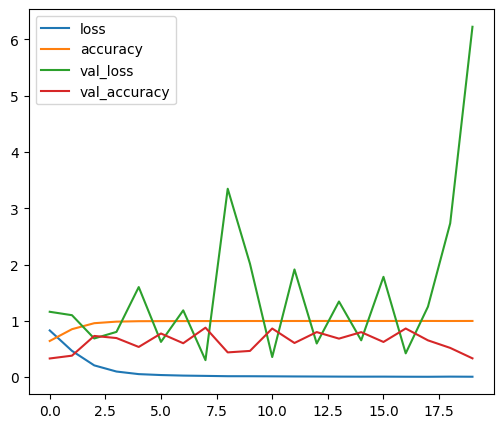

[[ 12 289   0]
 [  0 279  14]
 [  0 282   3]]


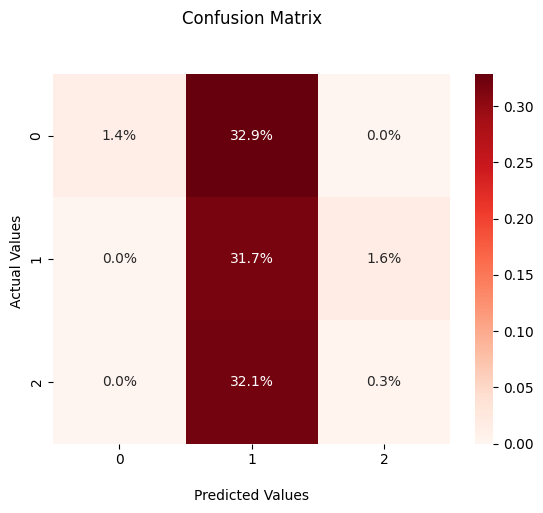

SUBJECT 17
7/7 [==============================] - 0s 43ms/step - loss: 0.8138 - accuracy: 0.7148
Score : loss of 0.8138108253479004; accuracy of 71.47688865661621%
28/28 [==============================] - 2s 19ms/step
F1 score:  0.6857326275622303
Precision:  0.7826364813433204
Recall:  0.7147688838782412


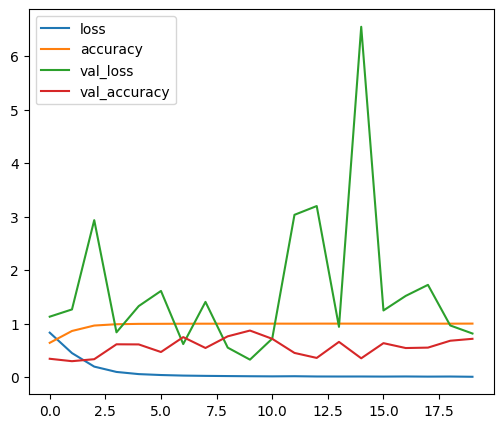

[[263   1  39]
 [ 89 102 107]
 [ 16   1 269]]


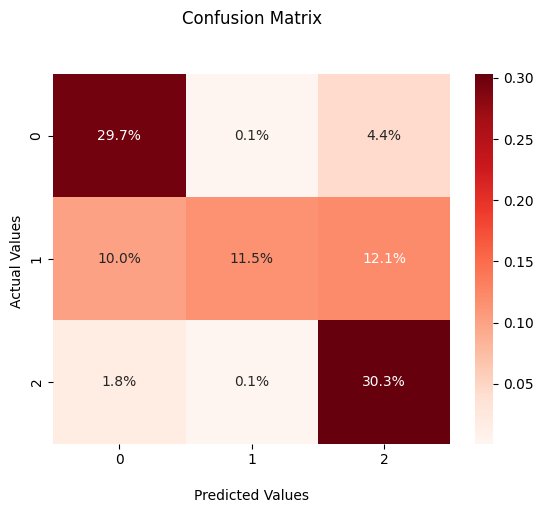

SUBJECT 18
7/7 [==============================] - 0s 43ms/step - loss: 2.3080 - accuracy: 0.5227
Score : loss of 2.3079779148101807; accuracy of 52.272725105285645%
28/28 [==============================] - 2s 18ms/step
F1 score:  0.43856538899897923
Precision:  0.7147857751542435
Recall:  0.5215909090909091


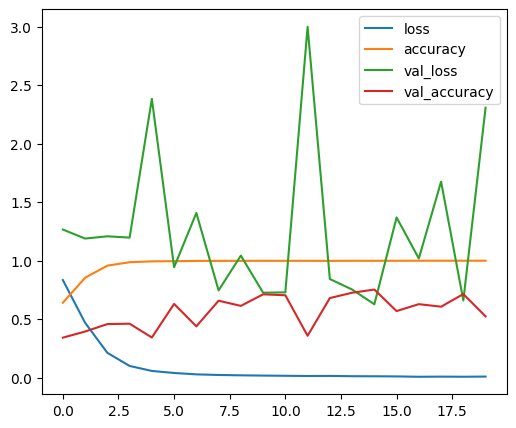

[[ 18 214  68]
 [  0 292   1]
 [  0 138 149]]


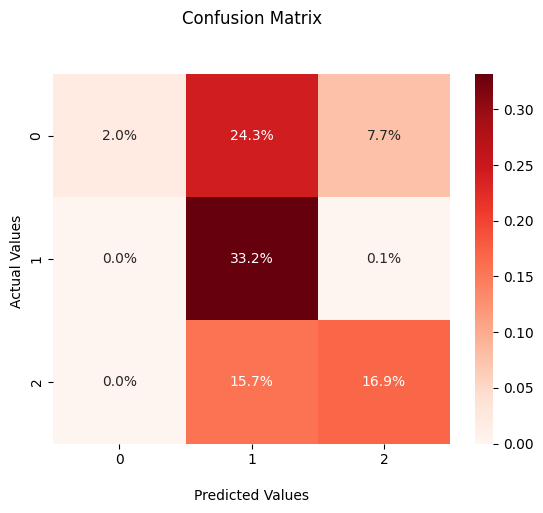

SUBJECT 19
7/7 [==============================] - 0s 43ms/step - loss: 1.2438 - accuracy: 0.5828
Score : loss of 1.2438346147537231; accuracy of 58.27505588531494%
27/27 [==============================] - 2s 18ms/step
F1 score:  0.5728818247274446
Precision:  0.7072730690252593
Recall:  0.5827505827505828


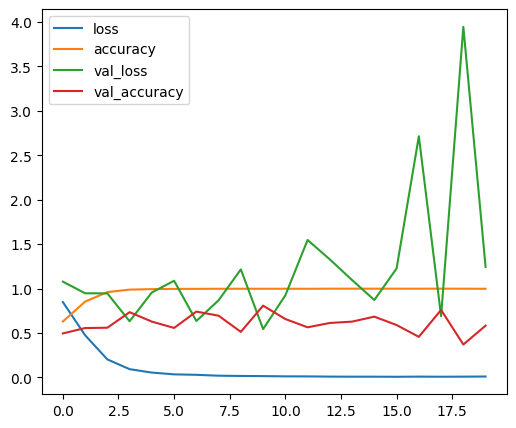

[[118 174   0]
 [ 24 264   1]
 [ 33 126 118]]


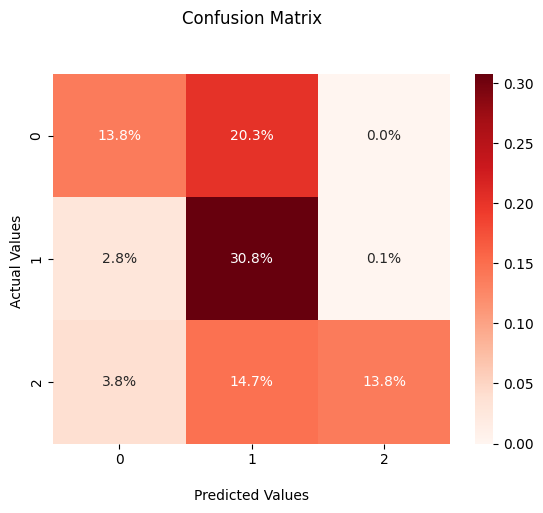

SUBJECT 20
7/7 [==============================] - 0s 43ms/step - loss: 4.5273 - accuracy: 0.4091
Score : loss of 4.527291297912598; accuracy of 40.91428518295288%
28/28 [==============================] - 2s 18ms/step
F1 score:  0.2978706753620185
Precision:  0.7745882102943932
Recall:  0.40914285714285714


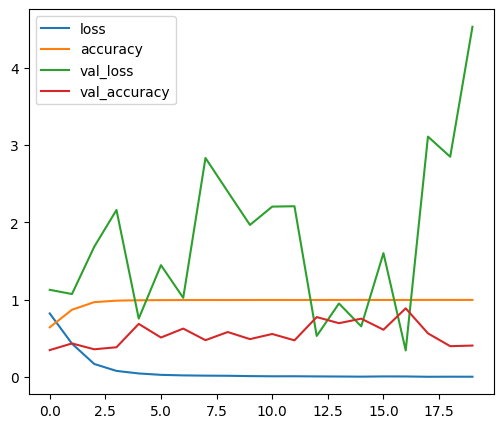

[[296   0   0]
 [284   1   2]
 [231   0  61]]


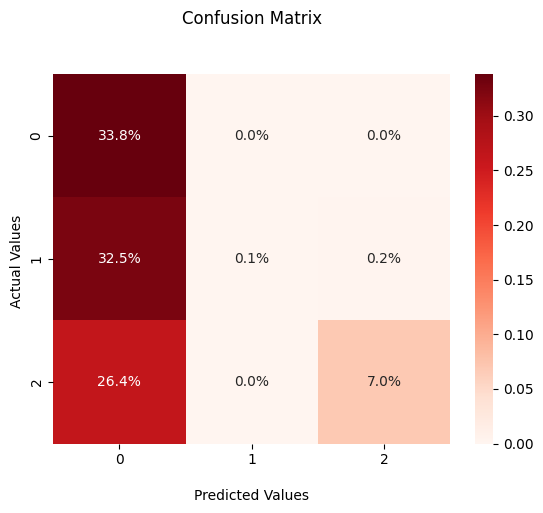

SUBJECT 21
7/7 [==============================] - 0s 42ms/step - loss: 1.3470 - accuracy: 0.6007
Score : loss of 1.3470046520233154; accuracy of 60.069847106933594%
27/27 [==============================] - 2s 19ms/step
F1 score:  0.5685661562526731
Precision:  0.6898607439785357
Recall:  0.6030267753201397


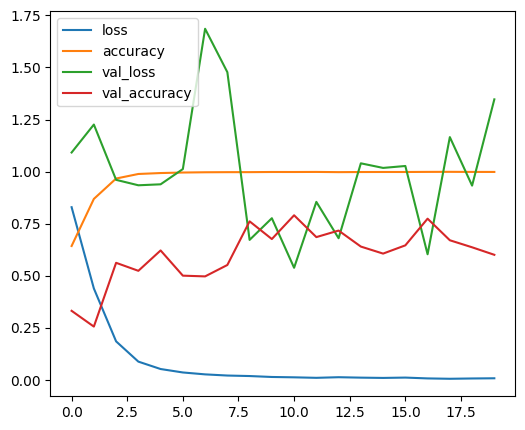

[[217  69   9]
 [ 46 241   0]
 [ 44 173  60]]


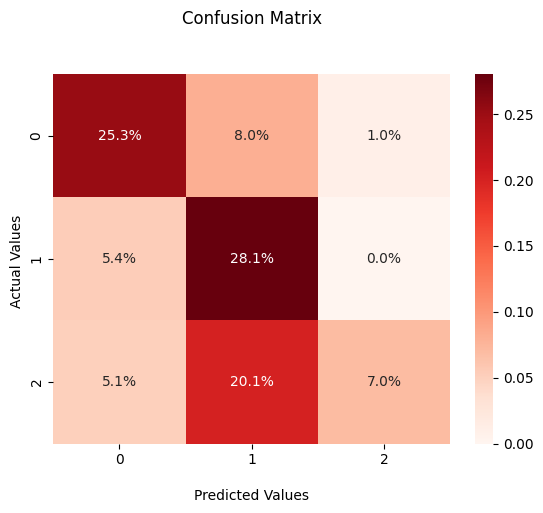

In [ ]:
from sklearn.model_selection import train_test_split


for sub in range(len(all_data)):
    print('SUBJECT',sub)

    test_data_all = all_data[sub]

    X_train_split, X_test_split, y_train_split, y_test_split = {}, {}, {}, {}

    for feature in all_features: 

      X_train_split[feature], X_test_split[feature], y_train_split[feature], y_test_split[feature] = train_test_split(
         test_data_all[feature], test_data_all['label'], test_size=0.05, random_state=3456789
         )

    
    train_data, train_data_all = {}, {}
    test_data = {}


    train_data_all["acc_x"] = np.concatenate([all_data[i]["acc_x"] for i in range(len(all_data)) if i != sub])
    train_data_all["acc_y"] = np.concatenate([all_data[i]["acc_y"] for i in range(len(all_data)) if i != sub])
    train_data_all["acc_z"] = np.concatenate([all_data[i]["acc_z"] for i in range(len(all_data)) if i != sub])
    train_data_all["eda"] = np.concatenate([all_data[i]["eda"] for i in range(len(all_data)) if i != sub])
    train_data_all["temp"] = np.concatenate([all_data[i]["temp"] for i in range(len(all_data)) if i != sub])
    train_data_all["bvp"] = np.concatenate([all_data[i]["bvp"] for i in range(len(all_data)) if i != sub])


    for feature in all_features:
      train_data[feature] = np.concatenate((train_data_all[feature], X_test_split[feature]), axis=0)


    train_data_all["label"] = np.concatenate([all_data[i]["label"] for i in range(len(all_data)) if i != sub])

    train_data["label"] = np.concatenate((train_data_all["label"], y_test_split['eda']), axis=0)

    for feature in all_features:
      test_data[feature] = X_train_split[feature]

    test_data['label'] = y_train_split['eda']

    cm_w_ft_5, acc_w_ft_5, loss_w_ft_5, f1_w_ft_5, prec_w_ft_5, rec_w_ft_5 = ResNet(train_data, test_data)

**Average accuracy and F1 score (5% ft)**

In [7]:
print(acc_w_ft_5)

[63.27230930328369, 77.09750533103943, 82.78221487998962, 71.96796536445618, 57.48847723007202, 54.4405996799469, 71.4123010635376, 60.75515151023865, 42.136150598526, 45.45454680919647, 70.14269828796387, 54.576659202575684, 79.69837784767151, 39.33486342430115, 58.94854664802551, 76.450115442276, 33.44709873199463, 71.47688865661621, 52.272725105285645, 58.27505588531494, 40.91428518295288, 60.069847106933594]


In [8]:
print(np.mean(acc_w_ft_5))
print(np.mean(f1_w_ft_5))

60.10974469509992
0.5550884812498885


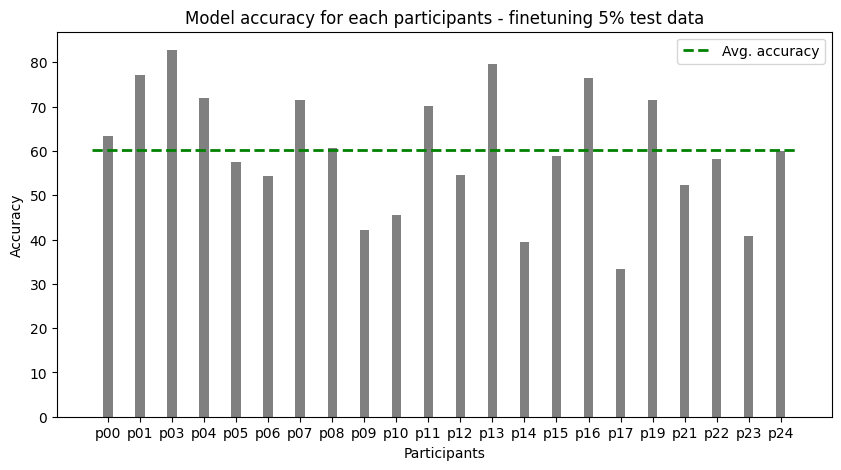

In [9]:
fig = plt.figure(figsize = (10, 5))
 
plt.bar(participants, acc_w_ft_5, color ='grey',width = 0.3)
 
plt.xlabel("Participants")
plt.ylabel("Accuracy")
plt.title("Model accuracy for each participants - finetuning 5% test data")

plt.hlines(y=(np.mean(acc_w_ft_5)), xmin=-0.5, xmax=(len(acc_w_ft_5)-0.5), colors='green', linestyles='--', lw=2, label='Avg. accuracy')
plt.legend()

plt.show()

[[[159, 135, 2], [0, 300, 0], [12, 172, 94]], [[174, 17, 102], [12, 227, 60], [0, 12, 278]], [[246, 52, 0], [5, 280, 6], [31, 57, 200]], [[248, 30, 0], [85, 224, 3], [80, 47, 157]], [[202, 0, 81], [85, 48, 164], [39, 0, 249]], [[286, 0, 0], [214, 77, 4], [129, 48, 109]], [[166, 114, 11], [34, 241, 20], [48, 24, 220]], [[252, 37, 11], [55, 230, 6], [55, 179, 49]], [[10, 3, 273], [0, 133, 160], [0, 57, 216]], [[63, 224, 0], [0, 307, 0], [0, 250, 25]], [[216, 34, 60], [25, 170, 109], [31, 13, 253]], [[266, 17, 0], [95, 211, 0], [151, 134, 0]], [[248, 17, 8], [31, 248, 12], [42, 65, 191]], [[8, 279, 1], [0, 302, 0], [4, 246, 32]], [[271, 15, 0], [85, 211, 4], [141, 122, 45]], [[258, 6, 34], [86, 148, 53], [18, 7, 252]], [[12, 289, 0], [0, 279, 14], [0, 282, 3]], [[263, 1, 39], [89, 102, 107], [16, 1, 269]], [[18, 214, 68], [0, 292, 1], [0, 138, 149]], [[118, 174, 0], [24, 264, 1], [33, 126, 118]], [[296, 0, 0], [284, 1, 2], [231, 0, 61]], [[217, 69, 9], [46, 241, 0], [44, 173, 60]]]
[[181.

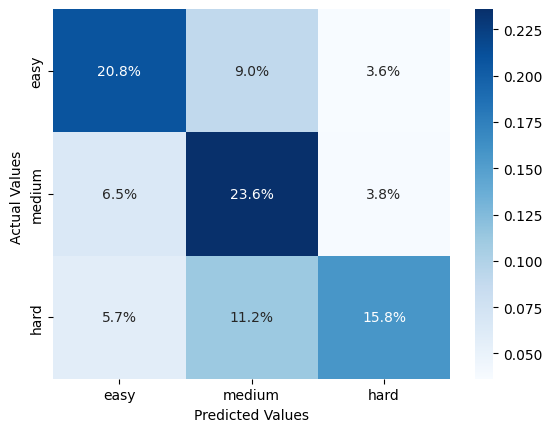

In [7]:
# cm_w_ft_5 seperated by commas

print(cm_w_ft_5)

ele_00, ele_01, ele_02 = [], [], []
ele_10, ele_11, ele_12 = [], [], []
ele_20, ele_21, ele_22 = [], [], []

for i in range(len(cm_w_ft_5)):
  ele_00.append(cm_w_ft_5[i][0][0])
  ele_01.append(cm_w_ft_5[i][0][1])
  ele_02.append(cm_w_ft_5[i][0][2])
  ele_10.append(cm_w_ft_5[i][1][0])
  ele_11.append(cm_w_ft_5[i][1][1])
  ele_12.append(cm_w_ft_5[i][1][2])
  ele_20.append(cm_w_ft_5[i][2][0])
  ele_21.append(cm_w_ft_5[i][2][1])
  ele_22.append(cm_w_ft_5[i][2][2])

cm = [[ np.mean(ele_00), np.mean(ele_01), np.mean(ele_02)],
      [ np.mean(ele_10), np.mean(ele_11), np.mean(ele_12)],
      [ np.mean(ele_20), np.mean(ele_21), np.mean(ele_22)]]

print(cm)

ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.1%', cmap='Blues')
ax.figsize=(5,5)
#ax.set_title('\nConfusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')
    
ax.xaxis.set_ticklabels(['easy','medium','hard'])
ax.yaxis.set_ticklabels(['easy','medium','hard'])

#plt.savefig('resnet_cm_ft_5.pdf')

plt.show()

# **Finetuning 10% of test data (LOSO)**

7/7 [==============================] - 0s 40ms/step - loss: 0.5006 - accuracy: 0.8140
Score : loss of 0.5005840063095093; accuracy of 81.40096664428711%
26/26 [==============================] - 2s 18ms/step
F1 score:  0.815389248359517
Precision:  0.8750216355968748
Recall:  0.8140096618357487


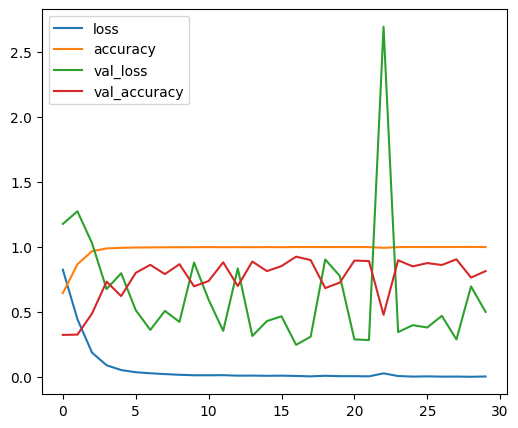

[[177 105   2]
 [  0 283   2]
 [  0  45 214]]


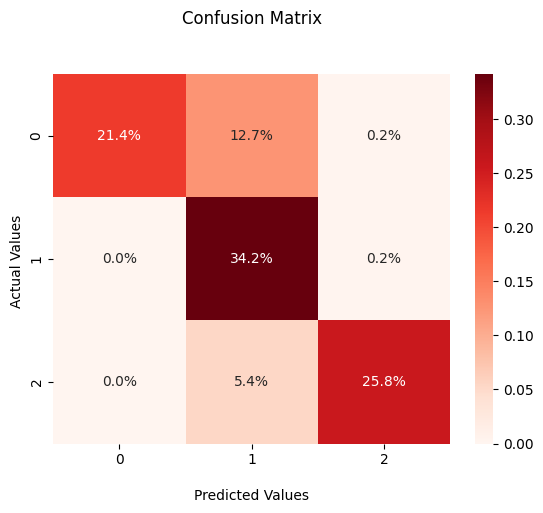

7/7 [==============================] - 0s 40ms/step - loss: 0.3115 - accuracy: 0.8888
Score : loss of 0.3114994764328003; accuracy of 88.87559771537781%
27/27 [==============================] - 2s 18ms/step
F1 score:  0.8890175325309703
Precision:  0.8938497084379762
Recall:  0.888755980861244


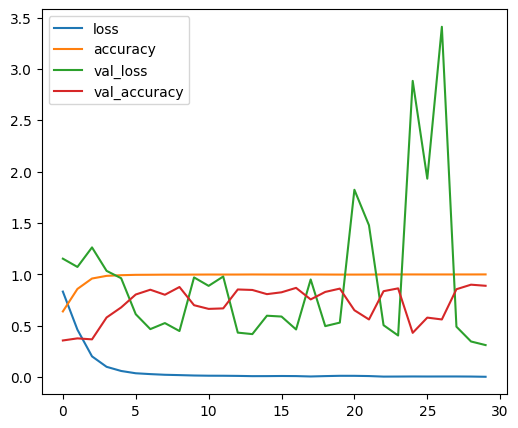

[[260  15   0]
 [ 21 249  15]
 [ 34   8 234]]


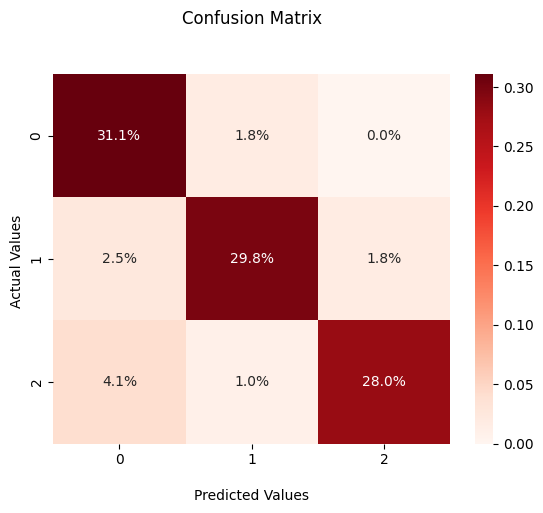

7/7 [==============================] - 0s 42ms/step - loss: 0.3409 - accuracy: 0.8664
Score : loss of 0.3408745527267456; accuracy of 86.64259910583496%
26/26 [==============================] - 2s 18ms/step
F1 score:  0.8666018460798945
Precision:  0.8968737680523947
Recall:  0.8664259927797834


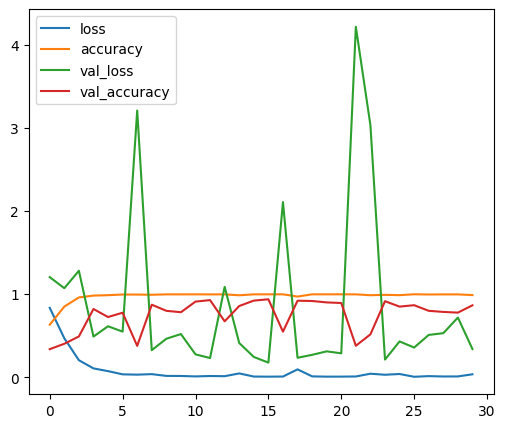

[[252   0  30]
 [ 10 194  70]
 [  0   1 274]]


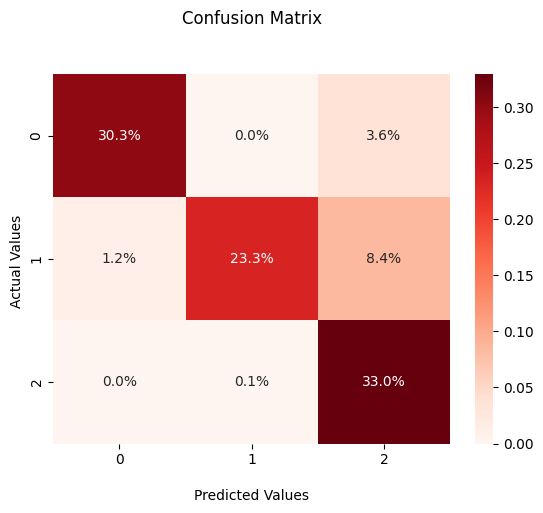

7/7 [==============================] - 0s 40ms/step - loss: 0.2368 - accuracy: 0.9010
Score : loss of 0.2368394285440445; accuracy of 90.09661674499512%
26/26 [==============================] - 2s 16ms/step
F1 score:  0.900671823099251
Precision:  0.9055800777947988
Recall:  0.9009661835748792


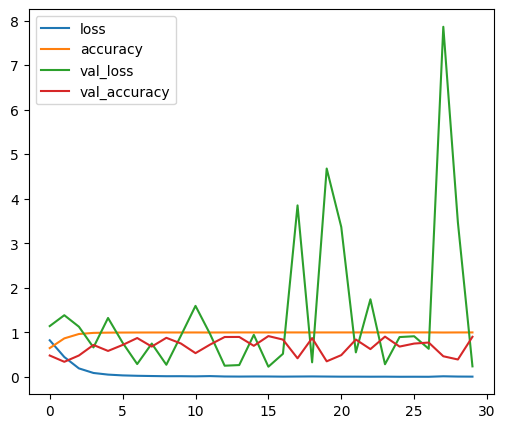

[[219  18  22]
 [  2 288   6]
 [  5  29 239]]


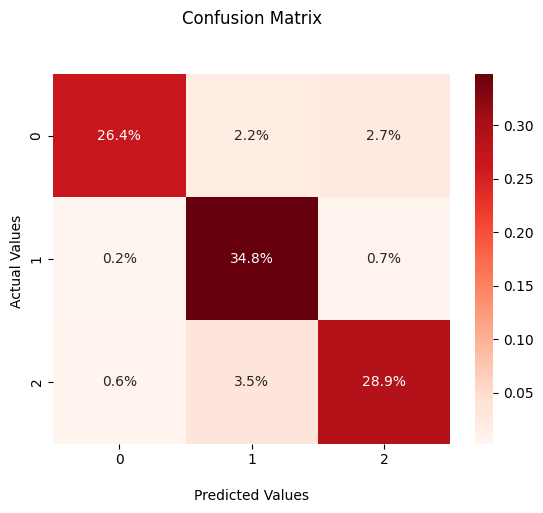

7/7 [==============================] - 0s 40ms/step - loss: 1.7831 - accuracy: 0.6314
Score : loss of 1.7831075191497803; accuracy of 63.13868761062622%
26/26 [==============================] - 2s 18ms/step
F1 score:  0.5658073340555092
Precision:  0.8223949446784226
Recall:  0.6313868613138686


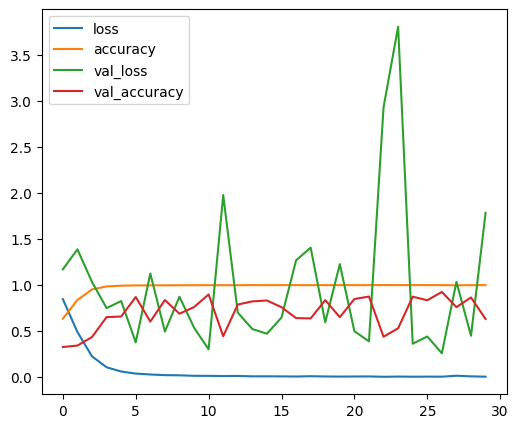

[[216  53   0]
 [  0 278   0]
 [  1 249  25]]


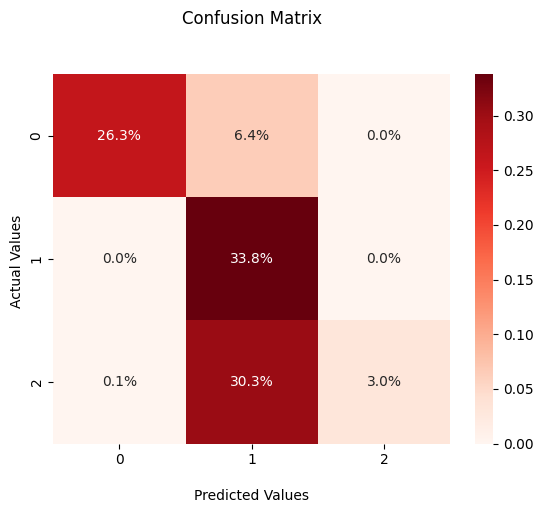

7/7 [==============================] - 0s 40ms/step - loss: 0.4629 - accuracy: 0.8343
Score : loss of 0.4628545343875885; accuracy of 83.43483805656433%
26/26 [==============================] - 2s 18ms/step
F1 score:  0.8386147919476377
Precision:  0.8876177784622062
Recall:  0.8343483556638246


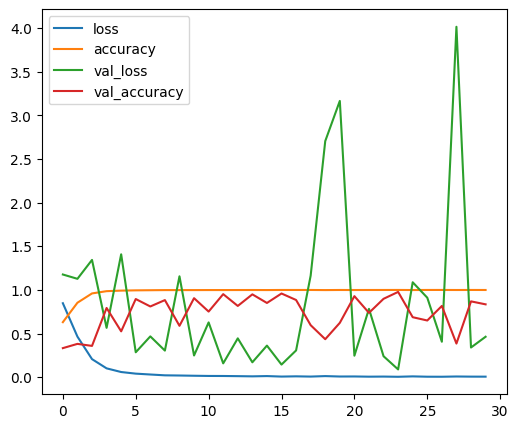

[[195  77   0]
 [  1 275   0]
 [  0  58 215]]


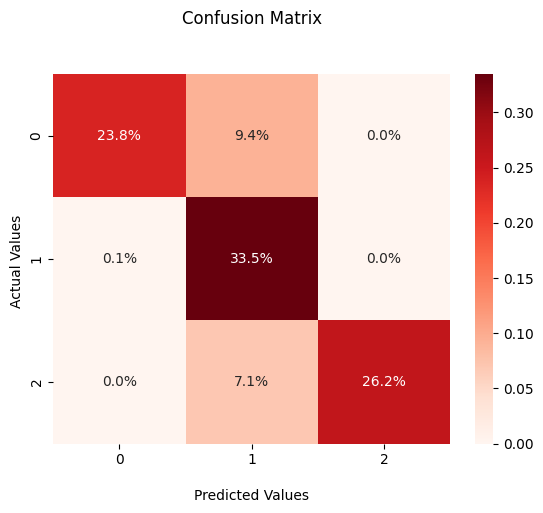

7/7 [==============================] - 0s 40ms/step - loss: 2.0437 - accuracy: 0.6466
Score : loss of 2.0437121391296387; accuracy of 64.66346383094788%
26/26 [==============================] - 2s 16ms/step
F1 score:  0.5681356943050909
Precision:  0.7253708896292821
Recall:  0.6454326923076923


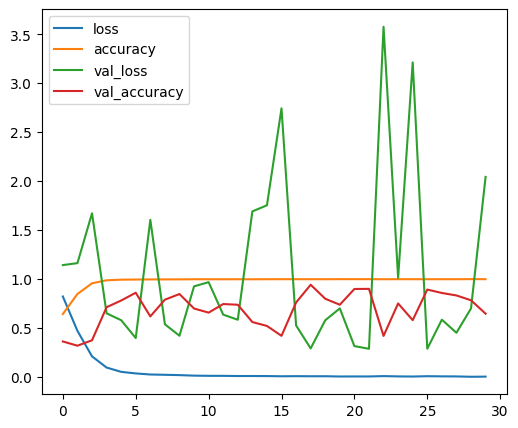

[[238  35   0]
 [ 11 268   4]
 [ 82 163  31]]


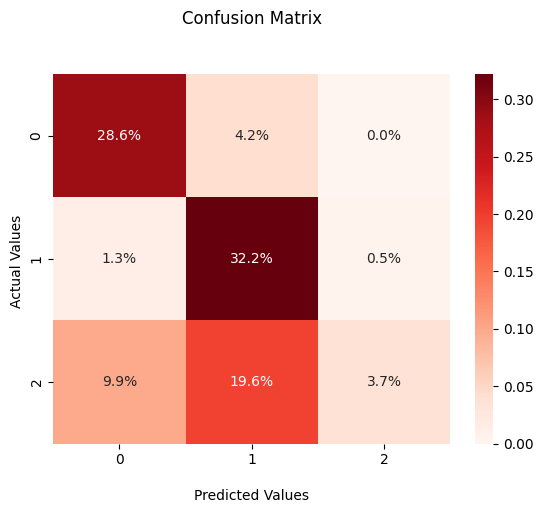

7/7 [==============================] - 0s 40ms/step - loss: 1.5946 - accuracy: 0.6341
Score : loss of 1.59457266330719; accuracy of 63.405799865722656%
26/26 [==============================] - 2s 16ms/step
F1 score:  0.6183015705554722
Precision:  0.7424533931689821
Recall:  0.6352657004830918


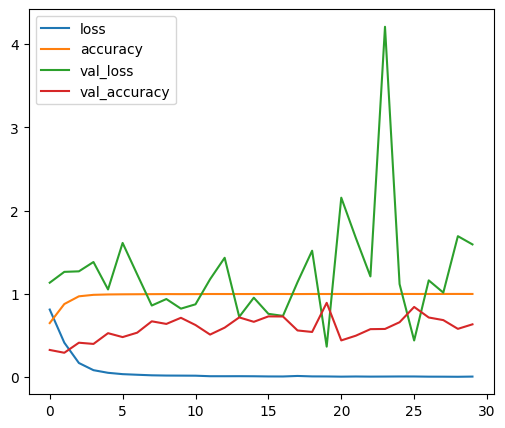

[[268  13   3]
 [106 167   3]
 [144  33  91]]


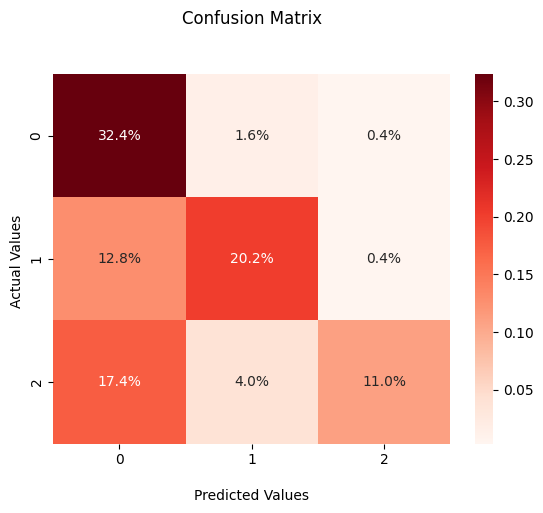

7/7 [==============================] - 0s 40ms/step - loss: 0.4819 - accuracy: 0.8637
Score : loss of 0.4818621277809143; accuracy of 86.36927008628845%
26/26 [==============================] - 3s 19ms/step
F1 score:  0.8654393004670116
Precision:  0.8817015998918525
Recall:  0.8636926889714994


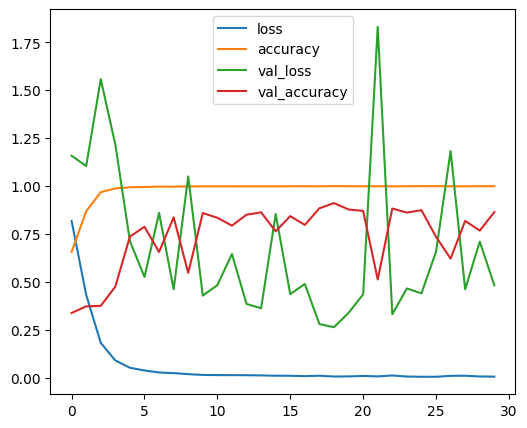

[[212  14  44]
 [  0 246  34]
 [  0  18 239]]


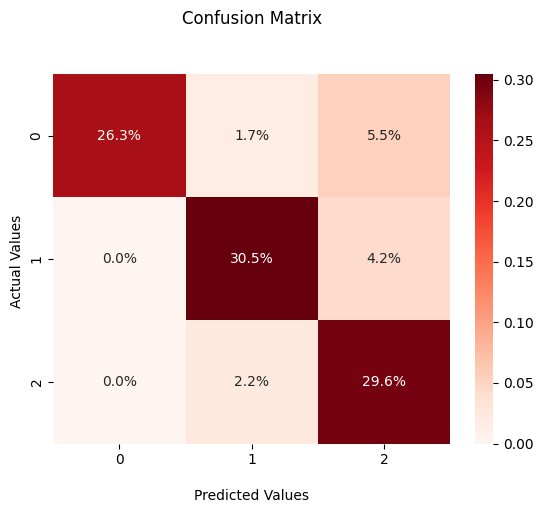

7/7 [==============================] - 0s 39ms/step - loss: 0.7208 - accuracy: 0.7861
Score : loss of 0.7208297252655029; accuracy of 78.61482501029968%
26/26 [==============================] - 2s 18ms/step
F1 score:  0.7812676005886986
Precision:  0.8262145919451086
Recall:  0.7861482381530984


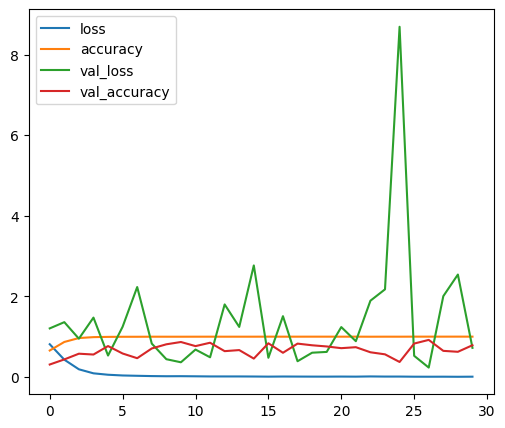

[[252  17   0]
 [ 45 246   1]
 [ 71  42 149]]


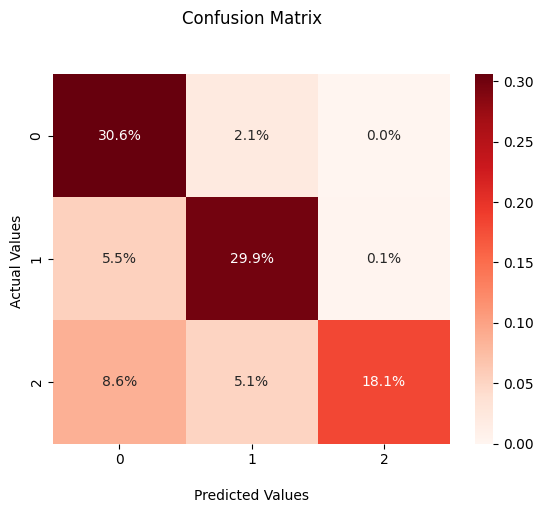

7/7 [==============================] - 0s 43ms/step - loss: 0.6325 - accuracy: 0.8459
Score : loss of 0.6325233578681946; accuracy of 84.58864688873291%
27/27 [==============================] - 2s 16ms/step
F1 score:  0.8442129452882798
Precision:  0.8560470449392733
Recall:  0.8458864426419467


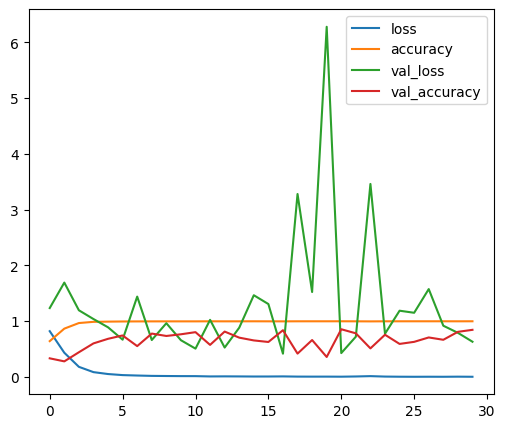

[[238  20  31]
 [ 28 219  48]
 [  1   5 273]]


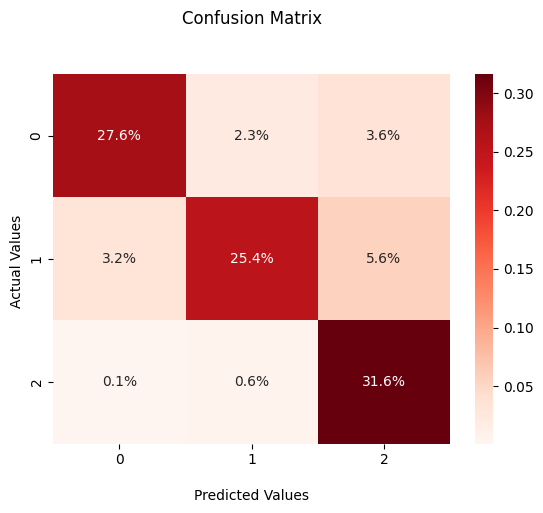

KeyboardInterrupt: ignored

In [ ]:
from sklearn.model_selection import train_test_split

# from participant p00 to p11 (omitting p08)
for sub in range(len(all_data)):

    test_data_all = all_data[sub]

    X_train_split, X_test_split, y_train_split, y_test_split = {}, {}, {}, {}

    for feature in all_features: 

      X_train_split[feature], X_test_split[feature], y_train_split[feature], y_test_split[feature] = train_test_split(
         test_data_all[feature], test_data_all['label'], test_size=0.1, random_state=3456789
         )

    
    train_data, train_data_all = {}, {}
    test_data = {}


    train_data_all["acc_x"] = np.concatenate([all_data[i]["acc_x"] for i in range(len(all_data)) if i != sub])
    train_data_all["acc_y"] = np.concatenate([all_data[i]["acc_y"] for i in range(len(all_data)) if i != sub])
    train_data_all["acc_z"] = np.concatenate([all_data[i]["acc_z"] for i in range(len(all_data)) if i != sub])
    train_data_all["eda"] = np.concatenate([all_data[i]["eda"] for i in range(len(all_data)) if i != sub])
    train_data_all["temp"] = np.concatenate([all_data[i]["temp"] for i in range(len(all_data)) if i != sub])
    train_data_all["bvp"] = np.concatenate([all_data[i]["bvp"] for i in range(len(all_data)) if i != sub])


    for feature in all_features:
      train_data[feature] = np.concatenate((train_data_all[feature], X_test_split[feature]), axis=0)


    train_data_all["label"] = np.concatenate([all_data[i]["label"] for i in range(len(all_data)) if i != sub])

    train_data["label"] = np.concatenate((train_data_all["label"], y_test_split['eda']), axis=0)

    for feature in all_features:
      test_data[feature] = X_train_split[feature]

    test_data['label'] = y_train_split['eda']

    cm_w_ft_10, acc_w_ft_10, loss_w_ft_10, f1_w_ft_10, prec_w_ft_10, rec_w_ft_10 = ResNet(train_data, test_data)

7/7 [==============================] - 0s 42ms/step - loss: 3.3224 - accuracy: 0.6413
Score : loss of 3.3224036693573; accuracy of 64.13043737411499%
26/26 [==============================] - 2s 16ms/step
F1 score:  0.5217929220813297
Precision:  0.5964211684922871
Recall:  0.6413043478260869


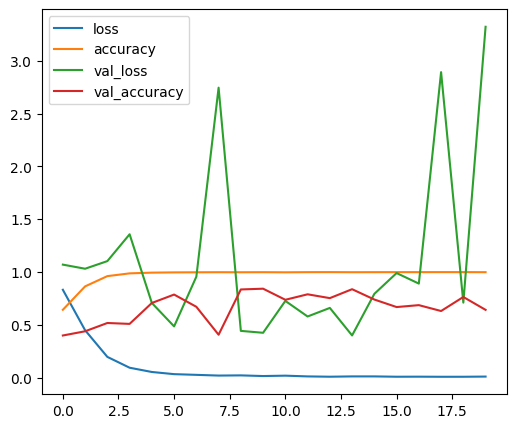

[[  1 148 115]
 [  1 265  24]
 [  0   9 265]]


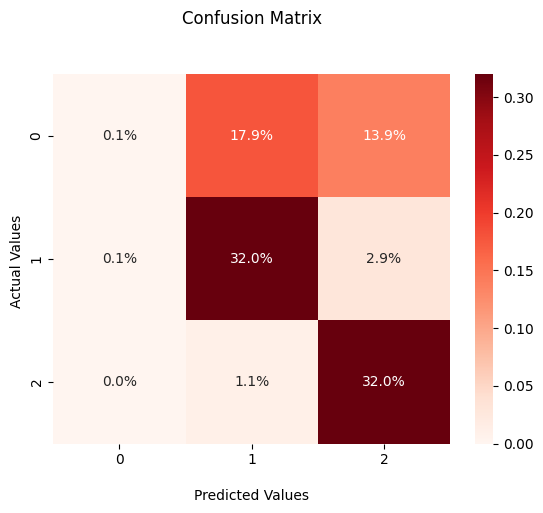

7/7 [==============================] - 0s 42ms/step - loss: 1.2406 - accuracy: 0.7038
Score : loss of 1.2406160831451416; accuracy of 70.37943601608276%
26/26 [==============================] - 2s 16ms/step
F1 score:  0.6716448704043398
Precision:  0.7834473224720881
Recall:  0.7037943696450428


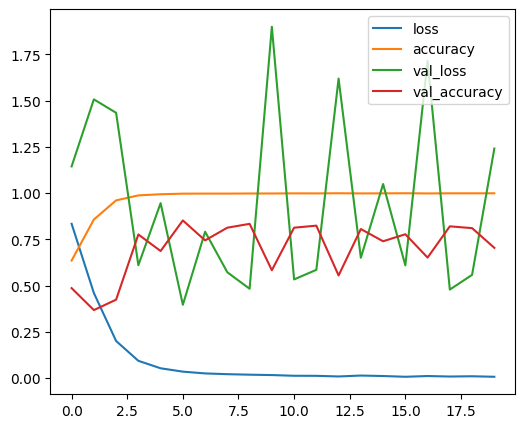

[[251   4   0]
 [ 48 231   0]
 [ 91  99  93]]


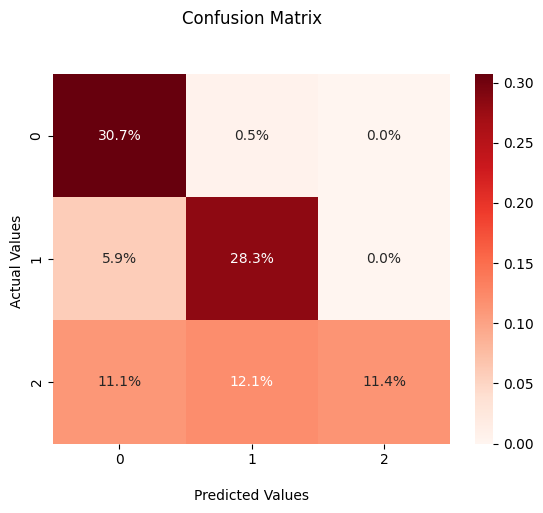

7/7 [==============================] - 0s 40ms/step - loss: 0.4156 - accuracy: 0.8039
Score : loss of 0.4155946969985962; accuracy of 80.38740754127502%
26/26 [==============================] - 2s 16ms/step
F1 score:  0.8097762159540262
Precision:  0.8692708875552855
Recall:  0.8038740920096852


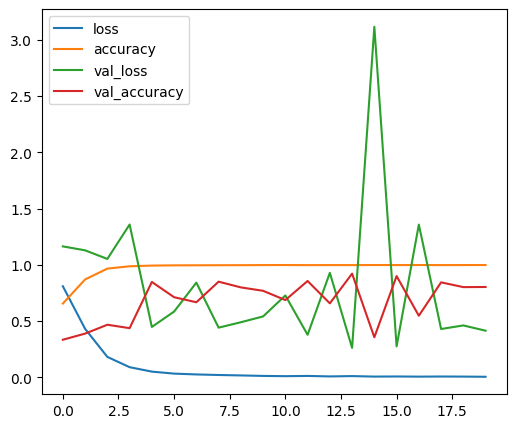

[[200   0  77]
 [  1 200  79]
 [  5   0 264]]


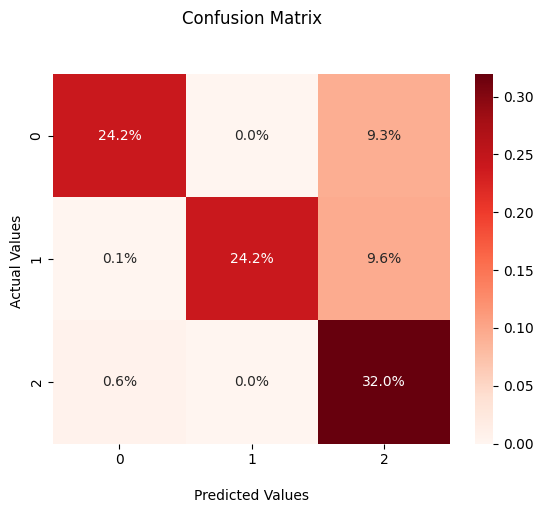

KeyboardInterrupt: ignored

In [ ]:
# from participant p12 to p14
for sub in range(len(all_data)):
  if (sub >= 11):

    test_data_all = all_data[sub]

    X_train_split, X_test_split, y_train_split, y_test_split = {}, {}, {}, {}

    for feature in all_features: 

      X_train_split[feature], X_test_split[feature], y_train_split[feature], y_test_split[feature] = train_test_split(test_data_all[feature], test_data_all['label'], test_size=0.1, random_state=3456789)

    
    train_data, train_data_all = {}, {}
    test_data = {}


    train_data_all["acc_x"] = np.concatenate([all_data[i]["acc_x"] for i in range(len(all_data)) if i != sub])
    train_data_all["acc_y"] = np.concatenate([all_data[i]["acc_y"] for i in range(len(all_data)) if i != sub])
    train_data_all["acc_z"] = np.concatenate([all_data[i]["acc_z"] for i in range(len(all_data)) if i != sub])
    train_data_all["eda"] = np.concatenate([all_data[i]["eda"] for i in range(len(all_data)) if i != sub])
    train_data_all["temp"] = np.concatenate([all_data[i]["temp"] for i in range(len(all_data)) if i != sub])
    train_data_all["bvp"] = np.concatenate([all_data[i]["bvp"] for i in range(len(all_data)) if i != sub])


    for feature in all_features:
      train_data[feature] = np.concatenate((train_data_all[feature], X_test_split[feature]), axis=0)


    train_data_all["label"] = np.concatenate([all_data[i]["label"] for i in range(len(all_data)) if i != sub])

    train_data["label"] = np.concatenate((train_data_all["label"], y_test_split['eda']), axis=0)

    for feature in all_features:
      test_data[feature] = X_train_split[feature]

    test_data['label'] = y_train_split['eda']

    cm_w_ft_10, acc_w_ft_10, loss_w_ft_10, f1_w_ft_10, prec_w_ft_10, rec_w_ft_10 = ResNet(train_data, test_data)

SUBJECT 14
7/7 [==============================] - 0s 42ms/step - loss: 0.4202 - accuracy: 0.8359
Score : loss of 0.42020183801651; accuracy of 83.58913660049438%
27/27 [==============================] - 2s 20ms/step
F1 score:  0.8383565536758184
Precision:  0.8442974257431136
Recall:  0.8370720188902007


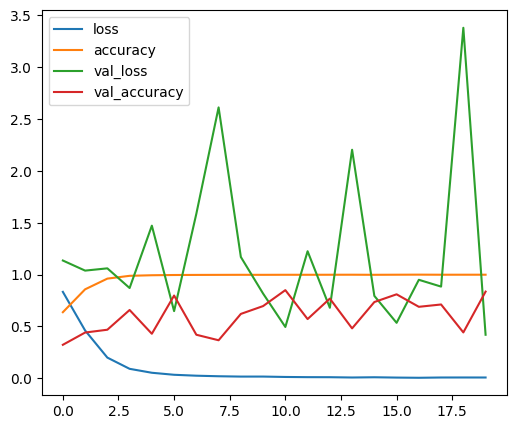

[[242  20   8]
 [ 61 222   2]
 [  0  47 245]]


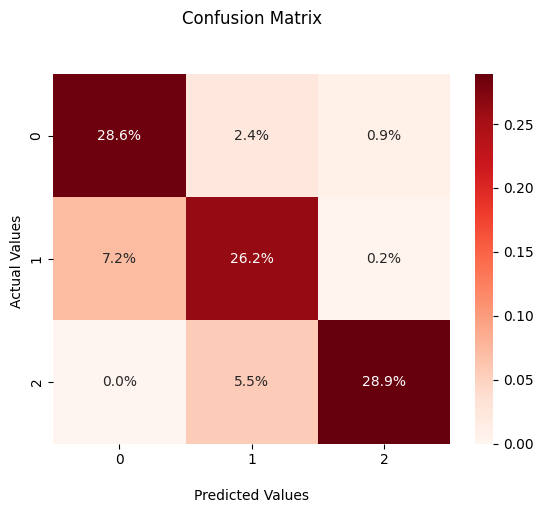

SUBJECT 15
7/7 [==============================] - 0s 41ms/step - loss: 0.9266 - accuracy: 0.7430
Score : loss of 0.9266273975372314; accuracy of 74.29620623588562%
26/26 [==============================] - 2s 17ms/step
F1 score:  0.7150090326836441
Precision:  0.7879174685992949
Recall:  0.7429620563035496


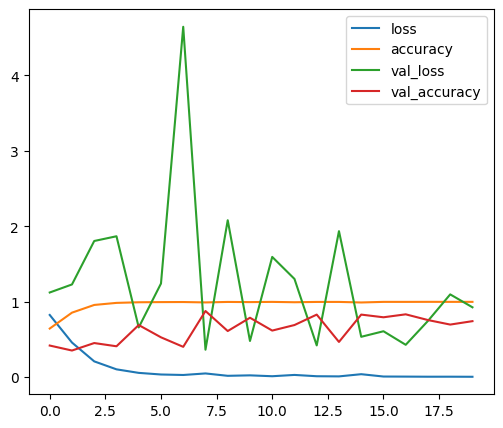

[[264   6  15]
 [ 83 101  89]
 [ 16   1 242]]


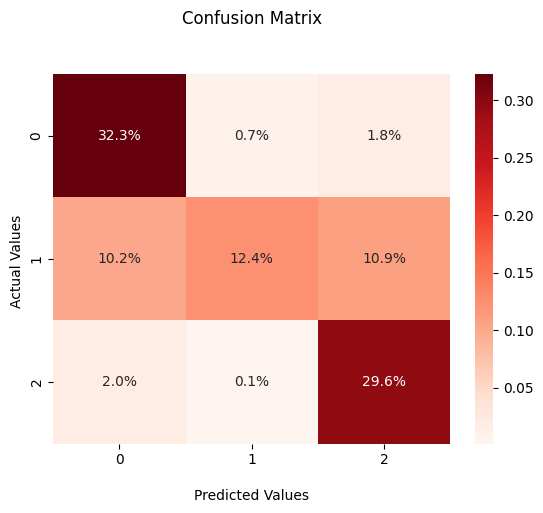

SUBJECT 16
7/7 [==============================] - 0s 42ms/step - loss: 0.4139 - accuracy: 0.8487
Score : loss of 0.4139099419116974; accuracy of 84.8739504814148%
27/27 [==============================] - 3s 17ms/step
F1 score:  0.8486921997036935
Precision:  0.8671985894645101
Recall:  0.8487394957983193


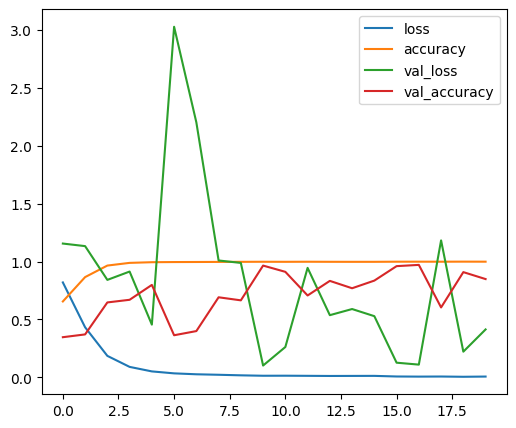

[[283   2   4]
 [ 30 220  30]
 [ 59   1 204]]


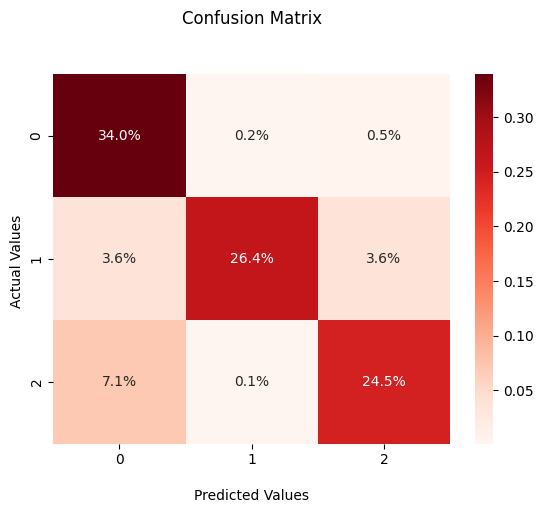

SUBJECT 17
7/7 [==============================] - 0s 42ms/step - loss: 0.3641 - accuracy: 0.8976
Score : loss of 0.36409810185432434; accuracy of 89.76190686225891%
27/27 [==============================] - 2s 17ms/step
F1 score:  0.899803486104384
Precision:  0.9204702061789863
Recall:  0.8976190476190476


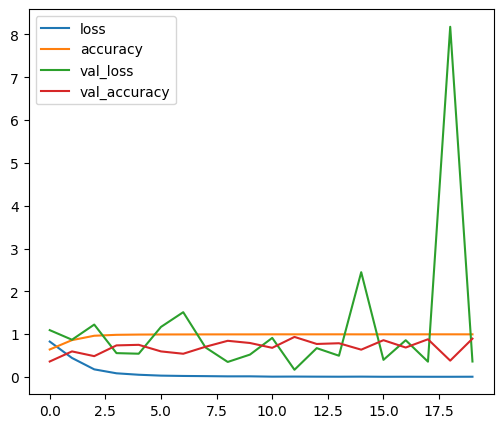

[[288   0   0]
 [ 43 239   0]
 [ 42   1 227]]


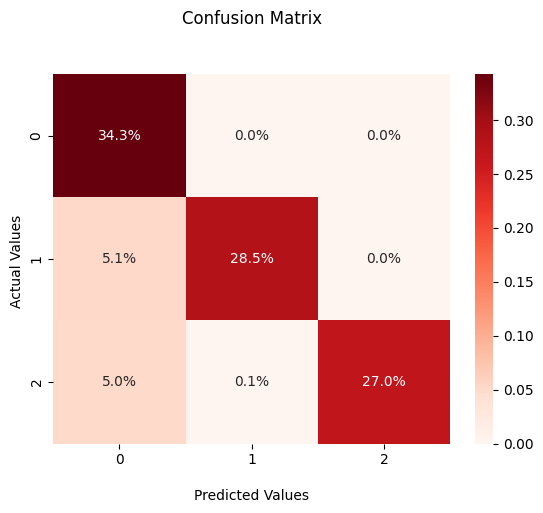

SUBJECT 18
7/7 [==============================] - 0s 41ms/step - loss: 0.5767 - accuracy: 0.8034
Score : loss of 0.5767081379890442; accuracy of 80.33573031425476%
27/27 [==============================] - 2s 19ms/step
F1 score:  0.7879311313474348
Precision:  0.8248125361453568
Recall:  0.8033573141486811


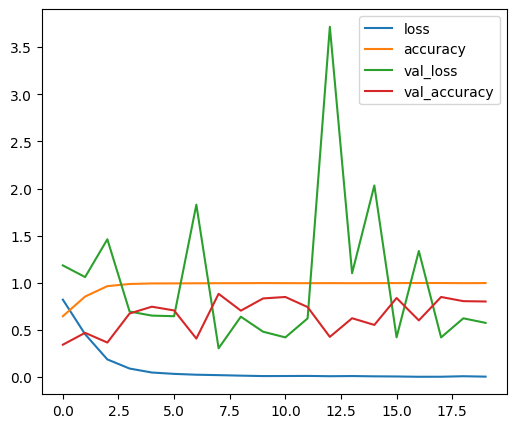

[[146  66  74]
 [  0 277   3]
 [ 13   8 247]]


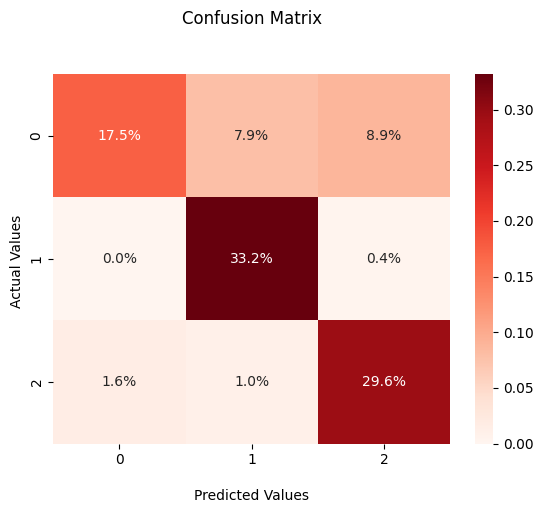

SUBJECT 19
7/7 [==============================] - 0s 41ms/step - loss: 0.1717 - accuracy: 0.9459
Score : loss of 0.17171187698841095; accuracy of 94.58794593811035%
26/26 [==============================] - 2s 17ms/step
F1 score:  0.9456236458767229
Precision:  0.9467176629499343
Recall:  0.9458794587945879


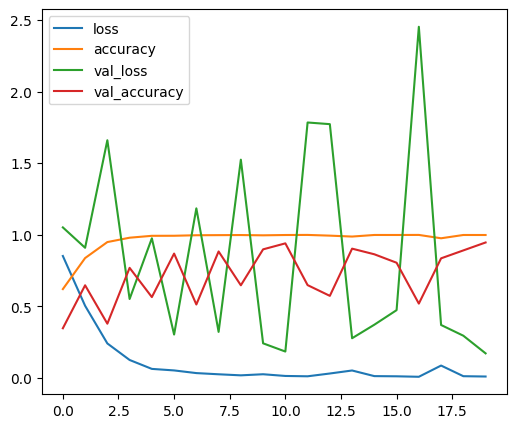

[[271   3   4]
 [ 16 246  12]
 [  4   5 252]]


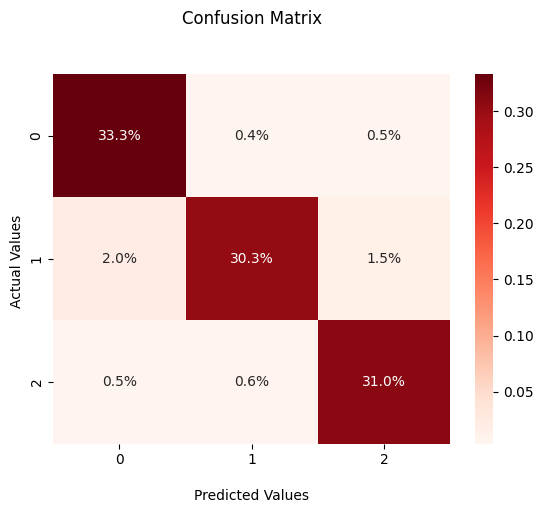

SUBJECT 20
7/7 [==============================] - 0s 42ms/step - loss: 0.5285 - accuracy: 0.7841
Score : loss of 0.5285444855690002; accuracy of 78.40772271156311%
26/26 [==============================] - 2s 17ms/step
F1 score:  0.7700610973430153
Precision:  0.8438073122630115
Recall:  0.7840772014475271


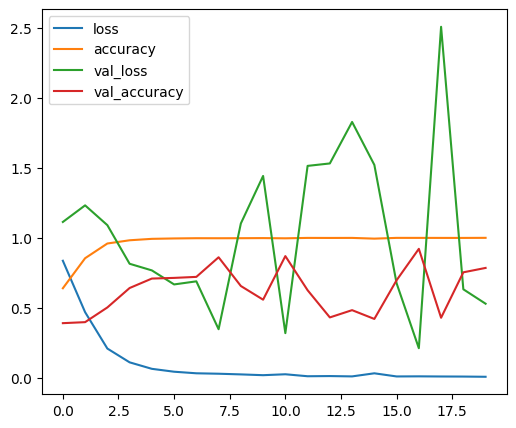

[[269  10   0]
 [ 17 253   1]
 [132  19 128]]


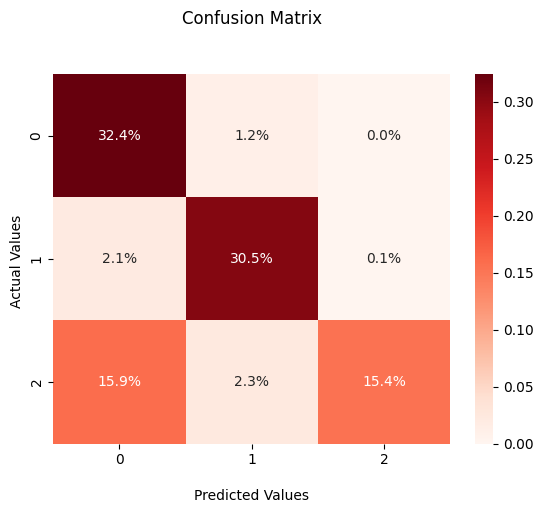

SUBJECT 21
7/7 [==============================] - 0s 40ms/step - loss: 0.3265 - accuracy: 0.8894
Score : loss of 0.3264785408973694; accuracy of 88.94348740577698%
26/26 [==============================] - 2s 16ms/step
F1 score:  0.889820714051098
Precision:  0.8968118784301277
Recall:  0.8894348894348895


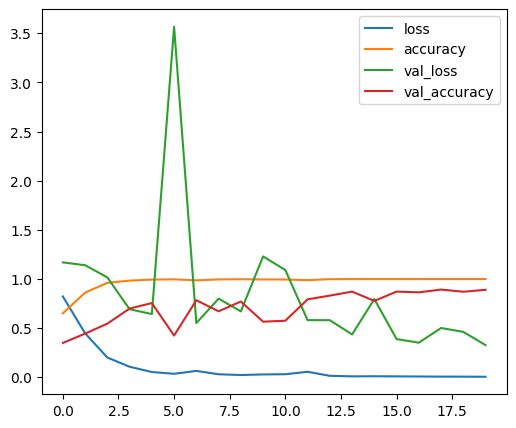

[[235  25  24]
 [  1 252  20]
 [  3  17 237]]


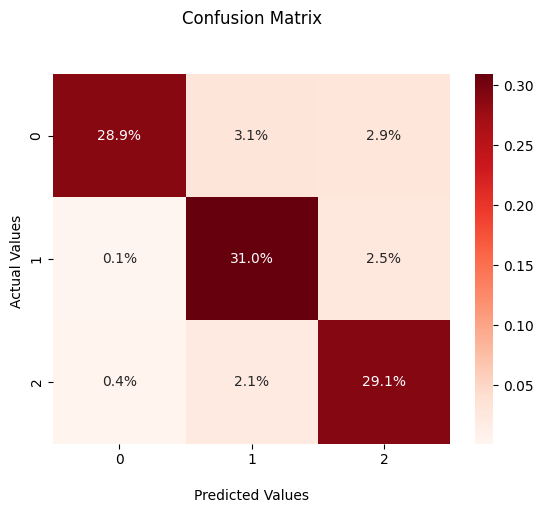

In [ ]:
# from subject p15 to p24 (omitting p18 and p20)
for sub in range(len(all_data)):
  if (sub >= 14):
    print('SUBJECT',sub)

    test_data_all = all_data[sub]

    X_train_split, X_test_split, y_train_split, y_test_split = {}, {}, {}, {}

    for feature in all_features: 

      X_train_split[feature], X_test_split[feature], y_train_split[feature], y_test_split[feature] = train_test_split(
        test_data_all[feature], test_data_all['label'], test_size=0.1, random_state=3456789
        )

    
    train_data, train_data_all = {}, {}
    test_data = {}


    train_data_all["acc_x"] = np.concatenate([all_data[i]["acc_x"] for i in range(len(all_data)) if i != sub])
    train_data_all["acc_y"] = np.concatenate([all_data[i]["acc_y"] for i in range(len(all_data)) if i != sub])
    train_data_all["acc_z"] = np.concatenate([all_data[i]["acc_z"] for i in range(len(all_data)) if i != sub])
    train_data_all["eda"] = np.concatenate([all_data[i]["eda"] for i in range(len(all_data)) if i != sub])
    train_data_all["temp"] = np.concatenate([all_data[i]["temp"] for i in range(len(all_data)) if i != sub])
    train_data_all["bvp"] = np.concatenate([all_data[i]["bvp"] for i in range(len(all_data)) if i != sub])


    for feature in all_features:
      train_data[feature] = np.concatenate((train_data_all[feature], X_test_split[feature]), axis=0)


    train_data_all["label"] = np.concatenate([all_data[i]["label"] for i in range(len(all_data)) if i != sub])

    train_data["label"] = np.concatenate((train_data_all["label"], y_test_split['eda']), axis=0)

    for feature in all_features:
      test_data[feature] = X_train_split[feature]

    test_data['label'] = y_train_split['eda']

    cm_w_ft_10, acc_w_ft_10, loss_w_ft_10, f1_w_ft_10, prec_w_ft_10, rec_w_ft_10 = ResNet(train_data, test_data)

**Average accuracy and F1 score (10% ft)**

In [10]:
print(acc_w_ft_10)

[81.40096664428711, 88.87559771537781, 86.64259910583496, 90.09661674499512, 63.13868761062622, 83.43483805656433, 64.66346383094788, 63.405799865722656, 86.36927008628845, 78.61482501029968, 84.58864688873291, 64.13043737411499, 70.37943601608276, 80.38740754127502, 83.58913660049438, 74.29620623588562, 84.8739504814148, 89.76190686225891, 80.33573031425476, 94.58794593811035, 78.40772271156311, 88.94348740577698]


In [ ]:
#print(cm_w_ft_10)
print(np.mean(acc_w_ft_10))
print(np.mean(f1_w_ft_10))


80.04203086549586
0.7841805252955836


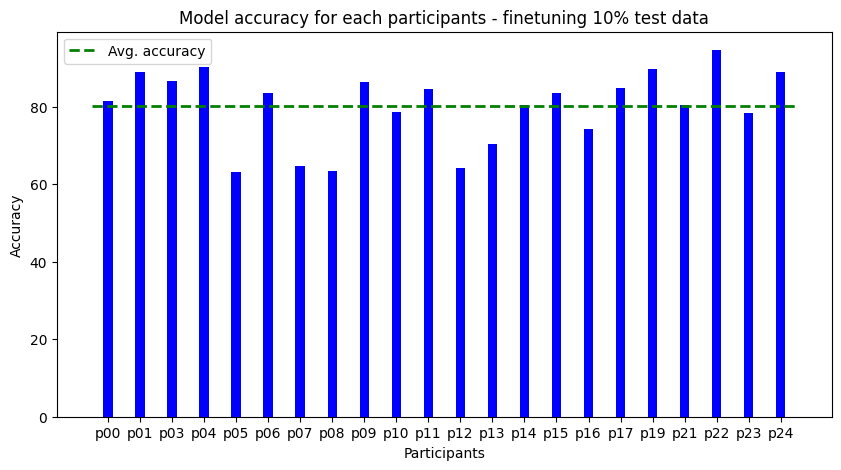

In [ ]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(participants, acc_w_ft_10, color ='blue',width = 0.3)
 
plt.xlabel("Participants")
plt.ylabel("Accuracy")
plt.title("Model accuracy for each participants - finetuning 10% test data")

plt.hlines(y=(np.mean(acc_w_ft_10)), xmin=-0.5, xmax=(len(f1_w_ft_10)-0.5), colors='green', linestyles='--', lw=2, label='Avg. accuracy')
plt.legend()

plt.show()

[[[177, 105, 2], [0, 283, 2], [0, 45, 214]], [[260, 15, 0], [21, 249, 15], [34, 8, 234]], [[252, 0, 30], [10, 194, 70], [0, 1, 274]], [[219, 18, 22], [2, 288, 6], [5, 29, 239]], [[216, 53, 0], [0, 278, 0], [1, 249, 25]], [[195, 77, 0], [1, 275, 0], [0, 58, 215]], [[238, 35, 0], [11, 268, 4], [82, 163, 31]], [[268, 13, 3], [106, 167, 3], [144, 33, 91]], [[212, 14, 44], [0, 246, 34], [0, 18, 239]], [[252, 17, 0], [45, 246, 1], [71, 42, 149]], [[238, 20, 31], [28, 219, 48], [1, 5, 273]], [[1, 148, 115], [1, 265, 24], [0, 9, 265]], [[251, 4, 0], [48, 231, 0], [91, 99, 93]], [[200, 0, 77], [1, 200, 79], [5, 0, 264]], [[242, 20, 8], [61, 222, 2], [0, 47, 245]], [[264, 6, 15], [83, 101, 89], [16, 1, 242]], [[283, 2, 4], [30, 220, 30], [59, 1, 204]], [[288, 0, 0], [43, 239, 0], [42, 1, 227]], [[146, 66, 74], [0, 277, 3], [13, 8, 247]], [[271, 3, 4], [16, 246, 12], [4, 5, 252]], [[269, 10, 0], [17, 253, 1], [132, 19, 128]], [[235, 25, 24], [1, 252, 20], [3, 17, 237]]]
[[226.22727272727272, 29.5

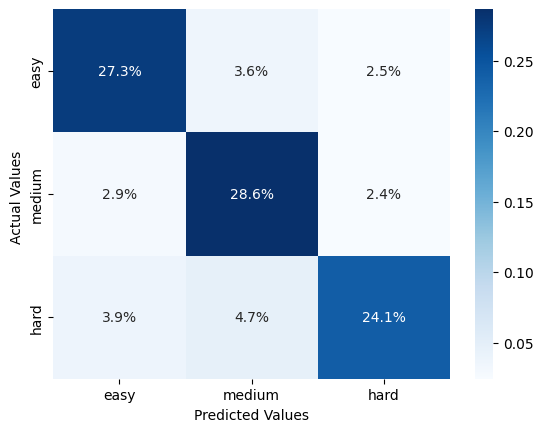

In [8]:
# cm_w_ft_10 seperated by commas

print(cm_w_ft_10)

ele_00, ele_01, ele_02 = [], [], []
ele_10, ele_11, ele_12 = [], [], []
ele_20, ele_21, ele_22 = [], [], []

for i in range(len(cm_w_ft_10)):
  ele_00.append(cm_w_ft_10[i][0][0])
  ele_01.append(cm_w_ft_10[i][0][1])
  ele_02.append(cm_w_ft_10[i][0][2])
  ele_10.append(cm_w_ft_10[i][1][0])
  ele_11.append(cm_w_ft_10[i][1][1])
  ele_12.append(cm_w_ft_10[i][1][2])
  ele_20.append(cm_w_ft_10[i][2][0])
  ele_21.append(cm_w_ft_10[i][2][1])
  ele_22.append(cm_w_ft_10[i][2][2])

cm = [[ np.mean(ele_00), np.mean(ele_01), np.mean(ele_02)],
      [ np.mean(ele_10), np.mean(ele_11), np.mean(ele_12)],
      [ np.mean(ele_20), np.mean(ele_21), np.mean(ele_22)]]

print(cm)

ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.1%', cmap='Blues')
ax.figsize=(5,5)
#ax.set_title('\nConfusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');
    
ax.xaxis.set_ticklabels(['easy','medium','hard'])
ax.yaxis.set_ticklabels(['easy','medium','hard'])

#plt.savefig('resnet_cm_ft_10.pdf')

plt.show()

# **Finetuning 20% of test data (LOSO)**

SUBJECT 0
6/6 [==============================] - 0s 44ms/step - loss: 0.1473 - accuracy: 0.9674
Score : loss of 0.14730478823184967; accuracy of 96.7391312122345%
23/23 [==============================] - 3s 19ms/step
F1 score:  0.9674516517144489
Precision:  0.9690796791879105
Recall:  0.967391304347826


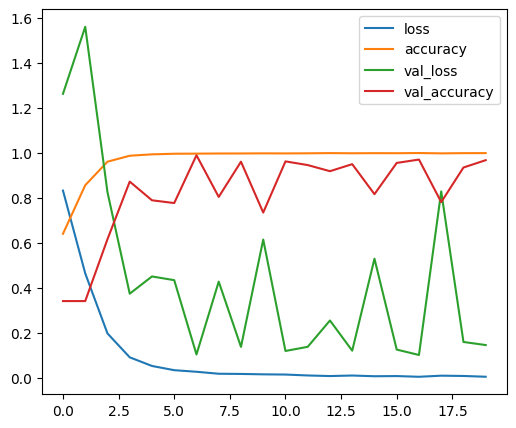

[[236   6  10]
 [  0 243   8]
 [  0   0 233]]


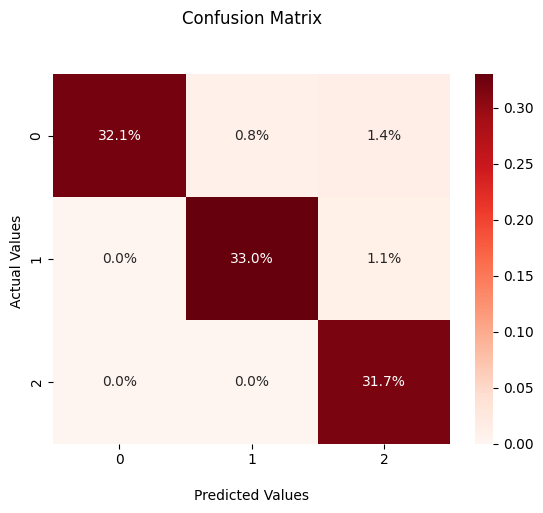

SUBJECT 1
6/6 [==============================] - 0s 45ms/step - loss: 0.2033 - accuracy: 0.9192
Score : loss of 0.20329126715660095; accuracy of 91.92463159561157%
24/24 [==============================] - 3s 22ms/step
F1 score:  0.9210304855376341
Precision:  0.9350803578497348
Recall:  0.9192462987886945


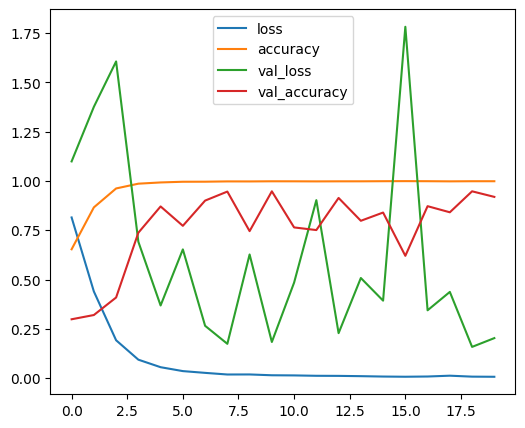

[[219  28   0]
 [  0 246   0]
 [  0  32 218]]


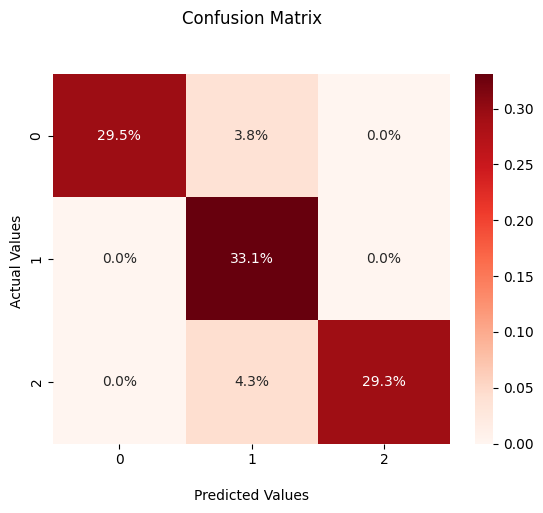

SUBJECT 2
6/6 [==============================] - 0s 44ms/step - loss: 0.4604 - accuracy: 0.8092
Score : loss of 0.4603627920150757; accuracy of 80.92015981674194%
24/24 [==============================] - 3s 22ms/step
F1 score:  0.8044714998379429
Precision:  0.8694275454730467
Recall:  0.8092016238159675


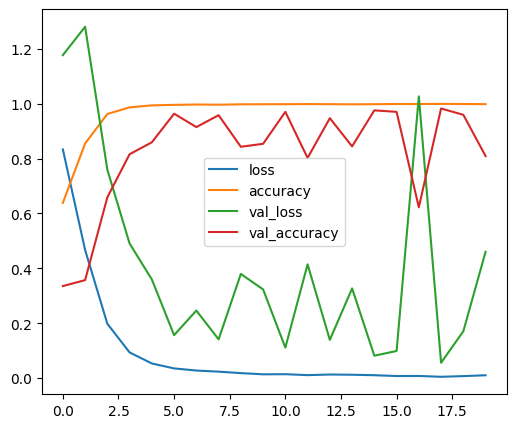

[[248   0   0]
 [ 27 210   0]
 [104  10 140]]


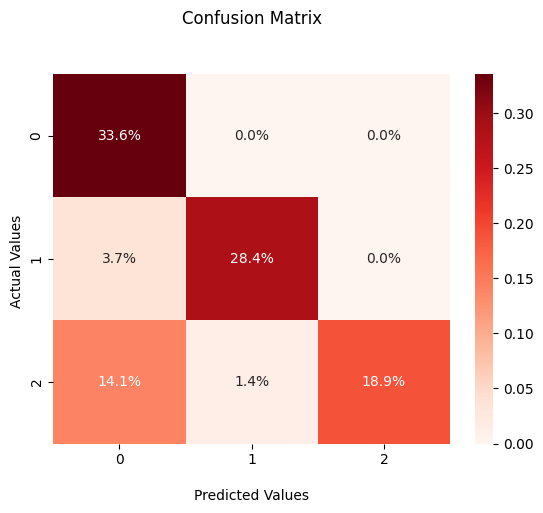

SUBJECT 3
6/6 [==============================] - 0s 44ms/step - loss: 0.3999 - accuracy: 0.8451
Score : loss of 0.39987289905548096; accuracy of 84.5108687877655%
23/23 [==============================] - 3s 18ms/step
F1 score:  0.8389296228648939
Precision:  0.8613827848005139
Recall:  0.845108695652174


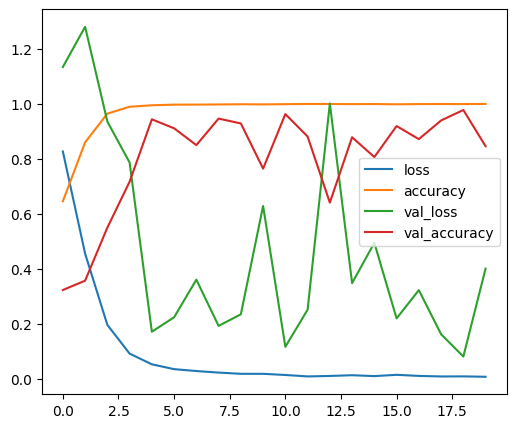

[[145  61  27]
 [  7 251   3]
 [  2  14 226]]


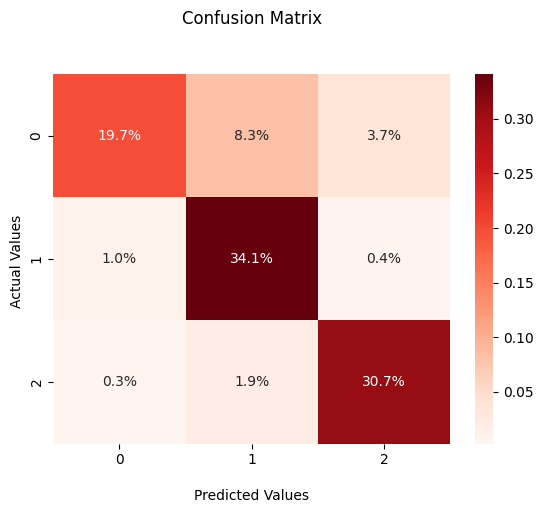

SUBJECT 4
6/6 [==============================] - 0s 44ms/step - loss: 0.1232 - accuracy: 0.9617
Score : loss of 0.12323476374149323; accuracy of 96.16963267326355%
23/23 [==============================] - 3s 22ms/step
F1 score:  0.9615416607196071
Precision:  0.9627934615237405
Recall:  0.9616963064295485


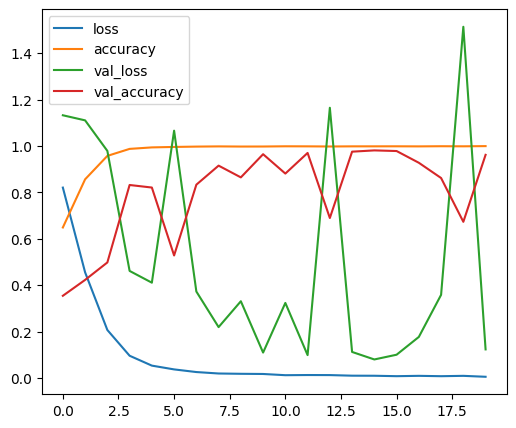

[[222   8  12]
 [  2 238   3]
 [  0   3 243]]


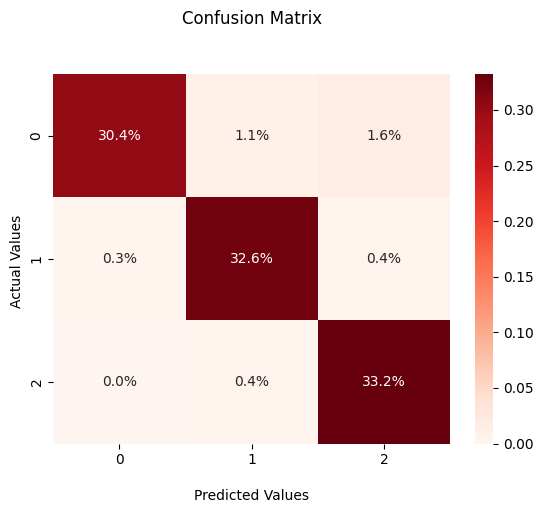

SUBJECT 5
6/6 [==============================] - 0s 45ms/step - loss: 0.2784 - accuracy: 0.8849
Score : loss of 0.2783735990524292; accuracy of 88.49315047264099%
23/23 [==============================] - 3s 21ms/step
F1 score:  0.8868449910783601
Precision:  0.9117091115034459
Recall:  0.8849315068493151


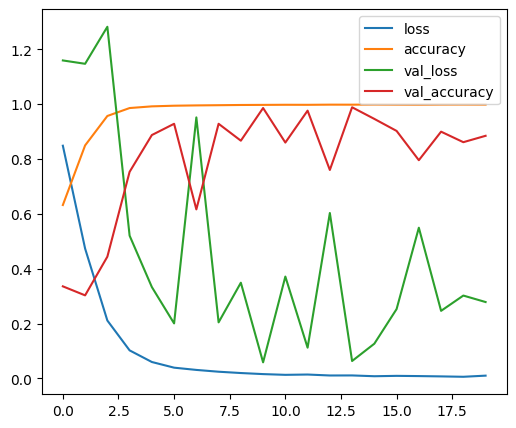

[[189  56   0]
 [  0 241   0]
 [  3  25 216]]


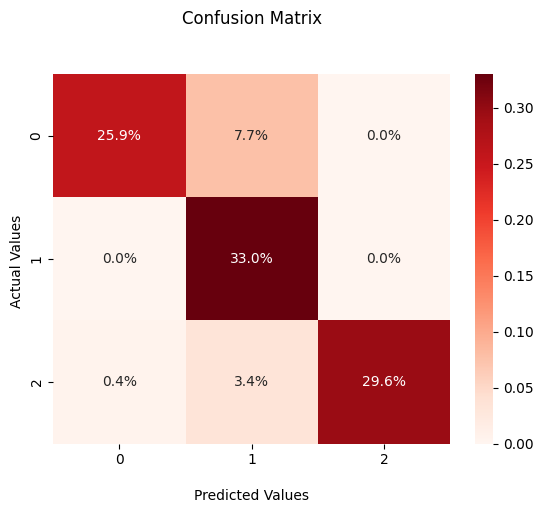

SUBJECT 6
6/6 [==============================] - 0s 46ms/step - loss: 0.1147 - accuracy: 0.9581
Score : loss of 0.11468108743429184; accuracy of 95.8108127117157%
24/24 [==============================] - 3s 22ms/step
F1 score:  0.9581529117573153
Precision:  0.9589885927222886
Recall:  0.9581081081081081


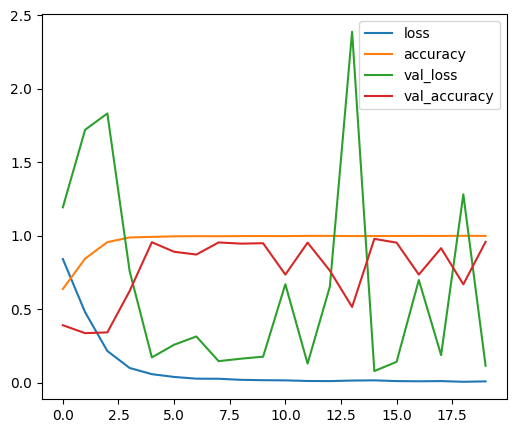

[[243   6   0]
 [ 17 228   2]
 [  3   3 238]]


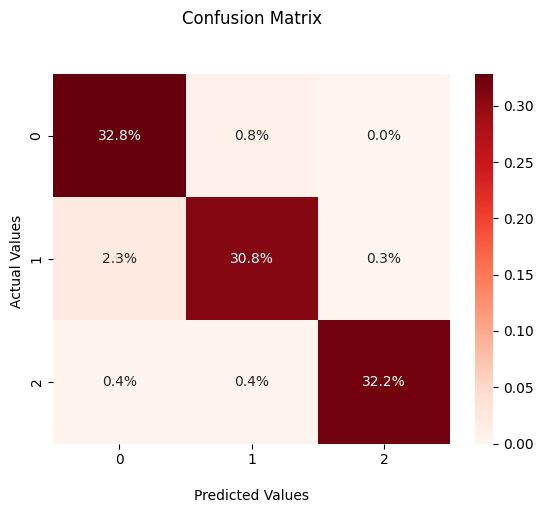

SUBJECT 7
6/6 [==============================] - 0s 45ms/step - loss: 0.2421 - accuracy: 0.9321
Score : loss of 0.24210795760154724; accuracy of 93.20651888847351%
23/23 [==============================] - 3s 19ms/step
F1 score:  0.9321411831916603
Precision:  0.9327786309844864
Recall:  0.9320652173913043


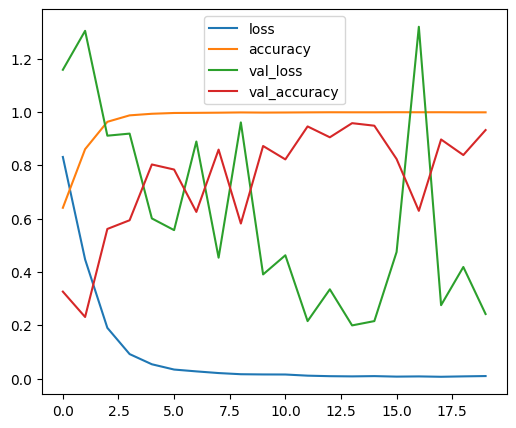

[[236  10   3]
 [ 10 224  10]
 [ 15   2 226]]


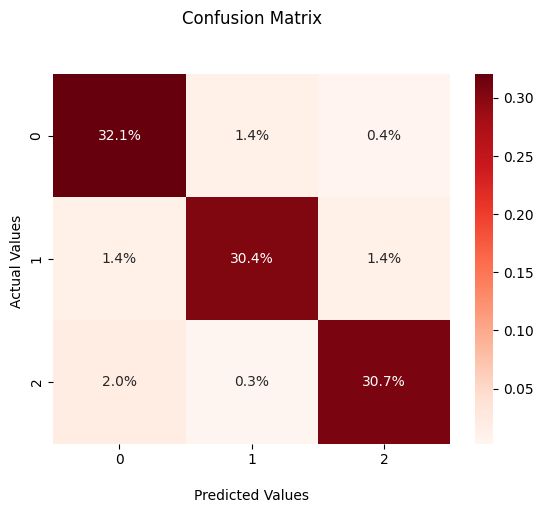

SUBJECT 8
6/6 [==============================] - 0s 44ms/step - loss: 0.1816 - accuracy: 0.9344
Score : loss of 0.18161547183990479; accuracy of 93.44490766525269%
23/23 [==============================] - 3s 22ms/step
F1 score:  0.9340568869785724
Precision:  0.9340716496775783
Recall:  0.9344490934449093


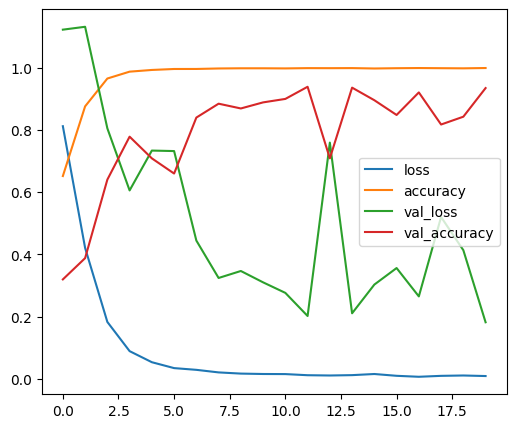

[[239   2   0]
 [ 12 216  14]
 [  0  19 215]]


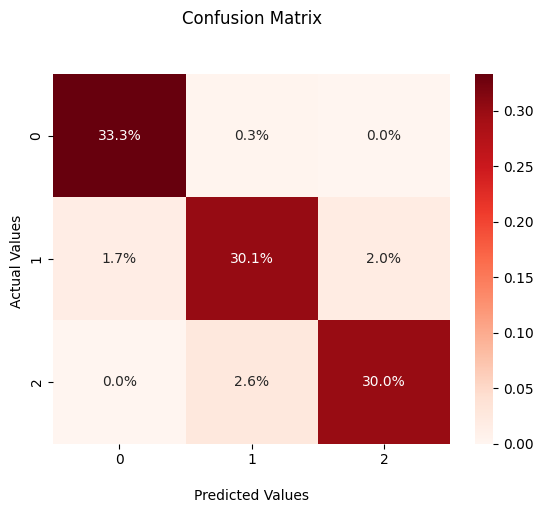

SUBJECT 9
6/6 [==============================] - 0s 45ms/step - loss: 0.3249 - accuracy: 0.9208
Score : loss of 0.3249203860759735; accuracy of 92.07650423049927%
23/23 [==============================] - 3s 22ms/step
F1 score:  0.9213718168222118
Precision:  0.9276664904224233
Recall:  0.9207650273224044


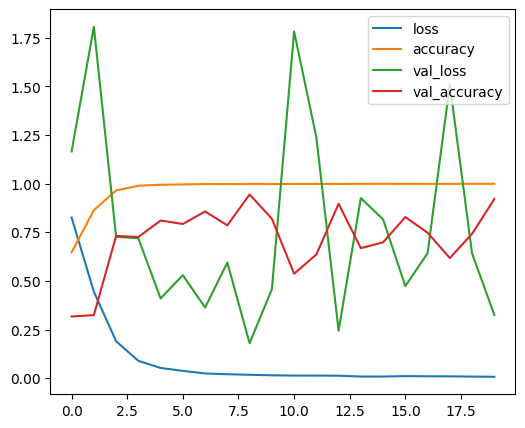

[[237   8   0]
 [ 16 233   2]
 [ 28   4 204]]


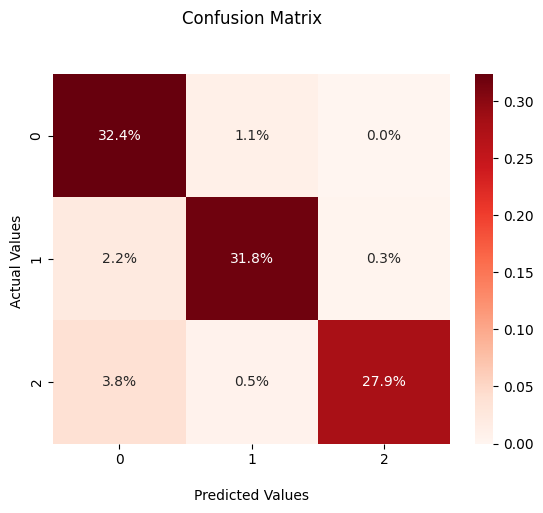

SUBJECT 10
6/6 [==============================] - 0s 47ms/step - loss: 0.9757 - accuracy: 0.7262
Score : loss of 0.9756884574890137; accuracy of 72.62060046195984%
24/24 [==============================] - 3s 21ms/step
F1 score:  0.7177031061502079
Precision:  0.8472517669663076
Recall:  0.7262059973924381


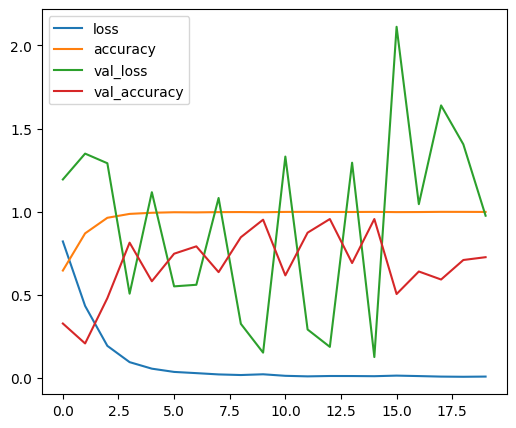

[[194  61   0]
 [  0 265   0]
 [  0 149  98]]


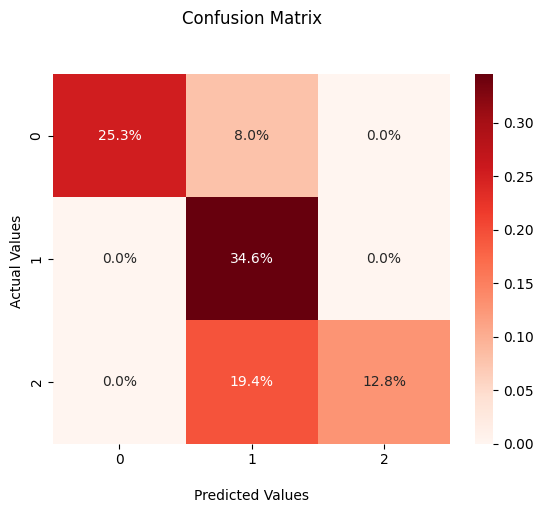

SUBJECT 11
6/6 [==============================] - 0s 45ms/step - loss: 0.5684 - accuracy: 0.8125
Score : loss of 0.5683719515800476; accuracy of 81.25%
23/23 [==============================] - 3s 19ms/step
F1 score:  0.8055691621336968
Precision:  0.875056089641604
Recall:  0.8125


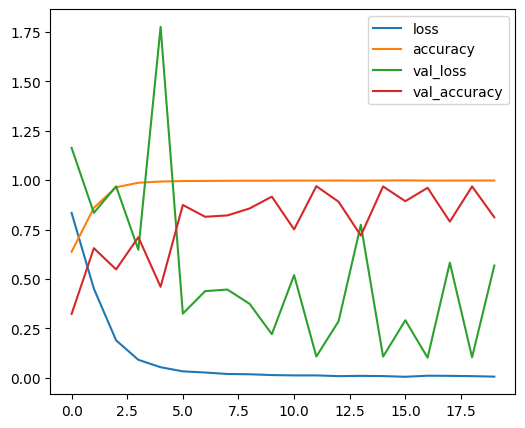

[[121 117   0]
 [  0 254   1]
 [  1  19 223]]


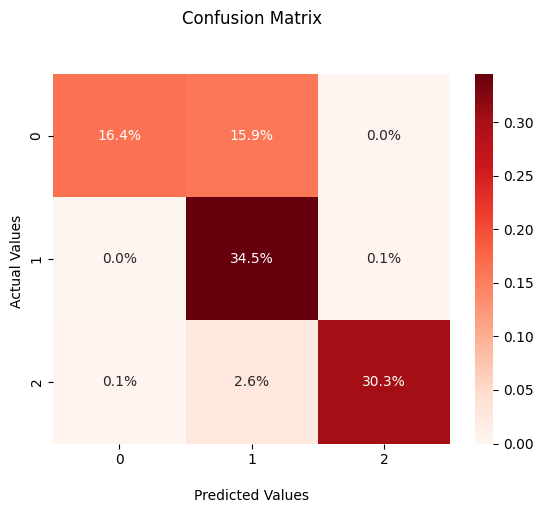

SUBJECT 12
6/6 [==============================] - 0s 44ms/step - loss: 0.3152 - accuracy: 0.9077
Score : loss of 0.3152006268501282; accuracy of 90.77134728431702%
23/23 [==============================] - 3s 22ms/step
F1 score:  0.9091774228772522
Precision:  0.9218930384270033
Recall:  0.9077134986225895


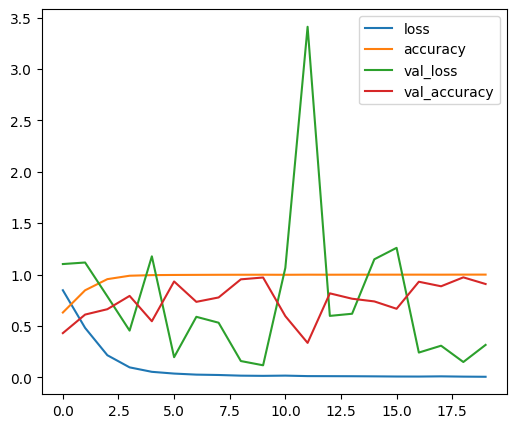

[[229   2   0]
 [ 34 211   0]
 [ 24   7 219]]


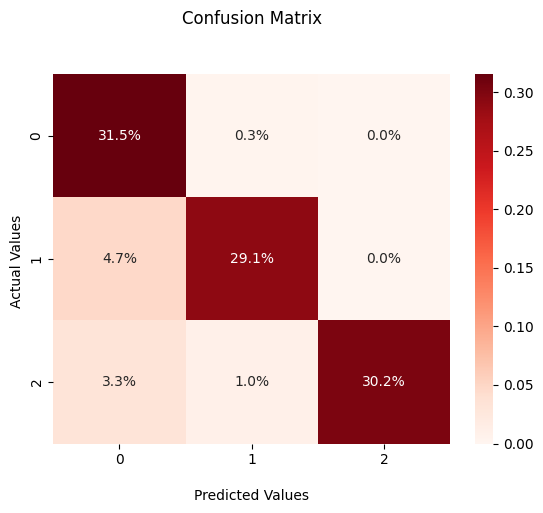

SUBJECT 13
6/6 [==============================] - 0s 45ms/step - loss: 1.0301 - accuracy: 0.6322
Score : loss of 1.0300583839416504; accuracy of 63.215261697769165%
23/23 [==============================] - 3s 22ms/step
F1 score:  0.6140372774247411
Precision:  0.8041535558723704
Recall:  0.6321525885558583


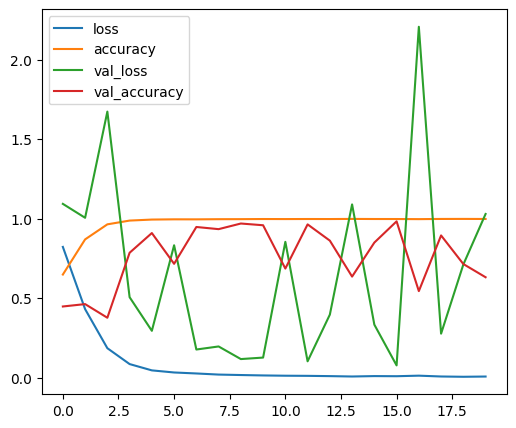

[[ 71 179   0]
 [  0 245   0]
 [  5  86 148]]


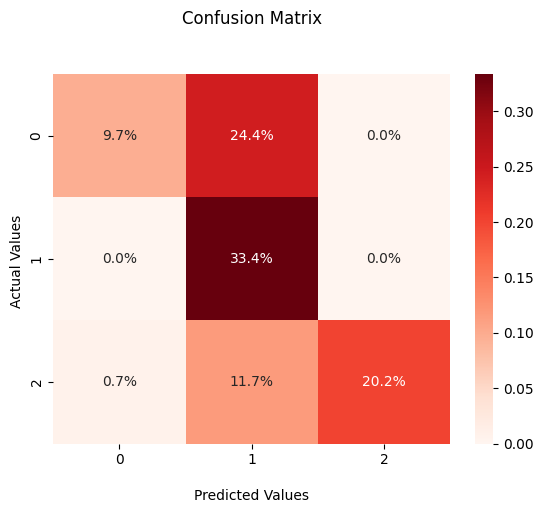

SUBJECT 14
6/6 [==============================] - 0s 45ms/step - loss: 1.3480 - accuracy: 0.5485
Score : loss of 1.3480387926101685; accuracy of 54.84727621078491%
24/24 [==============================] - 3s 22ms/step
F1 score:  0.5222582878204549
Precision:  0.7311117798006121
Recall:  0.548472775564409


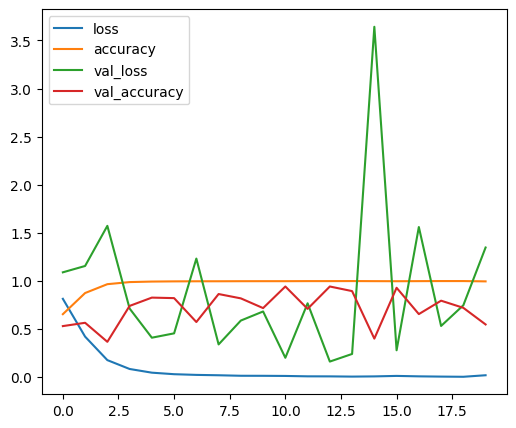

[[238   1   0]
 [147  77  33]
 [159   0  98]]


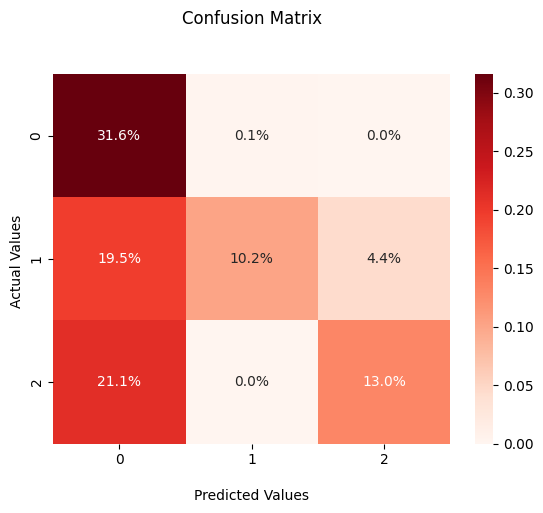

SUBJECT 15
6/6 [==============================] - 0s 44ms/step - loss: 0.2783 - accuracy: 0.8967
Score : loss of 0.2783231735229492; accuracy of 89.66942429542542%
23/23 [==============================] - 3s 19ms/step
F1 score:  0.897868861231048
Precision:  0.9177819333981454
Recall:  0.8966942148760331


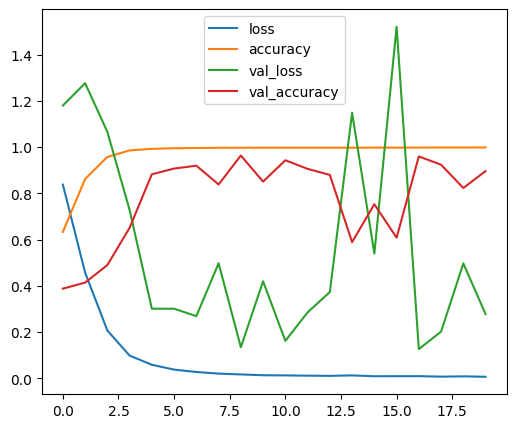

[[250   0   0]
 [ 46 192   4]
 [ 25   0 209]]


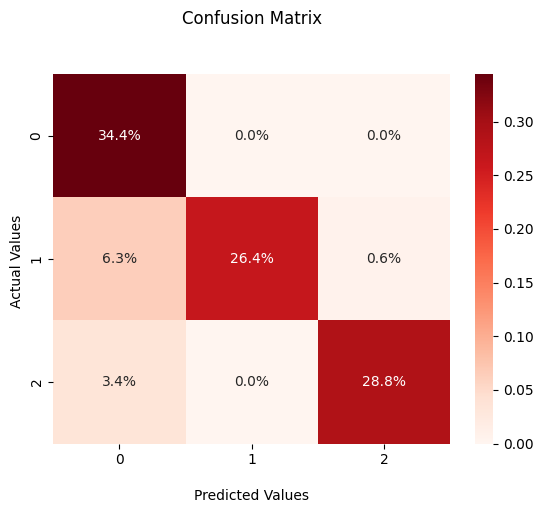

SUBJECT 16
6/6 [==============================] - 0s 45ms/step - loss: 0.3759 - accuracy: 0.8757
Score : loss of 0.37591424584388733; accuracy of 87.56756782531738%
24/24 [==============================] - 3s 18ms/step
F1 score:  0.8785891854832762
Precision:  0.9053527568489206
Recall:  0.8756756756756757


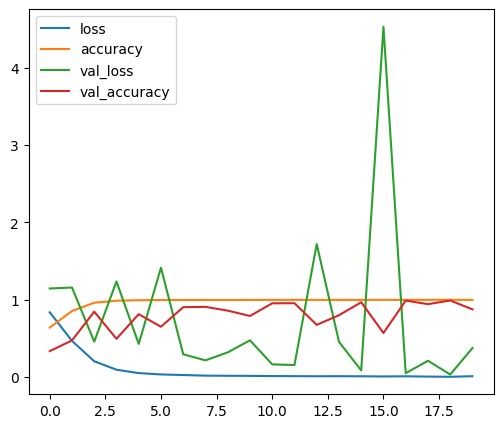

[[251   3   0]
 [ 41 204   0]
 [ 48   0 193]]


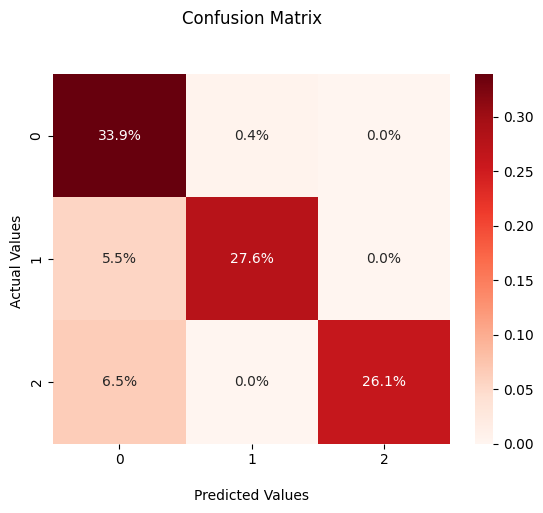

SUBJECT 17
6/6 [==============================] - 0s 46ms/step - loss: 0.2149 - accuracy: 0.9277
Score : loss of 0.21493132412433624; accuracy of 92.77108311653137%
24/24 [==============================] - 3s 22ms/step
F1 score:  0.9263891330726013
Precision:  0.9345539898168417
Recall:  0.9263721552878179


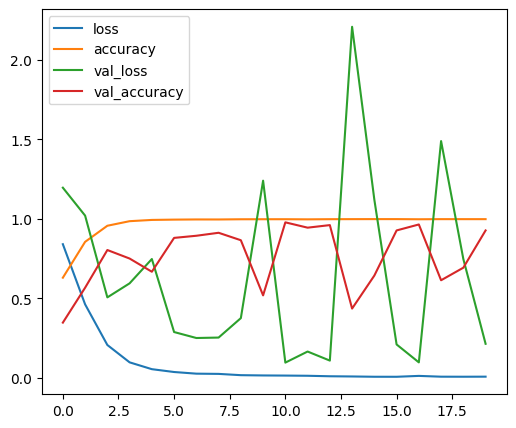

[[242  17   1]
 [  0 249   0]
 [ 10  27 201]]


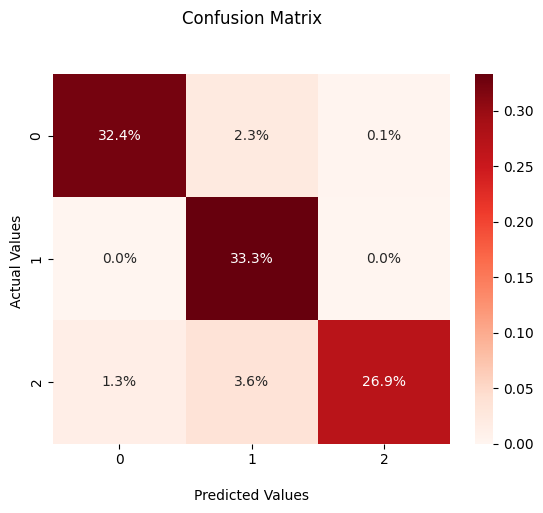

SUBJECT 18
6/6 [==============================] - 0s 45ms/step - loss: 0.1550 - accuracy: 0.9474
Score : loss of 0.15499959886074066; accuracy of 94.73684430122375%
24/24 [==============================] - 3s 22ms/step
F1 score:  0.9472345196627123
Precision:  0.9524670370883155
Recall:  0.9473684210526315


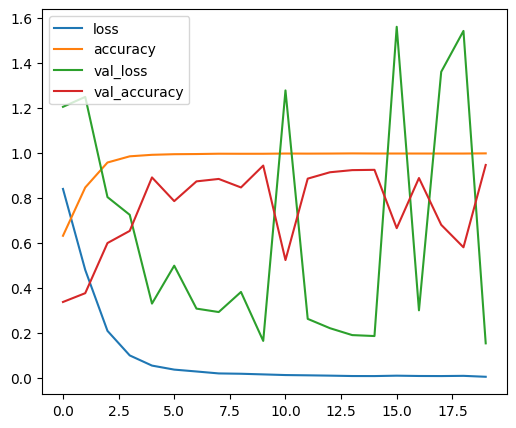

[[248   3   0]
 [  3 242   0]
 [ 31   2 212]]


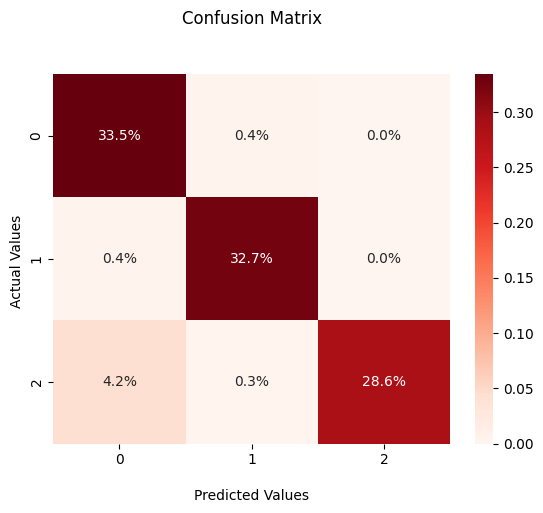

SUBJECT 19
6/6 [==============================] - 0s 45ms/step - loss: 0.3071 - accuracy: 0.8700
Score : loss of 0.3071407377719879; accuracy of 86.99861764907837%
23/23 [==============================] - 3s 22ms/step
F1 score:  0.8724629960709858
Precision:  0.9008150248361074
Recall:  0.8699861687413555


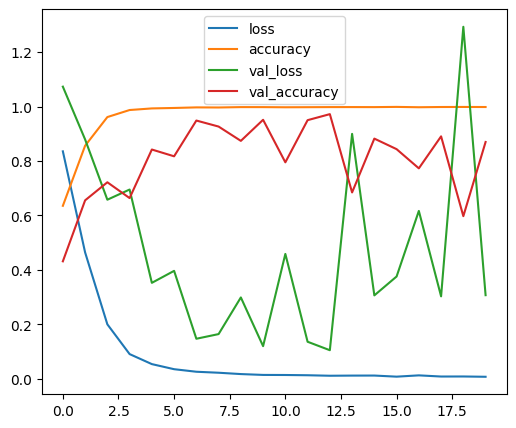

[[197  41   6]
 [  0 241   0]
 [  0  47 191]]


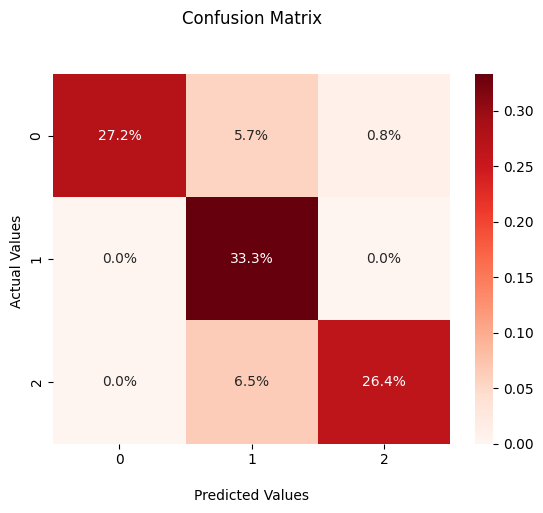

SUBJECT 20
6/6 [==============================] - 0s 45ms/step - loss: 1.0565 - accuracy: 0.6526
Score : loss of 1.0565000772476196; accuracy of 65.26458859443665%
24/24 [==============================] - 3s 22ms/step
F1 score:  0.6364214646144835
Precision:  0.8204882050691577
Recall:  0.6526458616010855


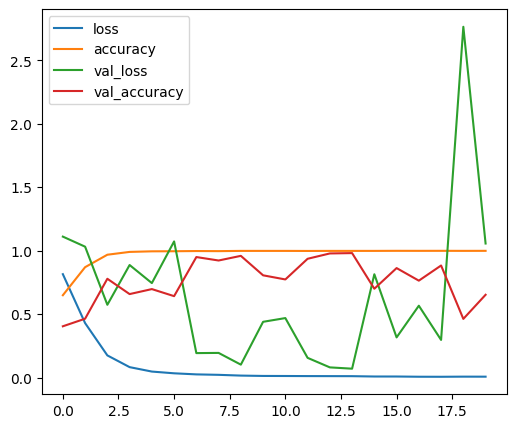

[[239   1   0]
 [ 76 163   0]
 [173   6  79]]


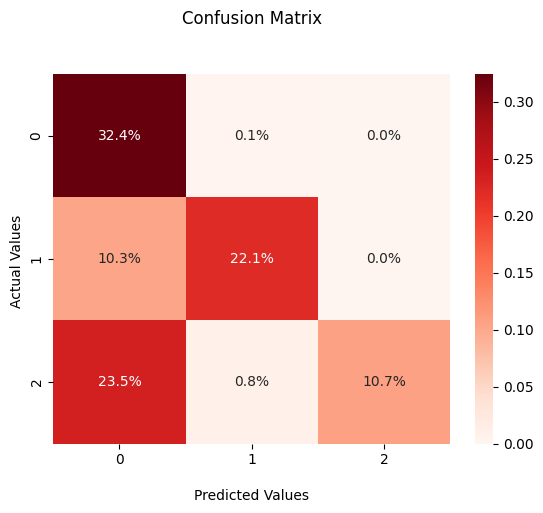

SUBJECT 21
6/6 [==============================] - 0s 44ms/step - loss: 0.7253 - accuracy: 0.7970
Score : loss of 0.7252697944641113; accuracy of 79.69613075256348%
23/23 [==============================] - 3s 22ms/step
F1 score:  0.7707749702351748
Precision:  0.8477865347259811
Recall:  0.7969613259668509


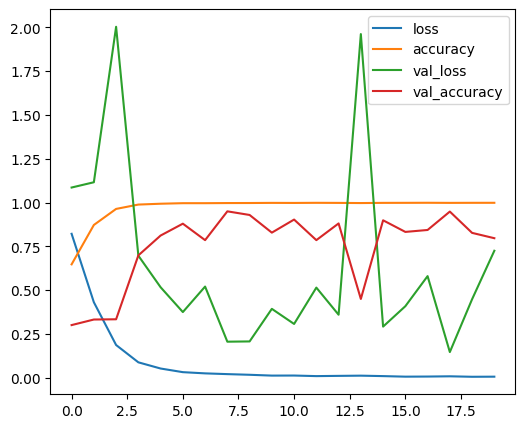

[[107  52  94]
 [  0 239   1]
 [  0   0 231]]


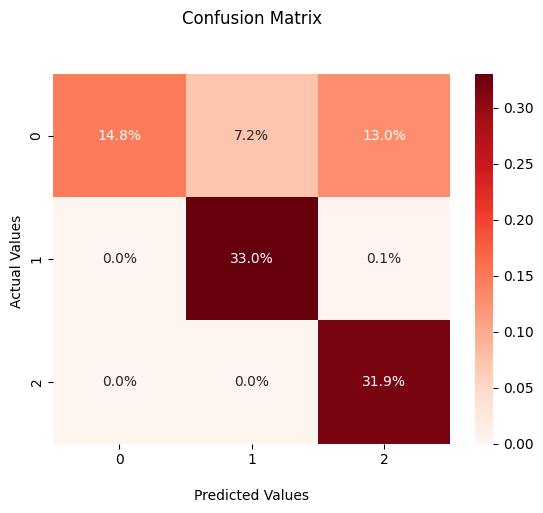

In [ ]:
from sklearn.model_selection import train_test_split


for sub in range(len(all_data)):
    print('SUBJECT',sub)

    test_data_all = all_data[sub]

    X_train_split, X_test_split, y_train_split, y_test_split = {}, {}, {}, {}

    for feature in all_features: 

      X_train_split[feature], X_test_split[feature], y_train_split[feature], y_test_split[feature] = train_test_split(
         test_data_all[feature], test_data_all['label'], test_size=0.2, random_state=3456789
         )

    
    train_data, train_data_all = {}, {}
    test_data = {}


    train_data_all["acc_x"] = np.concatenate([all_data[i]["acc_x"] for i in range(len(all_data)) if i != sub])
    train_data_all["acc_y"] = np.concatenate([all_data[i]["acc_y"] for i in range(len(all_data)) if i != sub])
    train_data_all["acc_z"] = np.concatenate([all_data[i]["acc_z"] for i in range(len(all_data)) if i != sub])
    train_data_all["eda"] = np.concatenate([all_data[i]["eda"] for i in range(len(all_data)) if i != sub])
    train_data_all["temp"] = np.concatenate([all_data[i]["temp"] for i in range(len(all_data)) if i != sub])
    train_data_all["bvp"] = np.concatenate([all_data[i]["bvp"] for i in range(len(all_data)) if i != sub])


    for feature in all_features:
      train_data[feature] = np.concatenate((train_data_all[feature], X_test_split[feature]), axis=0)


    train_data_all["label"] = np.concatenate([all_data[i]["label"] for i in range(len(all_data)) if i != sub])

    train_data["label"] = np.concatenate((train_data_all["label"], y_test_split['eda']), axis=0)


    for feature in all_features:
      test_data[feature] = X_train_split[feature]

    test_data['label'] = y_train_split['eda']

    cm_w_ft_20, acc_w_ft_20, loss_w_ft_20, f1_w_ft_20, prec_w_ft_20, rec_w_ft_20 = ResNet(train_data, test_data)

**Average accuracy and F1 score (20% ft)**

In [11]:
print(acc_w_ft_20)

[96.7391312122345, 91.92463159561157, 80.92015981674194, 84.5108687877655, 96.16963267326355, 88.49315047264099, 95.8108127117157, 93.20651888847351, 93.44490766525269, 92.07650423049927, 72.62060046195984, 81.25, 90.77134728431702, 63.215261697769165, 54.84727621078491, 89.66942429542542, 87.56756782531738, 92.77108311653137, 94.73684430122375, 86.99861764907837, 65.26458859443665, 79.69613075256348]


In [12]:
print(np.mean(acc_w_ft_20))
print((f1_w_ft_20))

85.1229572838003
0.8465672316945128


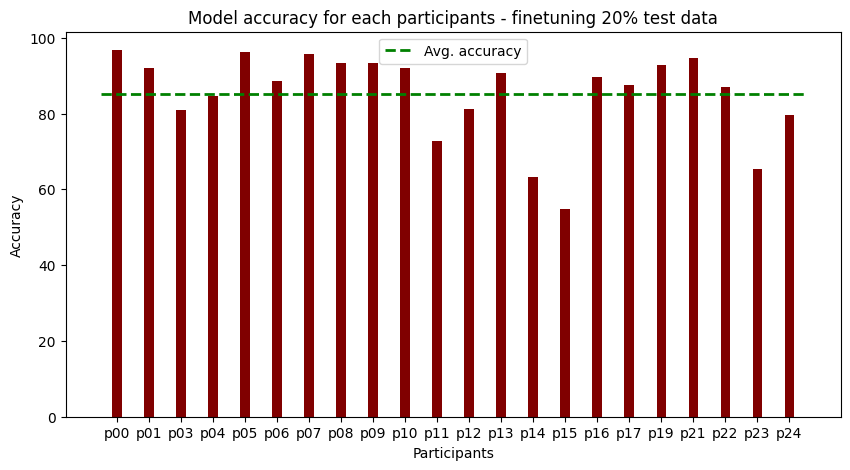

In [ ]:
fig = plt.figure(figsize = (10, 5))
 
plt.bar(participants, acc_w_ft_20, color ='maroon',width = 0.3)
 
plt.xlabel("Participants")
plt.ylabel("Accuracy")
plt.title("Model accuracy for each participants - finetuning 20% test data")

plt.hlines(y=(np.mean(acc_w_ft_20)), xmin=-0.5, xmax=(len(f1_w_ft_20)-0.5), colors='green', linestyles='--', lw=2, label='Avg. accuracy')
plt.legend()

plt.show()

# **ResNet accuracy on LOSO with and without finetuning**

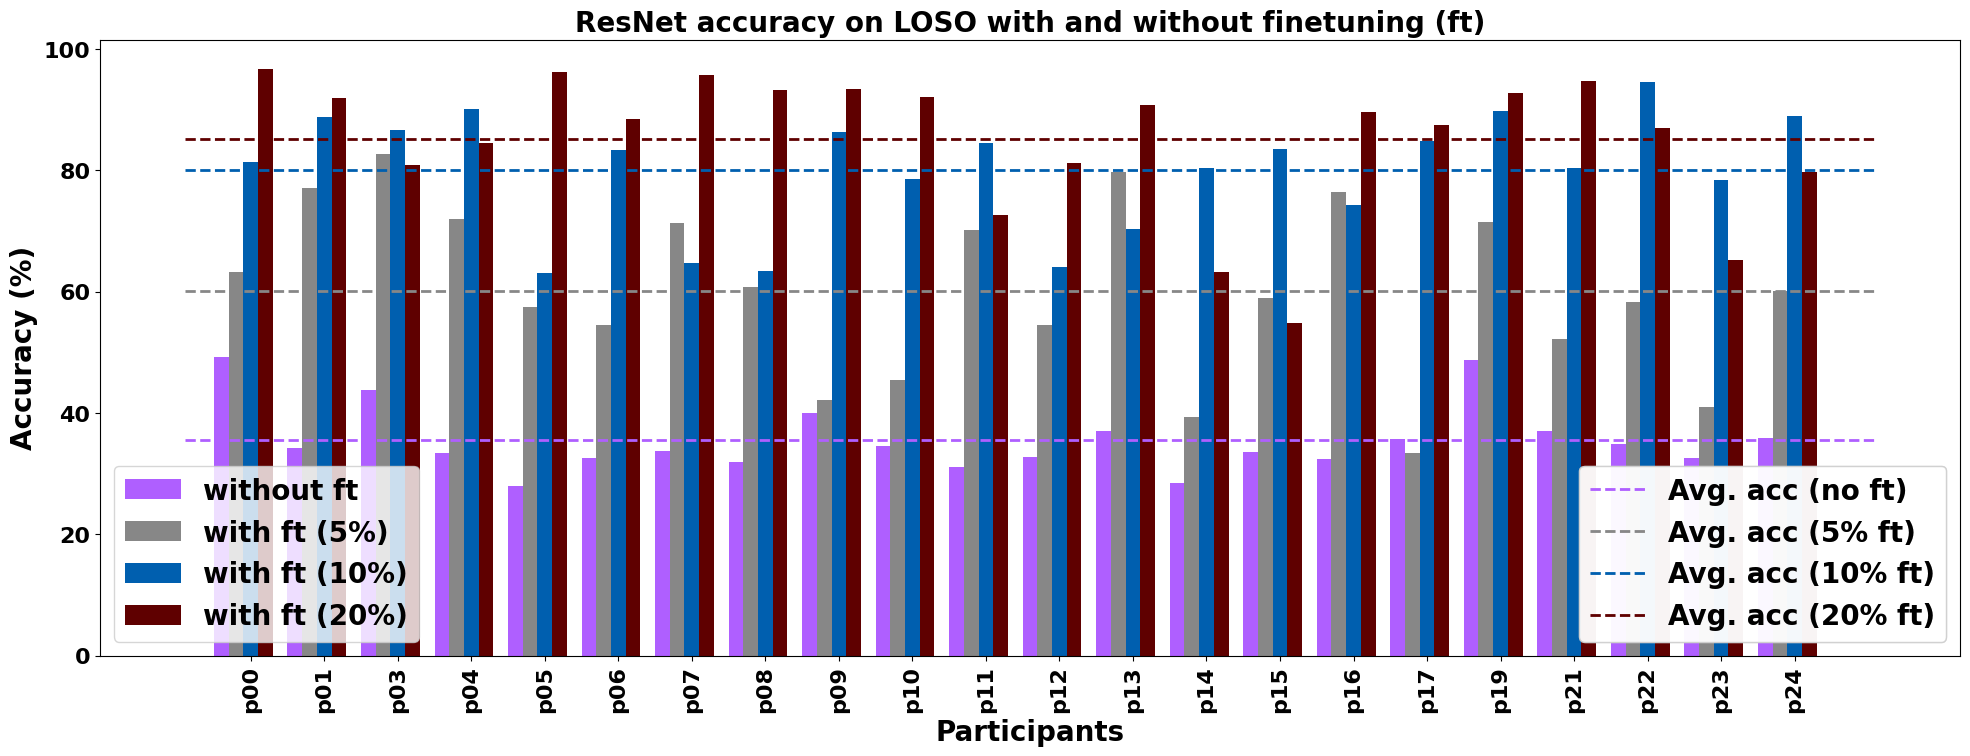

In [14]:
import matplotlib.font_manager as font_manager

N = 22
ind = np.arange(N) 
width = 0.2

plt.rcParams['figure.figsize'] = [24, 8]
wo_ft = acc_w_o_ft
bar1 = plt.bar(ind, wo_ft, width, color = '#af5fff')

w_ft_5 = acc_w_ft_5
bar2 = plt.bar(ind+width, w_ft_5, width, color = '#878787')
  
w_ft_10 = acc_w_ft_10
bar3 = plt.bar(ind+width*2, w_ft_10, width, color='#005faf')
  
w_ft_20 = acc_w_ft_20
bar4 = plt.bar(ind+width*3, w_ft_20, width, color = '#5f0000')

font = font_manager.FontProperties(weight='bold', style='normal', size=20)
  
plt.xlabel("Participants",fontsize=20, fontweight='bold')
plt.ylabel('Accuracy (%)',fontsize=20, fontweight='bold')
plt.title("ResNet accuracy on LOSO with and without finetuning (ft)",fontsize=20, fontweight='bold')
  
plt.xticks(ind+width*2,participants)
plt.xticks(fontsize=16, rotation=90, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')

legend1 = plt.legend( (bar1, bar2, bar3, bar4), ('without ft', 'with ft (5%)', 'with ft (10%)', 'with ft (20%)'), loc = 3, prop=font )
plt.hlines(y=(np.mean(wo_ft)), xmin=-0.5, xmax=(len(wo_ft)+0.5), colors='#af5fff', lw=2, label='Avg. acc (no ft)', linestyles='--')
plt.hlines(y=(np.mean(w_ft_5)), xmin=-0.5, xmax=(len(w_ft_5)+0.5), colors='#878787', lw=2, label='Avg. acc (5% ft)', linestyles='--')
plt.hlines(y=(np.mean(w_ft_10)), xmin=-0.5, xmax=(len(w_ft_10)+0.5), colors='#005faf', lw=2, label='Avg. acc (10% ft)', linestyles='--')
plt.hlines(y=(np.mean(w_ft_20)), xmin=-0.5, xmax=(len(w_ft_20)+0.5), colors='#5f0000', lw=2, label='Avg. acc (20% ft)', linestyles='--')
legend2 = plt.legend(loc = 4, prop=font)

plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)

#plt.savefig('resnet_LOSO_4.pdf') 
plt.show()

**Accuracy change in ResNet with and without fine-tuning**

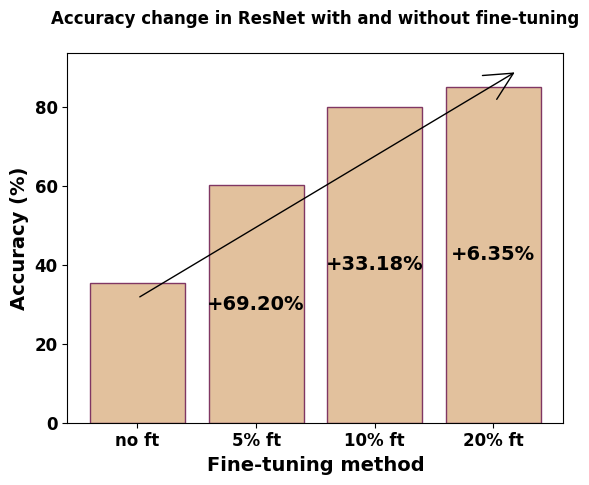

In [4]:
x = [1, 2, 3, 4]
y = [np.mean(acc_w_o_ft), np.mean(acc_w_ft_5), np.mean(acc_w_ft_10), np.mean(acc_w_ft_20)]

LABELS = ['no ft', '5% ft', '10% ft', '20% ft']

bars = plt.bar(x, y, fc='#e2c19d', ec='#803763')
plt.bar_label(bars, [''] + [f'{(y1 - y0) / y0 * 100:+.2f}%' for y0, y1 in zip(y[:-1], y[1:])],label_type='center',fontsize=14, fontweight='bold')
plt.margins(y=0.1)
plt.xticks(x, LABELS,fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

plt.annotate(text='', xy=(4.2,(np.mean(acc_w_ft_20) + 4)), xytext=(1,(np.mean(acc_w_o_ft) - 4)), arrowprops=dict(arrowstyle='->'),fontsize=50, fontweight='bold')

plt.title('Accuracy change in ResNet with and without fine-tuning\n',fontsize=12, fontweight='bold')
plt.xlabel('Fine-tuning method',fontsize=14, fontweight='bold')
plt.ylabel('Accuracy (%)',fontsize=14, fontweight='bold')
#plt.savefig('resnet_acc_change.pdf')
plt.show()